In [1]:
# Change this to the path to your folder
result_folder = '/Users/binghao/Desktop/Research/OT-singlecell/UOTReg/'

- **Note:** Before running any code cells, please update the paths in the notebook so they point to your local copy of the **UOTReg** folder.

In [2]:
import os
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
os.chdir(result_folder)
print("Current working directory:", os.getcwd())

# basic math package
import pandas as pd
import numpy as np

# loading data
import scanpy as sc

# some practical packages
import warnings
warnings.filterwarnings('ignore')
import gc
from IPython.display import clear_output

# packages for DL
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torch.distributions as distrib
import torch.distributions.transforms as transform
from torch.distributions import constraints
from tqdm import tqdm, tqdm_notebook
from copy import deepcopy

# package for matrix operation
from sklearn.decomposition import PCA
from sklearn.datasets import make_spd_matrix

# load OT functions
from UOTReg.tools import ewma, freeze, unfreeze
from UOTReg import distributions
from UOTReg.models import FFNN, Seperate_D, Seperate_T, Gnet, Encoder, Discriminator
from UOTReg.tools import tensorDataset, tensorSampler
from UOTReg.tools import weights_init, calculate_moments, calculate_weights, random_sample
from UOTReg.train_models import optimize_T_and_D, optimize_G, optimize_T_and_D_UOT_new
from UOTReg.UOT import UOT_relax_on_2

# for plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import umap

Current working directory: /Users/binghao/Desktop/Research/OT-singlecell/UOTReg


## Setup data

In [3]:
import scanpy as sc
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

# Note: this is the top 1000 HVGs of embryoid dataset, already normalized to 1e4 and log1p transformed
embryoid = sc.read(result_folder + "data/timedata/embryoid/embryoid_data.h5ad")
print(embryoid.shape)

(16821, 1000)


In [4]:
# Convert PCA array to Pandas data frame
embryoid_pc = embryoid.obsm['X_pca'][:,0:20]

embryoid_pc_df = pd.DataFrame(
    data=embryoid_pc,
    index=embryoid.obs_names,               # Row index from original AnnData object
    columns=[f"PC{i+1}" for i in range(embryoid_pc.shape[1])]  # Column names as PC1, PC2, ...
)

print(type(embryoid_pc_df))  # Should be <class 'pandas.DataFrame'>
print(embryoid_pc_df.shape)

# get the time snapshots info
cells_meta = embryoid.obs
unique_time = embryoid.obs['time'].unique().to_list()
print(unique_time)

<class 'pandas.core.frame.DataFrame'>
(16821, 20)
['Day 00-03', 'Day 06-09', 'Day 12-15', 'Day 18-21', 'Day 24-27']


In [5]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = embryoid_pc_df[embryoid.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

2381
4165
3278
3665
3332


## New OT maps fitting

In [6]:
# loading the learned generators
size = 256
DIM = 20
dropout_rate = 0.05
G1 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G2 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G3 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G4 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G5 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G6 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
G7 = Gnet(input_dim=DIM, output_dim=DIM, size=size, num_layers=4, dropout_rate=dropout_rate)
Z_sampler = distributions.StandardNormalSampler(dim=DIM, device="cpu")

print('G params:', np.sum([np.prod(p.shape) for p in G2.parameters()]))

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 

G1.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day4_25_tau5_new2.pth"))
G2.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day7_25_tau5_new2.pth"))
G3.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day10_25_tau5_new2.pth"))
G4.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day13_25_tau5_new2.pth"))
G5.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day16_25_tau5_new2.pth"))
G6.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day19_25_tau5_new2.pth"))
G7.load_state_dict(torch.load(result_folder+"results/dynamics/embryoid/estimated_distribution/G_embryoid20_256_Day22_25_tau5_new2.pth"))

G params: 207892


<All keys matched successfully>

In [7]:
# check learned distributions

G1.eval(); G2.eval(); G3.eval(); G4.eval(); G5.eval(); G6.eval(); G7.eval()
data_num = 2000
data_learned1 = G1(Z_sampler.sample(data_num)).detach().numpy()
data_learned2 = G2(Z_sampler.sample(data_num)).detach().numpy()
data_learned3 = G3(Z_sampler.sample(data_num)).detach().numpy()
data_learned4 = G4(Z_sampler.sample(data_num)).detach().numpy()
data_learned5 = G5(Z_sampler.sample(data_num)).detach().numpy()
data_learned6 = G6(Z_sampler.sample(data_num)).detach().numpy()
data_learned7 = G7(Z_sampler.sample(data_num)).detach().numpy()

# Combine original and new time labels in chronological order
time_labels = [
    'Day 00-03', 'Day 03-06 (predicted)', 'Day 06-09 (predicted)', 'Day 09-12 (predicted)', 
    'Day 12-15 (predicted)', 'Day 15-18 (predicted)', 'Day 18-21 (predicted)', 'Day 21-24 (predicted)', 'Day 24-27'
]

# Define data sources accordingly (assuming you already have the data)
data_dict_ori = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 06-09': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 06-09'],
    'Day 12-15': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 12-15'],
    'Day 18-21': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 18-21'],
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

data_dict = {
    'Day 00-03': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 00-03'],
    'Day 03-06 (predicted)': data_learned1,
    'Day 06-09 (predicted)': data_learned2,
    'Day 09-12 (predicted)': data_learned3,
    'Day 12-15 (predicted)': data_learned4,
    'Day 15-18 (predicted)': data_learned5,
    'Day 18-21 (predicted)': data_learned6,
    'Day 21-24 (predicted)': data_learned7,
    'Day 24-27': embryoid.obsm['X_pca'][embryoid.obs['time'] == 'Day 24-27']
}

In [8]:
Y_time_samplers = []

# get samplers for different time snapshots
for id in unique_time:
    X_k = embryoid_pc_df[embryoid.obs['time'] == id]
    cells_k = cells_meta[cells_meta['time'] == id]
    dataset = tensorDataset(X_k,cells_k)
    print(len(dataset))
    Y_time_samplers.append(tensorSampler(dataset, device="cpu"))

2381
4165
3278
3665
3332


In [9]:
# Construct Y_time_samplers_learned with X_k as a pandas DataFrame
# --- Assumes: torch, numpy already imported; G1..G7, Z_sampler defined & loaded; tensorDataset/tensorSampler available
import pandas as pd
import torch

torch.manual_seed(0)

day_labels = [4, 7, 10, 13, 16, 19, 22]
generators = [G1, G2, G3, G4, G5, G6, G7]
n_per_day  = 5000
DIM        = Z_sampler.dim if hasattr(Z_sampler, "dim") else 20   # keep DIM consistent
device     = torch.device("cpu")

# Choose column names for the DataFrame
try:
    X_cols = list(embryoid_pc_df.columns)[:DIM]
    if len(X_cols) != DIM:
        raise ValueError("embryoid_pc_df has incompatible number of columns.")
except Exception:
    X_cols = [f"pc{i+1}" for i in range(DIM)]

for G in generators:
    G.eval()

Y_time_samplers_learned = []
for day, G in zip(day_labels, generators):
    with torch.no_grad():
        Z_t   = Z_sampler.sample(n_per_day)                   # torch [n, DIM]
        X_t   = G(Z_t).detach().to(device).float()            # torch [n, DIM]
        X_np  = X_t.cpu().numpy()                             # numpy [n, DIM]
        X_k   = pd.DataFrame(X_np, columns=X_cols)            # <-- pandas DataFrame

    cells_k = pd.DataFrame({
        "cell_id": [f"d{day}_{i}" for i in range(n_per_day)],
        "time":    day,
        "day":     day
    })

    dataset_k = tensorDataset(X_k, cells_k)
    sampler_k = tensorSampler(dataset_k, device="cpu")
    Y_time_samplers_learned.append(sampler_k)

    print(f"Day {day}: dataset size = {len(dataset_k)}, X_k shape = {X_k.shape}, columns = {X_k.columns[:3].tolist()}...")


Day 4: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 7: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 10: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 13: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 16: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 19: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...
Day 22: dataset size = 5000, X_k shape = (5000, 20), columns = ['PC1', 'PC2', 'PC3']...


In [10]:
Y_time_samplers_mix = [Y_time_samplers[0], *Y_time_samplers_learned, Y_time_samplers[-1]]

- You can execute the code below to train your own UOTReg maps (ensure the save folder is correctly specified). 

- Alternatively, skip training and use the provided results to reproduce the figures.

In [ ]:
import torch
import os
import pickle

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Define hyperparameters
it = 0
BATCH_SIZE = 128
D_ITERS = 300
T_ITERS = 100

save_path = "/Path/to/your/folder"

# Ensure save directory exists
# os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(8):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)
    
    # Apply weight initialization
    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path+ f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=50)

    # Save the trained transport map
    # map_filename = os.path.join(save_path, f"T_map_{i}_to_{i+1}.pt")
    # torch.save(T.state_dict(), map_filename)

    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i+1} to {i+2} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")


Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/300 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/300 [00:00<03:50,  1.30it/s]

UOT (relax on 2): total_iters: 1, d_iter: 1


  1%|          | 2/300 [00:01<03:33,  1.39it/s]

UOT (relax on 2): total_iters: 2, d_iter: 2


  1%|          | 2/300 [00:01<04:33,  1.09it/s]


KeyboardInterrupt: 

- You can execute the code below to train your own WOT-style maps (ensure the save folder is correctly specified). 

- Alternatively, skip training and use the provided results to reproduce the figures.

In [ ]:
# Directly composing the trajectories

import torch
import os
import pickle

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

# Define hyperparameters
it = 0
BATCH_SIZE = 128
D_ITERS = 200
T_ITERS = 100
save_path = "/Path/to/your/folder"

# Ensure save directory exists
# os.makedirs(save_path, exist_ok=True)

# Loop through the sequence to train OT maps from i -> i+1
for i in range(4):
    print(f"Training OT map from Ysamplers[{i}] to Ysamplers[{i+1}]")

    # Initialize networks
    T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)
    D = FFNN(input_size, task_specific_hidden_size_D, n_hidden, 1, bn=False, dropout_rate=dropout_rate)
    
    # Apply weight initialization
    if i == 0 :
        T.apply(weights_init)
        D.apply(weights_init)
    else:
        Tparam = torch.load(save_path + f"/T_map_{i}_to_{i+1}.pt")
        T.load_state_dict(Tparam)
        Dparam = torch.load(save_path + f"/D_{i}_to_{i+1}.pt")
        D.load_state_dict(Dparam)

    # Define optimizers
    T_opt = optim.Adam(T.parameters(), lr=D_LR, weight_decay=1e-10)
    D_opt = optim.Adam(D.parameters(), lr=D_LR, weight_decay=1e-10)

    # Train the OT map
    # it = OT(it, T, D, T_opt, D_opt, Y_time_samplers_mix[i], Y_time_samplers_mix[i + 1], BATCH_SIZE, D_ITERS, T_ITERS)
    it = UOT_relax_on_2(it, T, D, T_opt, D_opt, Y_time_samplers[i], Y_time_samplers[i + 1], BATCH_SIZE, D_ITERS, T_ITERS, tau=50)

    map_filename_T = os.path.join(save_path, f"T_map_{i+1}_to_{i+2}.pt")
    filename_D = os.path.join(save_path, f"D_{i+1}_to_{i+2}.pt")
    torch.save(T.state_dict(), map_filename_T)
    torch.save(D.state_dict(), filename_D)

    print(f"Saved OT map from {i+1} to {i+2} at {map_filename_T}")

print("All OT maps have been trained and saved successfully.")


Training OT map from Ysamplers[0] to Ysamplers[1]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 0, d_iter: 0


  0%|          | 1/200 [00:00<02:22,  1.40it/s]

UOT (relax on 2): total_iters: 1, d_iter: 1


  1%|          | 2/200 [00:01<02:16,  1.45it/s]

UOT (relax on 2): total_iters: 2, d_iter: 2


  2%|▏         | 3/200 [00:02<02:14,  1.46it/s]

UOT (relax on 2): total_iters: 3, d_iter: 3


  2%|▏         | 4/200 [00:02<02:13,  1.47it/s]

UOT (relax on 2): total_iters: 4, d_iter: 4


  2%|▎         | 5/200 [00:03<02:12,  1.48it/s]

UOT (relax on 2): total_iters: 5, d_iter: 5


  3%|▎         | 6/200 [00:04<02:10,  1.48it/s]

UOT (relax on 2): total_iters: 6, d_iter: 6


  4%|▎         | 7/200 [00:04<02:10,  1.48it/s]

UOT (relax on 2): total_iters: 7, d_iter: 7


  4%|▍         | 8/200 [00:05<02:10,  1.48it/s]

UOT (relax on 2): total_iters: 8, d_iter: 8


  4%|▍         | 9/200 [00:06<02:09,  1.48it/s]

UOT (relax on 2): total_iters: 9, d_iter: 9


  5%|▌         | 10/200 [00:06<02:08,  1.48it/s]

UOT (relax on 2): total_iters: 10, d_iter: 10


  6%|▌         | 11/200 [00:07<02:08,  1.48it/s]

UOT (relax on 2): total_iters: 11, d_iter: 11


  6%|▌         | 12/200 [00:08<02:07,  1.48it/s]

UOT (relax on 2): total_iters: 12, d_iter: 12


  6%|▋         | 13/200 [00:08<02:05,  1.49it/s]

UOT (relax on 2): total_iters: 13, d_iter: 13


  7%|▋         | 14/200 [00:09<02:04,  1.49it/s]

UOT (relax on 2): total_iters: 14, d_iter: 14


  8%|▊         | 15/200 [00:10<02:03,  1.50it/s]

UOT (relax on 2): total_iters: 15, d_iter: 15


  8%|▊         | 16/200 [00:10<02:02,  1.50it/s]

UOT (relax on 2): total_iters: 16, d_iter: 16


  8%|▊         | 17/200 [00:11<02:02,  1.50it/s]

UOT (relax on 2): total_iters: 17, d_iter: 17


  9%|▉         | 18/200 [00:12<02:01,  1.50it/s]

UOT (relax on 2): total_iters: 18, d_iter: 18


 10%|▉         | 19/200 [00:12<02:00,  1.50it/s]

UOT (relax on 2): total_iters: 19, d_iter: 19


 10%|█         | 20/200 [00:13<02:00,  1.50it/s]

UOT (relax on 2): total_iters: 20, d_iter: 20


 10%|█         | 21/200 [00:14<01:59,  1.49it/s]

UOT (relax on 2): total_iters: 21, d_iter: 21


 11%|█         | 22/200 [00:14<01:59,  1.49it/s]

UOT (relax on 2): total_iters: 22, d_iter: 22


 12%|█▏        | 23/200 [00:15<01:59,  1.48it/s]

UOT (relax on 2): total_iters: 23, d_iter: 23


 12%|█▏        | 24/200 [00:16<02:00,  1.47it/s]

UOT (relax on 2): total_iters: 24, d_iter: 24


 12%|█▎        | 25/200 [00:16<01:58,  1.47it/s]

UOT (relax on 2): total_iters: 25, d_iter: 25


 13%|█▎        | 26/200 [00:17<01:57,  1.48it/s]

UOT (relax on 2): total_iters: 26, d_iter: 26


 14%|█▎        | 27/200 [00:18<01:56,  1.49it/s]

UOT (relax on 2): total_iters: 27, d_iter: 27


 14%|█▍        | 28/200 [00:18<01:55,  1.49it/s]

UOT (relax on 2): total_iters: 28, d_iter: 28


 14%|█▍        | 29/200 [00:19<01:54,  1.50it/s]

UOT (relax on 2): total_iters: 29, d_iter: 29


 15%|█▌        | 30/200 [00:20<01:53,  1.50it/s]

UOT (relax on 2): total_iters: 30, d_iter: 30


 16%|█▌        | 31/200 [00:20<01:53,  1.50it/s]

UOT (relax on 2): total_iters: 31, d_iter: 31


 16%|█▌        | 32/200 [00:21<01:52,  1.50it/s]

UOT (relax on 2): total_iters: 32, d_iter: 32


 16%|█▋        | 33/200 [00:22<01:51,  1.50it/s]

UOT (relax on 2): total_iters: 33, d_iter: 33


 17%|█▋        | 34/200 [00:22<01:50,  1.50it/s]

UOT (relax on 2): total_iters: 34, d_iter: 34


 18%|█▊        | 35/200 [00:23<01:50,  1.49it/s]

UOT (relax on 2): total_iters: 35, d_iter: 35


 18%|█▊        | 36/200 [00:24<01:49,  1.49it/s]

UOT (relax on 2): total_iters: 36, d_iter: 36


 18%|█▊        | 37/200 [00:24<01:50,  1.48it/s]

UOT (relax on 2): total_iters: 37, d_iter: 37


 19%|█▉        | 38/200 [00:25<01:49,  1.48it/s]

UOT (relax on 2): total_iters: 38, d_iter: 38


 20%|█▉        | 39/200 [00:26<01:48,  1.48it/s]

UOT (relax on 2): total_iters: 39, d_iter: 39


 20%|██        | 40/200 [00:26<01:48,  1.48it/s]

UOT (relax on 2): total_iters: 40, d_iter: 40


 20%|██        | 41/200 [00:27<01:47,  1.48it/s]

UOT (relax on 2): total_iters: 41, d_iter: 41


 21%|██        | 42/200 [00:28<01:45,  1.49it/s]

UOT (relax on 2): total_iters: 42, d_iter: 42


 22%|██▏       | 43/200 [00:28<01:45,  1.49it/s]

UOT (relax on 2): total_iters: 43, d_iter: 43


 22%|██▏       | 44/200 [00:29<01:44,  1.49it/s]

UOT (relax on 2): total_iters: 44, d_iter: 44


 22%|██▎       | 45/200 [00:30<01:43,  1.49it/s]

UOT (relax on 2): total_iters: 45, d_iter: 45


 23%|██▎       | 46/200 [00:30<01:42,  1.50it/s]

UOT (relax on 2): total_iters: 46, d_iter: 46


 24%|██▎       | 47/200 [00:31<01:41,  1.50it/s]

UOT (relax on 2): total_iters: 47, d_iter: 47


 24%|██▍       | 48/200 [00:32<01:41,  1.50it/s]

UOT (relax on 2): total_iters: 48, d_iter: 48


 24%|██▍       | 49/200 [00:32<01:40,  1.50it/s]

UOT (relax on 2): total_iters: 49, d_iter: 49


 25%|██▌       | 50/200 [00:33<01:40,  1.50it/s]

UOT (relax on 2): total_iters: 50, d_iter: 50


 26%|██▌       | 51/200 [00:34<01:40,  1.48it/s]

UOT (relax on 2): total_iters: 51, d_iter: 51


 26%|██▌       | 52/200 [00:34<01:39,  1.49it/s]

UOT (relax on 2): total_iters: 52, d_iter: 52


 26%|██▋       | 53/200 [00:35<01:38,  1.49it/s]

UOT (relax on 2): total_iters: 53, d_iter: 53


 27%|██▋       | 54/200 [00:36<01:37,  1.49it/s]

UOT (relax on 2): total_iters: 54, d_iter: 54


 28%|██▊       | 55/200 [00:36<01:37,  1.49it/s]

UOT (relax on 2): total_iters: 55, d_iter: 55


 28%|██▊       | 56/200 [00:37<01:36,  1.49it/s]

UOT (relax on 2): total_iters: 56, d_iter: 56


 28%|██▊       | 57/200 [00:38<01:35,  1.49it/s]

UOT (relax on 2): total_iters: 57, d_iter: 57


 29%|██▉       | 58/200 [00:38<01:35,  1.48it/s]

UOT (relax on 2): total_iters: 58, d_iter: 58


 30%|██▉       | 59/200 [00:39<01:34,  1.49it/s]

UOT (relax on 2): total_iters: 59, d_iter: 59


 30%|███       | 60/200 [00:40<01:33,  1.49it/s]

UOT (relax on 2): total_iters: 60, d_iter: 60


 30%|███       | 61/200 [00:40<01:32,  1.50it/s]

UOT (relax on 2): total_iters: 61, d_iter: 61


 31%|███       | 62/200 [00:41<01:32,  1.50it/s]

UOT (relax on 2): total_iters: 62, d_iter: 62


 32%|███▏      | 63/200 [00:42<01:31,  1.50it/s]

UOT (relax on 2): total_iters: 63, d_iter: 63


 32%|███▏      | 64/200 [00:43<01:31,  1.48it/s]

UOT (relax on 2): total_iters: 64, d_iter: 64


 32%|███▎      | 65/200 [00:43<01:30,  1.49it/s]

UOT (relax on 2): total_iters: 65, d_iter: 65


 33%|███▎      | 66/200 [00:44<01:29,  1.49it/s]

UOT (relax on 2): total_iters: 66, d_iter: 66


 34%|███▎      | 67/200 [00:45<01:29,  1.49it/s]

UOT (relax on 2): total_iters: 67, d_iter: 67


 34%|███▍      | 68/200 [00:45<01:28,  1.49it/s]

UOT (relax on 2): total_iters: 68, d_iter: 68


 34%|███▍      | 69/200 [00:46<01:27,  1.49it/s]

UOT (relax on 2): total_iters: 69, d_iter: 69


 35%|███▌      | 70/200 [00:47<01:27,  1.49it/s]

UOT (relax on 2): total_iters: 70, d_iter: 70


 36%|███▌      | 71/200 [00:47<01:26,  1.49it/s]

UOT (relax on 2): total_iters: 71, d_iter: 71


 36%|███▌      | 72/200 [00:48<01:26,  1.49it/s]

UOT (relax on 2): total_iters: 72, d_iter: 72


 36%|███▋      | 73/200 [00:49<01:25,  1.48it/s]

UOT (relax on 2): total_iters: 73, d_iter: 73


 37%|███▋      | 74/200 [00:49<01:24,  1.49it/s]

UOT (relax on 2): total_iters: 74, d_iter: 74


 38%|███▊      | 75/200 [00:50<01:23,  1.50it/s]

UOT (relax on 2): total_iters: 75, d_iter: 75


 38%|███▊      | 76/200 [00:51<01:22,  1.50it/s]

UOT (relax on 2): total_iters: 76, d_iter: 76


 38%|███▊      | 77/200 [00:51<01:22,  1.50it/s]

UOT (relax on 2): total_iters: 77, d_iter: 77


 39%|███▉      | 78/200 [00:52<01:22,  1.48it/s]

UOT (relax on 2): total_iters: 78, d_iter: 78


 40%|███▉      | 79/200 [00:53<01:21,  1.49it/s]

UOT (relax on 2): total_iters: 79, d_iter: 79


 40%|████      | 80/200 [00:53<01:20,  1.49it/s]

UOT (relax on 2): total_iters: 80, d_iter: 80


 40%|████      | 81/200 [00:54<01:19,  1.49it/s]

UOT (relax on 2): total_iters: 81, d_iter: 81


 41%|████      | 82/200 [00:55<01:18,  1.49it/s]

UOT (relax on 2): total_iters: 82, d_iter: 82


 42%|████▏     | 83/200 [00:55<01:18,  1.49it/s]

UOT (relax on 2): total_iters: 83, d_iter: 83


 42%|████▏     | 84/200 [00:56<01:17,  1.50it/s]

UOT (relax on 2): total_iters: 84, d_iter: 84


 42%|████▎     | 85/200 [00:57<01:17,  1.49it/s]

UOT (relax on 2): total_iters: 85, d_iter: 85


 43%|████▎     | 86/200 [00:57<01:16,  1.49it/s]

UOT (relax on 2): total_iters: 86, d_iter: 86


 44%|████▎     | 87/200 [00:58<01:16,  1.48it/s]

UOT (relax on 2): total_iters: 87, d_iter: 87


 44%|████▍     | 88/200 [00:59<01:15,  1.49it/s]

UOT (relax on 2): total_iters: 88, d_iter: 88


 44%|████▍     | 89/200 [00:59<01:14,  1.49it/s]

UOT (relax on 2): total_iters: 89, d_iter: 89


 45%|████▌     | 90/200 [01:00<01:13,  1.49it/s]

UOT (relax on 2): total_iters: 90, d_iter: 90


 46%|████▌     | 91/200 [01:01<01:12,  1.50it/s]

UOT (relax on 2): total_iters: 91, d_iter: 91


 46%|████▌     | 92/200 [01:01<01:12,  1.48it/s]

UOT (relax on 2): total_iters: 92, d_iter: 92


 46%|████▋     | 93/200 [01:02<01:12,  1.49it/s]

UOT (relax on 2): total_iters: 93, d_iter: 93


 47%|████▋     | 94/200 [01:03<01:10,  1.49it/s]

UOT (relax on 2): total_iters: 94, d_iter: 94


 48%|████▊     | 95/200 [01:03<01:10,  1.49it/s]

UOT (relax on 2): total_iters: 95, d_iter: 95


 48%|████▊     | 96/200 [01:04<01:09,  1.49it/s]

UOT (relax on 2): total_iters: 96, d_iter: 96


 48%|████▊     | 97/200 [01:05<01:08,  1.50it/s]

UOT (relax on 2): total_iters: 97, d_iter: 97


 49%|████▉     | 98/200 [01:05<01:08,  1.50it/s]

UOT (relax on 2): total_iters: 98, d_iter: 98


 50%|████▉     | 99/200 [01:06<01:07,  1.49it/s]

UOT (relax on 2): total_iters: 99, d_iter: 99


 50%|█████     | 100/200 [01:07<01:07,  1.49it/s]

UOT (relax on 2): total_iters: 100, d_iter: 100


 50%|█████     | 101/200 [01:07<01:06,  1.49it/s]

UOT (relax on 2): total_iters: 101, d_iter: 101


 51%|█████     | 102/200 [01:08<01:05,  1.49it/s]

UOT (relax on 2): total_iters: 102, d_iter: 102


 52%|█████▏    | 103/200 [01:09<01:05,  1.49it/s]

UOT (relax on 2): total_iters: 103, d_iter: 103


 52%|█████▏    | 104/200 [01:09<01:04,  1.49it/s]

UOT (relax on 2): total_iters: 104, d_iter: 104


 52%|█████▎    | 105/200 [01:10<01:04,  1.48it/s]

UOT (relax on 2): total_iters: 105, d_iter: 105


 53%|█████▎    | 106/200 [01:11<01:03,  1.49it/s]

UOT (relax on 2): total_iters: 106, d_iter: 106


 54%|█████▎    | 107/200 [01:11<01:02,  1.49it/s]

UOT (relax on 2): total_iters: 107, d_iter: 107


 54%|█████▍    | 108/200 [01:12<01:01,  1.49it/s]

UOT (relax on 2): total_iters: 108, d_iter: 108


 55%|█████▍    | 109/200 [01:13<01:01,  1.49it/s]

UOT (relax on 2): total_iters: 109, d_iter: 109


 55%|█████▌    | 110/200 [01:13<01:00,  1.49it/s]

UOT (relax on 2): total_iters: 110, d_iter: 110


 56%|█████▌    | 111/200 [01:14<00:59,  1.49it/s]

UOT (relax on 2): total_iters: 111, d_iter: 111


 56%|█████▌    | 112/200 [01:15<00:59,  1.49it/s]

UOT (relax on 2): total_iters: 112, d_iter: 112


 56%|█████▋    | 113/200 [01:15<00:58,  1.49it/s]

UOT (relax on 2): total_iters: 113, d_iter: 113


 57%|█████▋    | 114/200 [01:16<00:57,  1.49it/s]

UOT (relax on 2): total_iters: 114, d_iter: 114


 57%|█████▊    | 115/200 [01:17<00:56,  1.49it/s]

UOT (relax on 2): total_iters: 115, d_iter: 115


 58%|█████▊    | 116/200 [01:17<00:56,  1.49it/s]

UOT (relax on 2): total_iters: 116, d_iter: 116


 58%|█████▊    | 117/200 [01:18<00:55,  1.49it/s]

UOT (relax on 2): total_iters: 117, d_iter: 117


 59%|█████▉    | 118/200 [01:19<00:55,  1.48it/s]

UOT (relax on 2): total_iters: 118, d_iter: 118


 60%|█████▉    | 119/200 [01:19<00:55,  1.47it/s]

UOT (relax on 2): total_iters: 119, d_iter: 119


 60%|██████    | 120/200 [01:20<00:53,  1.48it/s]

UOT (relax on 2): total_iters: 120, d_iter: 120


 60%|██████    | 121/200 [01:21<00:53,  1.49it/s]

UOT (relax on 2): total_iters: 121, d_iter: 121


 61%|██████    | 122/200 [01:21<00:52,  1.50it/s]

UOT (relax on 2): total_iters: 122, d_iter: 122


 62%|██████▏   | 123/200 [01:22<00:51,  1.50it/s]

UOT (relax on 2): total_iters: 123, d_iter: 123


 62%|██████▏   | 124/200 [01:23<00:50,  1.50it/s]

UOT (relax on 2): total_iters: 124, d_iter: 124


 62%|██████▎   | 125/200 [01:23<00:49,  1.50it/s]

UOT (relax on 2): total_iters: 125, d_iter: 125


 63%|██████▎   | 126/200 [01:24<00:49,  1.50it/s]

UOT (relax on 2): total_iters: 126, d_iter: 126


 64%|██████▎   | 127/200 [01:25<00:48,  1.49it/s]

UOT (relax on 2): total_iters: 127, d_iter: 127


 64%|██████▍   | 128/200 [01:25<00:48,  1.48it/s]

UOT (relax on 2): total_iters: 128, d_iter: 128


 64%|██████▍   | 129/200 [01:26<00:47,  1.50it/s]

UOT (relax on 2): total_iters: 129, d_iter: 129


 65%|██████▌   | 130/200 [01:27<00:46,  1.51it/s]

UOT (relax on 2): total_iters: 130, d_iter: 130


 66%|██████▌   | 131/200 [01:27<00:45,  1.53it/s]

UOT (relax on 2): total_iters: 131, d_iter: 131


 66%|██████▌   | 132/200 [01:28<00:44,  1.53it/s]

UOT (relax on 2): total_iters: 132, d_iter: 132


 66%|██████▋   | 133/200 [01:29<00:43,  1.53it/s]

UOT (relax on 2): total_iters: 133, d_iter: 133


 67%|██████▋   | 134/200 [01:29<00:42,  1.54it/s]

UOT (relax on 2): total_iters: 134, d_iter: 134


 68%|██████▊   | 135/200 [01:30<00:42,  1.54it/s]

UOT (relax on 2): total_iters: 135, d_iter: 135


 68%|██████▊   | 136/200 [01:31<00:41,  1.55it/s]

UOT (relax on 2): total_iters: 136, d_iter: 136


 68%|██████▊   | 137/200 [01:31<00:40,  1.56it/s]

UOT (relax on 2): total_iters: 137, d_iter: 137


 69%|██████▉   | 138/200 [01:32<00:39,  1.56it/s]

UOT (relax on 2): total_iters: 138, d_iter: 138


 70%|██████▉   | 139/200 [01:33<00:39,  1.56it/s]

UOT (relax on 2): total_iters: 139, d_iter: 139


 70%|███████   | 140/200 [01:33<00:38,  1.56it/s]

UOT (relax on 2): total_iters: 140, d_iter: 140


 70%|███████   | 141/200 [01:34<00:38,  1.54it/s]

UOT (relax on 2): total_iters: 141, d_iter: 141


 71%|███████   | 142/200 [01:34<00:37,  1.55it/s]

UOT (relax on 2): total_iters: 142, d_iter: 142


 72%|███████▏  | 143/200 [01:35<00:36,  1.55it/s]

UOT (relax on 2): total_iters: 143, d_iter: 143


 72%|███████▏  | 144/200 [01:36<00:36,  1.54it/s]

UOT (relax on 2): total_iters: 144, d_iter: 144


 72%|███████▎  | 145/200 [01:36<00:35,  1.55it/s]

UOT (relax on 2): total_iters: 145, d_iter: 145


 73%|███████▎  | 146/200 [01:37<00:34,  1.55it/s]

UOT (relax on 2): total_iters: 146, d_iter: 146


 74%|███████▎  | 147/200 [01:38<00:34,  1.55it/s]

UOT (relax on 2): total_iters: 147, d_iter: 147


 74%|███████▍  | 148/200 [01:38<00:33,  1.55it/s]

UOT (relax on 2): total_iters: 148, d_iter: 148


 74%|███████▍  | 149/200 [01:39<00:32,  1.55it/s]

UOT (relax on 2): total_iters: 149, d_iter: 149


 75%|███████▌  | 150/200 [01:40<00:32,  1.55it/s]

UOT (relax on 2): total_iters: 150, d_iter: 150


 76%|███████▌  | 151/200 [01:40<00:31,  1.56it/s]

UOT (relax on 2): total_iters: 151, d_iter: 151


 76%|███████▌  | 152/200 [01:41<00:30,  1.55it/s]

UOT (relax on 2): total_iters: 152, d_iter: 152


 76%|███████▋  | 153/200 [01:42<00:30,  1.56it/s]

UOT (relax on 2): total_iters: 153, d_iter: 153


 77%|███████▋  | 154/200 [01:42<00:29,  1.54it/s]

UOT (relax on 2): total_iters: 154, d_iter: 154


 78%|███████▊  | 155/200 [01:43<00:28,  1.55it/s]

UOT (relax on 2): total_iters: 155, d_iter: 155


 78%|███████▊  | 156/200 [01:43<00:28,  1.56it/s]

UOT (relax on 2): total_iters: 156, d_iter: 156


 78%|███████▊  | 157/200 [01:44<00:27,  1.57it/s]

UOT (relax on 2): total_iters: 157, d_iter: 157


 79%|███████▉  | 158/200 [01:45<00:26,  1.56it/s]

UOT (relax on 2): total_iters: 158, d_iter: 158


 80%|███████▉  | 159/200 [01:45<00:26,  1.54it/s]

UOT (relax on 2): total_iters: 159, d_iter: 159


 80%|████████  | 160/200 [01:46<00:26,  1.49it/s]

UOT (relax on 2): total_iters: 160, d_iter: 160


 80%|████████  | 161/200 [01:47<00:26,  1.48it/s]

UOT (relax on 2): total_iters: 161, d_iter: 161


 81%|████████  | 162/200 [01:48<00:25,  1.46it/s]

UOT (relax on 2): total_iters: 162, d_iter: 162


 82%|████████▏ | 163/200 [01:48<00:25,  1.46it/s]

UOT (relax on 2): total_iters: 163, d_iter: 163


 82%|████████▏ | 164/200 [01:49<00:24,  1.47it/s]

UOT (relax on 2): total_iters: 164, d_iter: 164


 82%|████████▎ | 165/200 [01:50<00:23,  1.47it/s]

UOT (relax on 2): total_iters: 165, d_iter: 165


 83%|████████▎ | 166/200 [01:50<00:23,  1.42it/s]

UOT (relax on 2): total_iters: 166, d_iter: 166


 84%|████████▎ | 167/200 [01:51<00:23,  1.43it/s]

UOT (relax on 2): total_iters: 167, d_iter: 167


 84%|████████▍ | 168/200 [01:52<00:22,  1.45it/s]

UOT (relax on 2): total_iters: 168, d_iter: 168


 84%|████████▍ | 169/200 [01:52<00:21,  1.45it/s]

UOT (relax on 2): total_iters: 169, d_iter: 169


 85%|████████▌ | 170/200 [01:53<00:20,  1.45it/s]

UOT (relax on 2): total_iters: 170, d_iter: 170


 86%|████████▌ | 171/200 [01:54<00:20,  1.45it/s]

UOT (relax on 2): total_iters: 171, d_iter: 171


 86%|████████▌ | 172/200 [01:54<00:19,  1.45it/s]

UOT (relax on 2): total_iters: 172, d_iter: 172


 86%|████████▋ | 173/200 [01:55<00:18,  1.46it/s]

UOT (relax on 2): total_iters: 173, d_iter: 173


 87%|████████▋ | 174/200 [01:56<00:17,  1.46it/s]

UOT (relax on 2): total_iters: 174, d_iter: 174


 88%|████████▊ | 175/200 [01:56<00:17,  1.47it/s]

UOT (relax on 2): total_iters: 175, d_iter: 175


 88%|████████▊ | 176/200 [01:57<00:16,  1.47it/s]

UOT (relax on 2): total_iters: 176, d_iter: 176


 88%|████████▊ | 177/200 [01:58<00:15,  1.46it/s]

UOT (relax on 2): total_iters: 177, d_iter: 177


 89%|████████▉ | 178/200 [01:59<00:14,  1.47it/s]

UOT (relax on 2): total_iters: 178, d_iter: 178


 90%|████████▉ | 179/200 [01:59<00:14,  1.41it/s]

UOT (relax on 2): total_iters: 179, d_iter: 179


 90%|█████████ | 180/200 [02:00<00:14,  1.39it/s]

UOT (relax on 2): total_iters: 180, d_iter: 180


 90%|█████████ | 181/200 [02:01<00:14,  1.35it/s]

UOT (relax on 2): total_iters: 181, d_iter: 181


 91%|█████████ | 182/200 [02:02<00:13,  1.35it/s]

UOT (relax on 2): total_iters: 182, d_iter: 182


 92%|█████████▏| 183/200 [02:02<00:12,  1.34it/s]

UOT (relax on 2): total_iters: 183, d_iter: 183


 92%|█████████▏| 184/200 [02:03<00:11,  1.39it/s]

UOT (relax on 2): total_iters: 184, d_iter: 184


 92%|█████████▎| 185/200 [02:04<00:10,  1.44it/s]

UOT (relax on 2): total_iters: 185, d_iter: 185


 93%|█████████▎| 186/200 [02:04<00:09,  1.48it/s]

UOT (relax on 2): total_iters: 186, d_iter: 186


 94%|█████████▎| 187/200 [02:05<00:08,  1.50it/s]

UOT (relax on 2): total_iters: 187, d_iter: 187


 94%|█████████▍| 188/200 [02:06<00:07,  1.51it/s]

UOT (relax on 2): total_iters: 188, d_iter: 188


 94%|█████████▍| 189/200 [02:06<00:07,  1.50it/s]

UOT (relax on 2): total_iters: 189, d_iter: 189


 95%|█████████▌| 190/200 [02:07<00:06,  1.47it/s]

UOT (relax on 2): total_iters: 190, d_iter: 190


 96%|█████████▌| 191/200 [02:08<00:06,  1.42it/s]

UOT (relax on 2): total_iters: 191, d_iter: 191


 96%|█████████▌| 192/200 [02:08<00:05,  1.42it/s]

UOT (relax on 2): total_iters: 192, d_iter: 192


 96%|█████████▋| 193/200 [02:09<00:04,  1.43it/s]

UOT (relax on 2): total_iters: 193, d_iter: 193


 97%|█████████▋| 194/200 [02:10<00:04,  1.43it/s]

UOT (relax on 2): total_iters: 194, d_iter: 194


 98%|█████████▊| 195/200 [02:11<00:03,  1.43it/s]

UOT (relax on 2): total_iters: 195, d_iter: 195


 98%|█████████▊| 196/200 [02:11<00:02,  1.44it/s]

UOT (relax on 2): total_iters: 196, d_iter: 196


 98%|█████████▊| 197/200 [02:12<00:02,  1.45it/s]

UOT (relax on 2): total_iters: 197, d_iter: 197


 99%|█████████▉| 198/200 [02:13<00:01,  1.45it/s]

UOT (relax on 2): total_iters: 198, d_iter: 198


100%|█████████▉| 199/200 [02:13<00:00,  1.46it/s]

UOT (relax on 2): total_iters: 199, d_iter: 199


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Saved OT map from 1 to 2 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/embryoid/Final_result/Trajectories/direct50/T_map_1_to_2.pt
Training OT map from Ysamplers[1] to Ysamplers[2]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 200, d_iter: 0


  0%|          | 1/200 [00:00<02:19,  1.42it/s]

UOT (relax on 2): total_iters: 201, d_iter: 1


  1%|          | 2/200 [00:01<02:17,  1.44it/s]

UOT (relax on 2): total_iters: 202, d_iter: 2


  2%|▏         | 3/200 [00:02<02:19,  1.41it/s]

UOT (relax on 2): total_iters: 203, d_iter: 3


  2%|▏         | 4/200 [00:02<02:16,  1.43it/s]

UOT (relax on 2): total_iters: 204, d_iter: 4


  2%|▎         | 5/200 [00:03<02:15,  1.44it/s]

UOT (relax on 2): total_iters: 205, d_iter: 5


  3%|▎         | 6/200 [00:04<02:15,  1.44it/s]

UOT (relax on 2): total_iters: 206, d_iter: 6


  4%|▎         | 7/200 [00:04<02:14,  1.44it/s]

UOT (relax on 2): total_iters: 207, d_iter: 7


  4%|▍         | 8/200 [00:05<02:13,  1.44it/s]

UOT (relax on 2): total_iters: 208, d_iter: 8


  4%|▍         | 9/200 [00:06<02:12,  1.45it/s]

UOT (relax on 2): total_iters: 209, d_iter: 9


  5%|▌         | 10/200 [00:06<02:12,  1.43it/s]

UOT (relax on 2): total_iters: 210, d_iter: 10


  6%|▌         | 11/200 [00:07<02:11,  1.44it/s]

UOT (relax on 2): total_iters: 211, d_iter: 11


  6%|▌         | 12/200 [00:08<02:11,  1.44it/s]

UOT (relax on 2): total_iters: 212, d_iter: 12


  6%|▋         | 13/200 [00:09<02:10,  1.43it/s]

UOT (relax on 2): total_iters: 213, d_iter: 13


  7%|▋         | 14/200 [00:09<02:09,  1.44it/s]

UOT (relax on 2): total_iters: 214, d_iter: 14


  8%|▊         | 15/200 [00:10<02:12,  1.40it/s]

UOT (relax on 2): total_iters: 215, d_iter: 15


  8%|▊         | 16/200 [00:11<02:10,  1.41it/s]

UOT (relax on 2): total_iters: 216, d_iter: 16


  8%|▊         | 17/200 [00:11<02:08,  1.42it/s]

UOT (relax on 2): total_iters: 217, d_iter: 17


  9%|▉         | 18/200 [00:12<02:07,  1.43it/s]

UOT (relax on 2): total_iters: 218, d_iter: 18


 10%|▉         | 19/200 [00:13<02:06,  1.43it/s]

UOT (relax on 2): total_iters: 219, d_iter: 19


 10%|█         | 20/200 [00:13<02:04,  1.44it/s]

UOT (relax on 2): total_iters: 220, d_iter: 20


 10%|█         | 21/200 [00:14<02:03,  1.44it/s]

UOT (relax on 2): total_iters: 221, d_iter: 21


 11%|█         | 22/200 [00:15<02:03,  1.45it/s]

UOT (relax on 2): total_iters: 222, d_iter: 22


 12%|█▏        | 23/200 [00:16<02:01,  1.45it/s]

UOT (relax on 2): total_iters: 223, d_iter: 23


 12%|█▏        | 24/200 [00:16<02:01,  1.45it/s]

UOT (relax on 2): total_iters: 224, d_iter: 24


 12%|█▎        | 25/200 [00:17<02:00,  1.45it/s]

UOT (relax on 2): total_iters: 225, d_iter: 25


 13%|█▎        | 26/200 [00:18<01:59,  1.45it/s]

UOT (relax on 2): total_iters: 226, d_iter: 26


 14%|█▎        | 27/200 [00:18<02:00,  1.44it/s]

UOT (relax on 2): total_iters: 227, d_iter: 27


 14%|█▍        | 28/200 [00:19<01:58,  1.45it/s]

UOT (relax on 2): total_iters: 228, d_iter: 28


 14%|█▍        | 29/200 [00:20<01:57,  1.45it/s]

UOT (relax on 2): total_iters: 229, d_iter: 29


 15%|█▌        | 30/200 [00:20<01:56,  1.46it/s]

UOT (relax on 2): total_iters: 230, d_iter: 30


 16%|█▌        | 31/200 [00:21<01:55,  1.46it/s]

UOT (relax on 2): total_iters: 231, d_iter: 31


 16%|█▌        | 32/200 [00:22<01:55,  1.45it/s]

UOT (relax on 2): total_iters: 232, d_iter: 32


 16%|█▋        | 33/200 [00:22<01:55,  1.45it/s]

UOT (relax on 2): total_iters: 233, d_iter: 33


 17%|█▋        | 34/200 [00:23<01:53,  1.46it/s]

UOT (relax on 2): total_iters: 234, d_iter: 34


 18%|█▊        | 35/200 [00:24<01:53,  1.46it/s]

UOT (relax on 2): total_iters: 235, d_iter: 35


 18%|█▊        | 36/200 [00:24<01:52,  1.46it/s]

UOT (relax on 2): total_iters: 236, d_iter: 36


 18%|█▊        | 37/200 [00:25<01:52,  1.45it/s]

UOT (relax on 2): total_iters: 237, d_iter: 37


 19%|█▉        | 38/200 [00:26<01:51,  1.45it/s]

UOT (relax on 2): total_iters: 238, d_iter: 38


 20%|█▉        | 39/200 [00:27<01:53,  1.42it/s]

UOT (relax on 2): total_iters: 239, d_iter: 39


 20%|██        | 40/200 [00:27<01:51,  1.43it/s]

UOT (relax on 2): total_iters: 240, d_iter: 40


 20%|██        | 41/200 [00:28<01:50,  1.43it/s]

UOT (relax on 2): total_iters: 241, d_iter: 41


 21%|██        | 42/200 [00:29<01:49,  1.44it/s]

UOT (relax on 2): total_iters: 242, d_iter: 42


 22%|██▏       | 43/200 [00:29<01:49,  1.44it/s]

UOT (relax on 2): total_iters: 243, d_iter: 43


 22%|██▏       | 44/200 [00:30<01:49,  1.43it/s]

UOT (relax on 2): total_iters: 244, d_iter: 44


 22%|██▎       | 45/200 [00:31<01:48,  1.43it/s]

UOT (relax on 2): total_iters: 245, d_iter: 45


 23%|██▎       | 46/200 [00:31<01:46,  1.44it/s]

UOT (relax on 2): total_iters: 246, d_iter: 46


 24%|██▎       | 47/200 [00:32<01:45,  1.45it/s]

UOT (relax on 2): total_iters: 247, d_iter: 47


 24%|██▍       | 48/200 [00:33<01:44,  1.46it/s]

UOT (relax on 2): total_iters: 248, d_iter: 48


 24%|██▍       | 49/200 [00:34<01:44,  1.45it/s]

UOT (relax on 2): total_iters: 249, d_iter: 49


 25%|██▌       | 50/200 [00:34<01:42,  1.46it/s]

UOT (relax on 2): total_iters: 250, d_iter: 50


 26%|██▌       | 51/200 [00:35<01:43,  1.45it/s]

UOT (relax on 2): total_iters: 251, d_iter: 51


 26%|██▌       | 52/200 [00:36<01:41,  1.46it/s]

UOT (relax on 2): total_iters: 252, d_iter: 52


 26%|██▋       | 53/200 [00:36<01:40,  1.47it/s]

UOT (relax on 2): total_iters: 253, d_iter: 53


 27%|██▋       | 54/200 [00:37<01:39,  1.47it/s]

UOT (relax on 2): total_iters: 254, d_iter: 54


 28%|██▊       | 55/200 [00:38<01:38,  1.47it/s]

UOT (relax on 2): total_iters: 255, d_iter: 55


 28%|██▊       | 56/200 [00:38<01:38,  1.46it/s]

UOT (relax on 2): total_iters: 256, d_iter: 56


 28%|██▊       | 57/200 [00:39<01:37,  1.46it/s]

UOT (relax on 2): total_iters: 257, d_iter: 57


 29%|██▉       | 58/200 [00:40<01:36,  1.46it/s]

UOT (relax on 2): total_iters: 258, d_iter: 58


 30%|██▉       | 59/200 [00:40<01:35,  1.47it/s]

UOT (relax on 2): total_iters: 259, d_iter: 59


 30%|███       | 60/200 [00:41<01:35,  1.46it/s]

UOT (relax on 2): total_iters: 260, d_iter: 60


 30%|███       | 61/200 [00:42<01:36,  1.44it/s]

UOT (relax on 2): total_iters: 261, d_iter: 61


 31%|███       | 62/200 [00:42<01:36,  1.44it/s]

UOT (relax on 2): total_iters: 262, d_iter: 62


 32%|███▏      | 63/200 [00:43<01:35,  1.44it/s]

UOT (relax on 2): total_iters: 263, d_iter: 63


 32%|███▏      | 64/200 [00:44<01:35,  1.42it/s]

UOT (relax on 2): total_iters: 264, d_iter: 64


 32%|███▎      | 65/200 [00:45<01:34,  1.43it/s]

UOT (relax on 2): total_iters: 265, d_iter: 65


 33%|███▎      | 66/200 [00:45<01:32,  1.45it/s]

UOT (relax on 2): total_iters: 266, d_iter: 66


 34%|███▎      | 67/200 [00:46<01:31,  1.46it/s]

UOT (relax on 2): total_iters: 267, d_iter: 67


 34%|███▍      | 68/200 [00:47<01:29,  1.47it/s]

UOT (relax on 2): total_iters: 268, d_iter: 68


 34%|███▍      | 69/200 [00:47<01:28,  1.48it/s]

UOT (relax on 2): total_iters: 269, d_iter: 69


 35%|███▌      | 70/200 [00:48<01:28,  1.46it/s]

UOT (relax on 2): total_iters: 270, d_iter: 70


 36%|███▌      | 71/200 [00:49<01:29,  1.45it/s]

UOT (relax on 2): total_iters: 271, d_iter: 71


 36%|███▌      | 72/200 [00:49<01:28,  1.44it/s]

UOT (relax on 2): total_iters: 272, d_iter: 72


 36%|███▋      | 73/200 [00:50<01:27,  1.45it/s]

UOT (relax on 2): total_iters: 273, d_iter: 73


 37%|███▋      | 74/200 [00:51<01:26,  1.46it/s]

UOT (relax on 2): total_iters: 274, d_iter: 74


 38%|███▊      | 75/200 [00:51<01:25,  1.46it/s]

UOT (relax on 2): total_iters: 275, d_iter: 75


 38%|███▊      | 76/200 [00:52<01:24,  1.46it/s]

UOT (relax on 2): total_iters: 276, d_iter: 76


 38%|███▊      | 77/200 [00:53<01:23,  1.47it/s]

UOT (relax on 2): total_iters: 277, d_iter: 77


 39%|███▉      | 78/200 [00:53<01:23,  1.47it/s]

UOT (relax on 2): total_iters: 278, d_iter: 78


 40%|███▉      | 79/200 [00:54<01:23,  1.46it/s]

UOT (relax on 2): total_iters: 279, d_iter: 79


 40%|████      | 80/200 [00:55<01:23,  1.43it/s]

UOT (relax on 2): total_iters: 280, d_iter: 80


 40%|████      | 81/200 [00:55<01:22,  1.45it/s]

UOT (relax on 2): total_iters: 281, d_iter: 81


 41%|████      | 82/200 [00:56<01:21,  1.45it/s]

UOT (relax on 2): total_iters: 282, d_iter: 82


 42%|████▏     | 83/200 [00:57<01:20,  1.45it/s]

UOT (relax on 2): total_iters: 283, d_iter: 83


 42%|████▏     | 84/200 [00:58<01:18,  1.49it/s]

UOT (relax on 2): total_iters: 284, d_iter: 84


 42%|████▎     | 85/200 [00:58<01:16,  1.51it/s]

UOT (relax on 2): total_iters: 285, d_iter: 85


 43%|████▎     | 86/200 [00:59<01:14,  1.52it/s]

UOT (relax on 2): total_iters: 286, d_iter: 86


 44%|████▎     | 87/200 [00:59<01:13,  1.53it/s]

UOT (relax on 2): total_iters: 287, d_iter: 87


 44%|████▍     | 88/200 [01:00<01:15,  1.48it/s]

UOT (relax on 2): total_iters: 288, d_iter: 88


 44%|████▍     | 89/200 [01:01<01:15,  1.47it/s]

UOT (relax on 2): total_iters: 289, d_iter: 89


 45%|████▌     | 90/200 [01:01<01:13,  1.49it/s]

UOT (relax on 2): total_iters: 290, d_iter: 90


 46%|████▌     | 91/200 [01:02<01:11,  1.51it/s]

UOT (relax on 2): total_iters: 291, d_iter: 91


 46%|████▌     | 92/200 [01:03<01:10,  1.53it/s]

UOT (relax on 2): total_iters: 292, d_iter: 92


 46%|████▋     | 93/200 [01:03<01:10,  1.51it/s]

UOT (relax on 2): total_iters: 293, d_iter: 93


 47%|████▋     | 94/200 [01:04<01:14,  1.42it/s]

UOT (relax on 2): total_iters: 294, d_iter: 94


 48%|████▊     | 95/200 [01:05<01:12,  1.45it/s]

UOT (relax on 2): total_iters: 295, d_iter: 95


 48%|████▊     | 96/200 [01:06<01:10,  1.48it/s]

UOT (relax on 2): total_iters: 296, d_iter: 96


 48%|████▊     | 97/200 [01:06<01:09,  1.47it/s]

UOT (relax on 2): total_iters: 297, d_iter: 97


 49%|████▉     | 98/200 [01:07<01:12,  1.41it/s]

UOT (relax on 2): total_iters: 298, d_iter: 98


 50%|████▉     | 99/200 [01:08<01:11,  1.41it/s]

UOT (relax on 2): total_iters: 299, d_iter: 99


 50%|█████     | 100/200 [01:08<01:09,  1.44it/s]

UOT (relax on 2): total_iters: 300, d_iter: 100


 50%|█████     | 101/200 [01:09<01:08,  1.45it/s]

UOT (relax on 2): total_iters: 301, d_iter: 101


 51%|█████     | 102/200 [01:10<01:06,  1.47it/s]

UOT (relax on 2): total_iters: 302, d_iter: 102


 52%|█████▏    | 103/200 [01:10<01:05,  1.48it/s]

UOT (relax on 2): total_iters: 303, d_iter: 103


 52%|█████▏    | 104/200 [01:11<01:04,  1.50it/s]

UOT (relax on 2): total_iters: 304, d_iter: 104


 52%|█████▎    | 105/200 [01:12<01:02,  1.51it/s]

UOT (relax on 2): total_iters: 305, d_iter: 105


 53%|█████▎    | 106/200 [01:12<01:02,  1.51it/s]

UOT (relax on 2): total_iters: 306, d_iter: 106


 54%|█████▎    | 107/200 [01:13<01:02,  1.49it/s]

UOT (relax on 2): total_iters: 307, d_iter: 107


 54%|█████▍    | 108/200 [01:14<01:01,  1.50it/s]

UOT (relax on 2): total_iters: 308, d_iter: 108


 55%|█████▍    | 109/200 [01:14<01:00,  1.51it/s]

UOT (relax on 2): total_iters: 309, d_iter: 109


 55%|█████▌    | 110/200 [01:15<00:59,  1.51it/s]

UOT (relax on 2): total_iters: 310, d_iter: 110


 56%|█████▌    | 111/200 [01:16<00:58,  1.52it/s]

UOT (relax on 2): total_iters: 311, d_iter: 111


 56%|█████▌    | 112/200 [01:16<00:57,  1.53it/s]

UOT (relax on 2): total_iters: 312, d_iter: 112


 56%|█████▋    | 113/200 [01:17<00:57,  1.51it/s]

UOT (relax on 2): total_iters: 313, d_iter: 113


 57%|█████▋    | 114/200 [01:18<00:57,  1.49it/s]

UOT (relax on 2): total_iters: 314, d_iter: 114


 57%|█████▊    | 115/200 [01:18<00:57,  1.47it/s]

UOT (relax on 2): total_iters: 315, d_iter: 115


 58%|█████▊    | 116/200 [01:19<00:56,  1.49it/s]

UOT (relax on 2): total_iters: 316, d_iter: 116


 58%|█████▊    | 117/200 [01:20<00:55,  1.49it/s]

UOT (relax on 2): total_iters: 317, d_iter: 117


 59%|█████▉    | 118/200 [01:20<00:55,  1.49it/s]

UOT (relax on 2): total_iters: 318, d_iter: 118


 60%|█████▉    | 119/200 [01:21<00:54,  1.50it/s]

UOT (relax on 2): total_iters: 319, d_iter: 119


 60%|██████    | 120/200 [01:22<00:53,  1.49it/s]

UOT (relax on 2): total_iters: 320, d_iter: 120


 60%|██████    | 121/200 [01:22<00:52,  1.49it/s]

UOT (relax on 2): total_iters: 321, d_iter: 121


 61%|██████    | 122/200 [01:23<00:51,  1.51it/s]

UOT (relax on 2): total_iters: 322, d_iter: 122


 62%|██████▏   | 123/200 [01:24<00:51,  1.50it/s]

UOT (relax on 2): total_iters: 323, d_iter: 123


 62%|██████▏   | 124/200 [01:24<00:51,  1.48it/s]

UOT (relax on 2): total_iters: 324, d_iter: 124


 62%|██████▎   | 125/200 [01:25<00:50,  1.50it/s]

UOT (relax on 2): total_iters: 325, d_iter: 125


 63%|██████▎   | 126/200 [01:26<00:49,  1.48it/s]

UOT (relax on 2): total_iters: 326, d_iter: 126


 64%|██████▎   | 127/200 [01:26<00:49,  1.49it/s]

UOT (relax on 2): total_iters: 327, d_iter: 127


 64%|██████▍   | 128/200 [01:27<00:47,  1.50it/s]

UOT (relax on 2): total_iters: 328, d_iter: 128


 64%|██████▍   | 129/200 [01:28<00:46,  1.52it/s]

UOT (relax on 2): total_iters: 329, d_iter: 129


 65%|██████▌   | 130/200 [01:28<00:45,  1.53it/s]

UOT (relax on 2): total_iters: 330, d_iter: 130


 66%|██████▌   | 131/200 [01:29<00:45,  1.52it/s]

UOT (relax on 2): total_iters: 331, d_iter: 131


 66%|██████▌   | 132/200 [01:30<00:44,  1.53it/s]

UOT (relax on 2): total_iters: 332, d_iter: 132


 66%|██████▋   | 133/200 [01:30<00:43,  1.52it/s]

UOT (relax on 2): total_iters: 333, d_iter: 133


 67%|██████▋   | 134/200 [01:31<00:43,  1.53it/s]

UOT (relax on 2): total_iters: 334, d_iter: 134


 68%|██████▊   | 135/200 [01:32<00:42,  1.53it/s]

UOT (relax on 2): total_iters: 335, d_iter: 135


 68%|██████▊   | 136/200 [01:32<00:42,  1.51it/s]

UOT (relax on 2): total_iters: 336, d_iter: 136


 68%|██████▊   | 137/200 [01:33<00:42,  1.49it/s]

UOT (relax on 2): total_iters: 337, d_iter: 137


 69%|██████▉   | 138/200 [01:34<00:41,  1.51it/s]

UOT (relax on 2): total_iters: 338, d_iter: 138


 70%|██████▉   | 139/200 [01:34<00:40,  1.52it/s]

UOT (relax on 2): total_iters: 339, d_iter: 139


 70%|███████   | 140/200 [01:35<00:39,  1.52it/s]

UOT (relax on 2): total_iters: 340, d_iter: 140


 70%|███████   | 141/200 [01:36<00:38,  1.53it/s]

UOT (relax on 2): total_iters: 341, d_iter: 141


 71%|███████   | 142/200 [01:36<00:37,  1.54it/s]

UOT (relax on 2): total_iters: 342, d_iter: 142


 72%|███████▏  | 143/200 [01:37<00:36,  1.54it/s]

UOT (relax on 2): total_iters: 343, d_iter: 143


 72%|███████▏  | 144/200 [01:38<00:37,  1.51it/s]

UOT (relax on 2): total_iters: 344, d_iter: 144


 72%|███████▎  | 145/200 [01:38<00:36,  1.53it/s]

UOT (relax on 2): total_iters: 345, d_iter: 145


 73%|███████▎  | 146/200 [01:39<00:35,  1.53it/s]

UOT (relax on 2): total_iters: 346, d_iter: 146


 74%|███████▎  | 147/200 [01:39<00:34,  1.53it/s]

UOT (relax on 2): total_iters: 347, d_iter: 147


 74%|███████▍  | 148/200 [01:40<00:33,  1.54it/s]

UOT (relax on 2): total_iters: 348, d_iter: 148


 74%|███████▍  | 149/200 [01:41<00:33,  1.53it/s]

UOT (relax on 2): total_iters: 349, d_iter: 149


 75%|███████▌  | 150/200 [01:41<00:32,  1.54it/s]

UOT (relax on 2): total_iters: 350, d_iter: 150


 76%|███████▌  | 151/200 [01:42<00:32,  1.53it/s]

UOT (relax on 2): total_iters: 351, d_iter: 151


 76%|███████▌  | 152/200 [01:43<00:31,  1.53it/s]

UOT (relax on 2): total_iters: 352, d_iter: 152


 76%|███████▋  | 153/200 [01:43<00:30,  1.53it/s]

UOT (relax on 2): total_iters: 353, d_iter: 153


 77%|███████▋  | 154/200 [01:44<00:29,  1.54it/s]

UOT (relax on 2): total_iters: 354, d_iter: 154


 78%|███████▊  | 155/200 [01:45<00:29,  1.54it/s]

UOT (relax on 2): total_iters: 355, d_iter: 155


 78%|███████▊  | 156/200 [01:45<00:28,  1.54it/s]

UOT (relax on 2): total_iters: 356, d_iter: 156


 78%|███████▊  | 157/200 [01:46<00:27,  1.54it/s]

UOT (relax on 2): total_iters: 357, d_iter: 157


 79%|███████▉  | 158/200 [01:47<00:27,  1.54it/s]

UOT (relax on 2): total_iters: 358, d_iter: 158


 80%|███████▉  | 159/200 [01:47<00:27,  1.51it/s]

UOT (relax on 2): total_iters: 359, d_iter: 159


 80%|████████  | 160/200 [01:48<00:26,  1.50it/s]

UOT (relax on 2): total_iters: 360, d_iter: 160


 80%|████████  | 161/200 [01:49<00:25,  1.52it/s]

UOT (relax on 2): total_iters: 361, d_iter: 161


 81%|████████  | 162/200 [01:49<00:24,  1.53it/s]

UOT (relax on 2): total_iters: 362, d_iter: 162


 82%|████████▏ | 163/200 [01:50<00:24,  1.53it/s]

UOT (relax on 2): total_iters: 363, d_iter: 163


 82%|████████▏ | 164/200 [01:51<00:23,  1.53it/s]

UOT (relax on 2): total_iters: 364, d_iter: 164


 82%|████████▎ | 165/200 [01:51<00:22,  1.53it/s]

UOT (relax on 2): total_iters: 365, d_iter: 165


 83%|████████▎ | 166/200 [01:52<00:22,  1.53it/s]

UOT (relax on 2): total_iters: 366, d_iter: 166


 84%|████████▎ | 167/200 [01:53<00:21,  1.53it/s]

UOT (relax on 2): total_iters: 367, d_iter: 167


 84%|████████▍ | 168/200 [01:53<00:20,  1.54it/s]

UOT (relax on 2): total_iters: 368, d_iter: 168


 84%|████████▍ | 169/200 [01:54<00:20,  1.53it/s]

UOT (relax on 2): total_iters: 369, d_iter: 169


 85%|████████▌ | 170/200 [01:55<00:19,  1.53it/s]

UOT (relax on 2): total_iters: 370, d_iter: 170


 86%|████████▌ | 171/200 [01:55<00:18,  1.54it/s]

UOT (relax on 2): total_iters: 371, d_iter: 171


 86%|████████▌ | 172/200 [01:56<00:18,  1.54it/s]

UOT (relax on 2): total_iters: 372, d_iter: 172


 86%|████████▋ | 173/200 [01:56<00:17,  1.55it/s]

UOT (relax on 2): total_iters: 373, d_iter: 173


 87%|████████▋ | 174/200 [01:57<00:16,  1.54it/s]

UOT (relax on 2): total_iters: 374, d_iter: 174


 88%|████████▊ | 175/200 [01:58<00:16,  1.54it/s]

UOT (relax on 2): total_iters: 375, d_iter: 175


 88%|████████▊ | 176/200 [01:58<00:15,  1.54it/s]

UOT (relax on 2): total_iters: 376, d_iter: 176


 88%|████████▊ | 177/200 [01:59<00:14,  1.54it/s]

UOT (relax on 2): total_iters: 377, d_iter: 177


 89%|████████▉ | 178/200 [02:00<00:14,  1.52it/s]

UOT (relax on 2): total_iters: 378, d_iter: 178


 90%|████████▉ | 179/200 [02:00<00:14,  1.50it/s]

UOT (relax on 2): total_iters: 379, d_iter: 179


 90%|█████████ | 180/200 [02:01<00:13,  1.51it/s]

UOT (relax on 2): total_iters: 380, d_iter: 180


 90%|█████████ | 181/200 [02:02<00:12,  1.51it/s]

UOT (relax on 2): total_iters: 381, d_iter: 181


 91%|█████████ | 182/200 [02:02<00:11,  1.52it/s]

UOT (relax on 2): total_iters: 382, d_iter: 182


 92%|█████████▏| 183/200 [02:03<00:11,  1.53it/s]

UOT (relax on 2): total_iters: 383, d_iter: 183


 92%|█████████▏| 184/200 [02:04<00:10,  1.53it/s]

UOT (relax on 2): total_iters: 384, d_iter: 184


 92%|█████████▎| 185/200 [02:04<00:09,  1.54it/s]

UOT (relax on 2): total_iters: 385, d_iter: 185


 93%|█████████▎| 186/200 [02:05<00:09,  1.54it/s]

UOT (relax on 2): total_iters: 386, d_iter: 186


 94%|█████████▎| 187/200 [02:06<00:08,  1.54it/s]

UOT (relax on 2): total_iters: 387, d_iter: 187


 94%|█████████▍| 188/200 [02:06<00:07,  1.54it/s]

UOT (relax on 2): total_iters: 388, d_iter: 188


 94%|█████████▍| 189/200 [02:07<00:07,  1.54it/s]

UOT (relax on 2): total_iters: 389, d_iter: 189


 95%|█████████▌| 190/200 [02:08<00:06,  1.55it/s]

UOT (relax on 2): total_iters: 390, d_iter: 190


 96%|█████████▌| 191/200 [02:08<00:05,  1.55it/s]

UOT (relax on 2): total_iters: 391, d_iter: 191


 96%|█████████▌| 192/200 [02:09<00:05,  1.55it/s]

UOT (relax on 2): total_iters: 392, d_iter: 192


 96%|█████████▋| 193/200 [02:09<00:04,  1.55it/s]

UOT (relax on 2): total_iters: 393, d_iter: 193


 97%|█████████▋| 194/200 [02:10<00:03,  1.55it/s]

UOT (relax on 2): total_iters: 394, d_iter: 194


 98%|█████████▊| 195/200 [02:11<00:03,  1.52it/s]

UOT (relax on 2): total_iters: 395, d_iter: 195


 98%|█████████▊| 196/200 [02:11<00:02,  1.53it/s]

UOT (relax on 2): total_iters: 396, d_iter: 196


 98%|█████████▊| 197/200 [02:12<00:01,  1.53it/s]

UOT (relax on 2): total_iters: 397, d_iter: 197


 99%|█████████▉| 198/200 [02:13<00:01,  1.53it/s]

UOT (relax on 2): total_iters: 398, d_iter: 198


100%|█████████▉| 199/200 [02:13<00:00,  1.54it/s]

UOT (relax on 2): total_iters: 399, d_iter: 199


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]


Saved OT map from 2 to 3 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/embryoid/Final_result/Trajectories/direct50/T_map_2_to_3.pt
Training OT map from Ysamplers[2] to Ysamplers[3]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 400, d_iter: 0


  0%|          | 1/200 [00:00<02:16,  1.46it/s]

UOT (relax on 2): total_iters: 401, d_iter: 1


  1%|          | 2/200 [00:01<02:12,  1.50it/s]

UOT (relax on 2): total_iters: 402, d_iter: 2


  2%|▏         | 3/200 [00:02<02:12,  1.49it/s]

UOT (relax on 2): total_iters: 403, d_iter: 3


  2%|▏         | 4/200 [00:02<02:12,  1.48it/s]

UOT (relax on 2): total_iters: 404, d_iter: 4


  2%|▎         | 5/200 [00:03<02:12,  1.48it/s]

UOT (relax on 2): total_iters: 405, d_iter: 5


  3%|▎         | 6/200 [00:04<02:15,  1.43it/s]

UOT (relax on 2): total_iters: 406, d_iter: 6


  4%|▎         | 7/200 [00:04<02:15,  1.43it/s]

UOT (relax on 2): total_iters: 407, d_iter: 7


  4%|▍         | 8/200 [00:05<02:10,  1.47it/s]

UOT (relax on 2): total_iters: 408, d_iter: 8


  4%|▍         | 9/200 [00:06<02:07,  1.50it/s]

UOT (relax on 2): total_iters: 409, d_iter: 9


  5%|▌         | 10/200 [00:06<02:04,  1.52it/s]

UOT (relax on 2): total_iters: 410, d_iter: 10


  6%|▌         | 11/200 [00:07<02:05,  1.50it/s]

UOT (relax on 2): total_iters: 411, d_iter: 11


  6%|▌         | 12/200 [00:08<02:05,  1.49it/s]

UOT (relax on 2): total_iters: 412, d_iter: 12


  6%|▋         | 13/200 [00:08<02:04,  1.51it/s]

UOT (relax on 2): total_iters: 413, d_iter: 13


  7%|▋         | 14/200 [00:09<02:02,  1.52it/s]

UOT (relax on 2): total_iters: 414, d_iter: 14


  8%|▊         | 15/200 [00:10<02:01,  1.53it/s]

UOT (relax on 2): total_iters: 415, d_iter: 15


  8%|▊         | 16/200 [00:10<02:00,  1.53it/s]

UOT (relax on 2): total_iters: 416, d_iter: 16


  8%|▊         | 17/200 [00:11<01:59,  1.53it/s]

UOT (relax on 2): total_iters: 417, d_iter: 17


  9%|▉         | 18/200 [00:11<01:58,  1.54it/s]

UOT (relax on 2): total_iters: 418, d_iter: 18


 10%|▉         | 19/200 [00:12<02:02,  1.48it/s]

UOT (relax on 2): total_iters: 419, d_iter: 19


 10%|█         | 20/200 [00:13<02:04,  1.44it/s]

UOT (relax on 2): total_iters: 420, d_iter: 20


 10%|█         | 21/200 [00:14<02:04,  1.44it/s]

UOT (relax on 2): total_iters: 421, d_iter: 21


 11%|█         | 22/200 [00:14<02:03,  1.44it/s]

UOT (relax on 2): total_iters: 422, d_iter: 22


 12%|█▏        | 23/200 [00:15<02:02,  1.45it/s]

UOT (relax on 2): total_iters: 423, d_iter: 23


 12%|█▏        | 24/200 [00:16<02:00,  1.46it/s]

UOT (relax on 2): total_iters: 424, d_iter: 24


 12%|█▎        | 25/200 [00:16<01:59,  1.47it/s]

UOT (relax on 2): total_iters: 425, d_iter: 25


 13%|█▎        | 26/200 [00:17<01:58,  1.47it/s]

UOT (relax on 2): total_iters: 426, d_iter: 26


 14%|█▎        | 27/200 [00:18<01:58,  1.46it/s]

UOT (relax on 2): total_iters: 427, d_iter: 27


 14%|█▍        | 28/200 [00:18<01:56,  1.47it/s]

UOT (relax on 2): total_iters: 428, d_iter: 28


 14%|█▍        | 29/200 [00:19<01:56,  1.47it/s]

UOT (relax on 2): total_iters: 429, d_iter: 29


 15%|█▌        | 30/200 [00:20<01:55,  1.47it/s]

UOT (relax on 2): total_iters: 430, d_iter: 30


 16%|█▌        | 31/200 [00:21<01:58,  1.43it/s]

UOT (relax on 2): total_iters: 431, d_iter: 31


 16%|█▌        | 32/200 [00:21<01:57,  1.43it/s]

UOT (relax on 2): total_iters: 432, d_iter: 32


 16%|█▋        | 33/200 [00:22<01:55,  1.44it/s]

UOT (relax on 2): total_iters: 433, d_iter: 33


 17%|█▋        | 34/200 [00:23<01:54,  1.45it/s]

UOT (relax on 2): total_iters: 434, d_iter: 34


 18%|█▊        | 35/200 [00:23<01:53,  1.46it/s]

UOT (relax on 2): total_iters: 435, d_iter: 35


 18%|█▊        | 36/200 [00:24<01:51,  1.47it/s]

UOT (relax on 2): total_iters: 436, d_iter: 36


 18%|█▊        | 37/200 [00:25<01:50,  1.47it/s]

UOT (relax on 2): total_iters: 437, d_iter: 37


 19%|█▉        | 38/200 [00:25<01:49,  1.48it/s]

UOT (relax on 2): total_iters: 438, d_iter: 38


 20%|█▉        | 39/200 [00:26<01:48,  1.49it/s]

UOT (relax on 2): total_iters: 439, d_iter: 39


 20%|██        | 40/200 [00:27<01:47,  1.49it/s]

UOT (relax on 2): total_iters: 440, d_iter: 40


 20%|██        | 41/200 [00:27<01:46,  1.49it/s]

UOT (relax on 2): total_iters: 441, d_iter: 41


 21%|██        | 42/200 [00:28<01:47,  1.48it/s]

UOT (relax on 2): total_iters: 442, d_iter: 42


 22%|██▏       | 43/200 [00:29<01:46,  1.48it/s]

UOT (relax on 2): total_iters: 443, d_iter: 43


 22%|██▏       | 44/200 [00:29<01:45,  1.47it/s]

UOT (relax on 2): total_iters: 444, d_iter: 44


 22%|██▎       | 45/200 [00:30<01:44,  1.48it/s]

UOT (relax on 2): total_iters: 445, d_iter: 45


 23%|██▎       | 46/200 [00:31<01:43,  1.49it/s]

UOT (relax on 2): total_iters: 446, d_iter: 46


 24%|██▎       | 47/200 [00:31<01:42,  1.49it/s]

UOT (relax on 2): total_iters: 447, d_iter: 47


 24%|██▍       | 48/200 [00:32<01:42,  1.49it/s]

UOT (relax on 2): total_iters: 448, d_iter: 48


 24%|██▍       | 49/200 [00:33<01:41,  1.49it/s]

UOT (relax on 2): total_iters: 449, d_iter: 49


 25%|██▌       | 50/200 [00:33<01:40,  1.49it/s]

UOT (relax on 2): total_iters: 450, d_iter: 50


 26%|██▌       | 51/200 [00:34<01:39,  1.49it/s]

UOT (relax on 2): total_iters: 451, d_iter: 51


 26%|██▌       | 52/200 [00:35<01:39,  1.49it/s]

UOT (relax on 2): total_iters: 452, d_iter: 52


 26%|██▋       | 53/200 [00:35<01:38,  1.50it/s]

UOT (relax on 2): total_iters: 453, d_iter: 53


 27%|██▋       | 54/200 [00:36<01:37,  1.50it/s]

UOT (relax on 2): total_iters: 454, d_iter: 54


 28%|██▊       | 55/200 [00:37<01:36,  1.50it/s]

UOT (relax on 2): total_iters: 455, d_iter: 55


 28%|██▊       | 56/200 [00:37<01:36,  1.50it/s]

UOT (relax on 2): total_iters: 456, d_iter: 56


 28%|██▊       | 57/200 [00:38<01:35,  1.50it/s]

UOT (relax on 2): total_iters: 457, d_iter: 57


 29%|██▉       | 58/200 [00:39<01:35,  1.48it/s]

UOT (relax on 2): total_iters: 458, d_iter: 58


 30%|██▉       | 59/200 [00:39<01:35,  1.48it/s]

UOT (relax on 2): total_iters: 459, d_iter: 59


 30%|███       | 60/200 [00:40<01:34,  1.48it/s]

UOT (relax on 2): total_iters: 460, d_iter: 60


 30%|███       | 61/200 [00:41<01:33,  1.48it/s]

UOT (relax on 2): total_iters: 461, d_iter: 61


 31%|███       | 62/200 [00:41<01:33,  1.48it/s]

UOT (relax on 2): total_iters: 462, d_iter: 62


 32%|███▏      | 63/200 [00:42<01:32,  1.48it/s]

UOT (relax on 2): total_iters: 463, d_iter: 63


 32%|███▏      | 64/200 [00:43<01:31,  1.49it/s]

UOT (relax on 2): total_iters: 464, d_iter: 64


 32%|███▎      | 65/200 [00:43<01:30,  1.49it/s]

UOT (relax on 2): total_iters: 465, d_iter: 65


 33%|███▎      | 66/200 [00:44<01:30,  1.48it/s]

UOT (relax on 2): total_iters: 466, d_iter: 66


 34%|███▎      | 67/200 [00:45<01:29,  1.49it/s]

UOT (relax on 2): total_iters: 467, d_iter: 67


 34%|███▍      | 68/200 [00:45<01:28,  1.49it/s]

UOT (relax on 2): total_iters: 468, d_iter: 68


 34%|███▍      | 69/200 [00:46<01:27,  1.49it/s]

UOT (relax on 2): total_iters: 469, d_iter: 69


 35%|███▌      | 70/200 [00:47<01:26,  1.50it/s]

UOT (relax on 2): total_iters: 470, d_iter: 70


 36%|███▌      | 71/200 [00:47<01:26,  1.50it/s]

UOT (relax on 2): total_iters: 471, d_iter: 71


 36%|███▌      | 72/200 [00:48<01:25,  1.50it/s]

UOT (relax on 2): total_iters: 472, d_iter: 72


 36%|███▋      | 73/200 [00:49<01:25,  1.48it/s]

UOT (relax on 2): total_iters: 473, d_iter: 73


 37%|███▋      | 74/200 [00:49<01:24,  1.48it/s]

UOT (relax on 2): total_iters: 474, d_iter: 74


 38%|███▊      | 75/200 [00:50<01:24,  1.48it/s]

UOT (relax on 2): total_iters: 475, d_iter: 75


 38%|███▊      | 76/200 [00:51<01:23,  1.48it/s]

UOT (relax on 2): total_iters: 476, d_iter: 76


 38%|███▊      | 77/200 [00:51<01:22,  1.48it/s]

UOT (relax on 2): total_iters: 477, d_iter: 77


 39%|███▉      | 78/200 [00:52<01:22,  1.48it/s]

UOT (relax on 2): total_iters: 478, d_iter: 78


 40%|███▉      | 79/200 [00:53<01:21,  1.48it/s]

UOT (relax on 2): total_iters: 479, d_iter: 79


 40%|████      | 80/200 [00:54<01:20,  1.49it/s]

UOT (relax on 2): total_iters: 480, d_iter: 80


 40%|████      | 81/200 [00:54<01:20,  1.49it/s]

UOT (relax on 2): total_iters: 481, d_iter: 81


 41%|████      | 82/200 [00:55<01:19,  1.49it/s]

UOT (relax on 2): total_iters: 482, d_iter: 82


 42%|████▏     | 83/200 [00:56<01:18,  1.50it/s]

UOT (relax on 2): total_iters: 483, d_iter: 83


 42%|████▏     | 84/200 [00:56<01:17,  1.49it/s]

UOT (relax on 2): total_iters: 484, d_iter: 84


 42%|████▎     | 85/200 [00:57<01:16,  1.50it/s]

UOT (relax on 2): total_iters: 485, d_iter: 85


 43%|████▎     | 86/200 [00:58<01:16,  1.50it/s]

UOT (relax on 2): total_iters: 486, d_iter: 86


 44%|████▎     | 87/200 [00:58<01:15,  1.49it/s]

UOT (relax on 2): total_iters: 487, d_iter: 87


 44%|████▍     | 88/200 [00:59<01:15,  1.48it/s]

UOT (relax on 2): total_iters: 488, d_iter: 88


 44%|████▍     | 89/200 [01:00<01:14,  1.48it/s]

UOT (relax on 2): total_iters: 489, d_iter: 89


 45%|████▌     | 90/200 [01:00<01:14,  1.48it/s]

UOT (relax on 2): total_iters: 490, d_iter: 90


 46%|████▌     | 91/200 [01:01<01:13,  1.47it/s]

UOT (relax on 2): total_iters: 491, d_iter: 91


 46%|████▌     | 92/200 [01:02<01:12,  1.48it/s]

UOT (relax on 2): total_iters: 492, d_iter: 92


 46%|████▋     | 93/200 [01:02<01:12,  1.48it/s]

UOT (relax on 2): total_iters: 493, d_iter: 93


 47%|████▋     | 94/200 [01:03<01:11,  1.48it/s]

UOT (relax on 2): total_iters: 494, d_iter: 94


 48%|████▊     | 95/200 [01:04<01:10,  1.48it/s]

UOT (relax on 2): total_iters: 495, d_iter: 95


 48%|████▊     | 96/200 [01:04<01:09,  1.49it/s]

UOT (relax on 2): total_iters: 496, d_iter: 96


 48%|████▊     | 97/200 [01:05<01:09,  1.49it/s]

UOT (relax on 2): total_iters: 497, d_iter: 97


 49%|████▉     | 98/200 [01:06<01:08,  1.49it/s]

UOT (relax on 2): total_iters: 498, d_iter: 98


 50%|████▉     | 99/200 [01:06<01:07,  1.49it/s]

UOT (relax on 2): total_iters: 499, d_iter: 99


 50%|█████     | 100/200 [01:07<01:07,  1.49it/s]

UOT (relax on 2): total_iters: 500, d_iter: 100


 50%|█████     | 101/200 [01:08<01:06,  1.50it/s]

UOT (relax on 2): total_iters: 501, d_iter: 101


 51%|█████     | 102/200 [01:08<01:05,  1.50it/s]

UOT (relax on 2): total_iters: 502, d_iter: 102


 52%|█████▏    | 103/200 [01:09<01:05,  1.48it/s]

UOT (relax on 2): total_iters: 503, d_iter: 103


 52%|█████▏    | 104/200 [01:10<01:04,  1.49it/s]

UOT (relax on 2): total_iters: 504, d_iter: 104


 52%|█████▎    | 105/200 [01:10<01:03,  1.49it/s]

UOT (relax on 2): total_iters: 505, d_iter: 105


 53%|█████▎    | 106/200 [01:11<01:03,  1.48it/s]

UOT (relax on 2): total_iters: 506, d_iter: 106


 54%|█████▎    | 107/200 [01:12<01:02,  1.49it/s]

UOT (relax on 2): total_iters: 507, d_iter: 107


 54%|█████▍    | 108/200 [01:12<01:02,  1.48it/s]

UOT (relax on 2): total_iters: 508, d_iter: 108


 55%|█████▍    | 109/200 [01:13<01:01,  1.48it/s]

UOT (relax on 2): total_iters: 509, d_iter: 109


 55%|█████▌    | 110/200 [01:14<01:00,  1.49it/s]

UOT (relax on 2): total_iters: 510, d_iter: 110


 56%|█████▌    | 111/200 [01:14<00:59,  1.49it/s]

UOT (relax on 2): total_iters: 511, d_iter: 111


 56%|█████▌    | 112/200 [01:15<00:59,  1.49it/s]

UOT (relax on 2): total_iters: 512, d_iter: 112


 56%|█████▋    | 113/200 [01:16<00:58,  1.49it/s]

UOT (relax on 2): total_iters: 513, d_iter: 113


 57%|█████▋    | 114/200 [01:16<00:57,  1.49it/s]

UOT (relax on 2): total_iters: 514, d_iter: 114


 57%|█████▊    | 115/200 [01:17<00:57,  1.49it/s]

UOT (relax on 2): total_iters: 515, d_iter: 115


 58%|█████▊    | 116/200 [01:18<00:56,  1.49it/s]

UOT (relax on 2): total_iters: 516, d_iter: 116


 58%|█████▊    | 117/200 [01:18<00:55,  1.50it/s]

UOT (relax on 2): total_iters: 517, d_iter: 117


 59%|█████▉    | 118/200 [01:19<00:55,  1.48it/s]

UOT (relax on 2): total_iters: 518, d_iter: 118


 60%|█████▉    | 119/200 [01:20<00:54,  1.48it/s]

UOT (relax on 2): total_iters: 519, d_iter: 119


 60%|██████    | 120/200 [01:20<00:53,  1.49it/s]

UOT (relax on 2): total_iters: 520, d_iter: 120


 60%|██████    | 121/200 [01:21<00:52,  1.49it/s]

UOT (relax on 2): total_iters: 521, d_iter: 121


 61%|██████    | 122/200 [01:22<00:52,  1.49it/s]

UOT (relax on 2): total_iters: 522, d_iter: 122


 62%|██████▏   | 123/200 [01:22<00:51,  1.49it/s]

UOT (relax on 2): total_iters: 523, d_iter: 123


 62%|██████▏   | 124/200 [01:23<00:50,  1.49it/s]

UOT (relax on 2): total_iters: 524, d_iter: 124


 62%|██████▎   | 125/200 [01:24<00:50,  1.49it/s]

UOT (relax on 2): total_iters: 525, d_iter: 125


 63%|██████▎   | 126/200 [01:24<00:49,  1.49it/s]

UOT (relax on 2): total_iters: 526, d_iter: 126


 64%|██████▎   | 127/200 [01:25<00:48,  1.49it/s]

UOT (relax on 2): total_iters: 527, d_iter: 127


 64%|██████▍   | 128/200 [01:26<00:48,  1.49it/s]

UOT (relax on 2): total_iters: 528, d_iter: 128


 64%|██████▍   | 129/200 [01:26<00:47,  1.50it/s]

UOT (relax on 2): total_iters: 529, d_iter: 129


 65%|██████▌   | 130/200 [01:27<00:46,  1.50it/s]

UOT (relax on 2): total_iters: 530, d_iter: 130


 66%|██████▌   | 131/200 [01:28<00:46,  1.50it/s]

UOT (relax on 2): total_iters: 531, d_iter: 131


 66%|██████▌   | 132/200 [01:28<00:45,  1.50it/s]

UOT (relax on 2): total_iters: 532, d_iter: 132


 66%|██████▋   | 133/200 [01:29<00:45,  1.48it/s]

UOT (relax on 2): total_iters: 533, d_iter: 133


 67%|██████▋   | 134/200 [01:30<00:44,  1.49it/s]

UOT (relax on 2): total_iters: 534, d_iter: 134


 68%|██████▊   | 135/200 [01:30<00:43,  1.49it/s]

UOT (relax on 2): total_iters: 535, d_iter: 135


 68%|██████▊   | 136/200 [01:31<00:42,  1.49it/s]

UOT (relax on 2): total_iters: 536, d_iter: 136


 68%|██████▊   | 137/200 [01:32<00:42,  1.48it/s]

UOT (relax on 2): total_iters: 537, d_iter: 137


 69%|██████▉   | 138/200 [01:32<00:41,  1.48it/s]

UOT (relax on 2): total_iters: 538, d_iter: 138


 70%|██████▉   | 139/200 [01:33<00:41,  1.48it/s]

UOT (relax on 2): total_iters: 539, d_iter: 139


 70%|███████   | 140/200 [01:34<00:40,  1.48it/s]

UOT (relax on 2): total_iters: 540, d_iter: 140


 70%|███████   | 141/200 [01:34<00:39,  1.48it/s]

UOT (relax on 2): total_iters: 541, d_iter: 141


 71%|███████   | 142/200 [01:35<00:39,  1.48it/s]

UOT (relax on 2): total_iters: 542, d_iter: 142


 72%|███████▏  | 143/200 [01:36<00:38,  1.49it/s]

UOT (relax on 2): total_iters: 543, d_iter: 143


 72%|███████▏  | 144/200 [01:37<00:37,  1.49it/s]

UOT (relax on 2): total_iters: 544, d_iter: 144


 72%|███████▎  | 145/200 [01:37<00:36,  1.49it/s]

UOT (relax on 2): total_iters: 545, d_iter: 145


 73%|███████▎  | 146/200 [01:38<00:36,  1.49it/s]

UOT (relax on 2): total_iters: 546, d_iter: 146


 74%|███████▎  | 147/200 [01:39<00:35,  1.48it/s]

UOT (relax on 2): total_iters: 547, d_iter: 147


 74%|███████▍  | 148/200 [01:39<00:34,  1.49it/s]

UOT (relax on 2): total_iters: 548, d_iter: 148


 74%|███████▍  | 149/200 [01:40<00:34,  1.49it/s]

UOT (relax on 2): total_iters: 549, d_iter: 149


 75%|███████▌  | 150/200 [01:41<00:33,  1.50it/s]

UOT (relax on 2): total_iters: 550, d_iter: 150


 76%|███████▌  | 151/200 [01:41<00:32,  1.49it/s]

UOT (relax on 2): total_iters: 551, d_iter: 151


 76%|███████▌  | 152/200 [01:42<00:32,  1.49it/s]

UOT (relax on 2): total_iters: 552, d_iter: 152


 76%|███████▋  | 153/200 [01:43<00:31,  1.49it/s]

UOT (relax on 2): total_iters: 553, d_iter: 153


 77%|███████▋  | 154/200 [01:43<00:30,  1.49it/s]

UOT (relax on 2): total_iters: 554, d_iter: 154


 78%|███████▊  | 155/200 [01:44<00:30,  1.49it/s]

UOT (relax on 2): total_iters: 555, d_iter: 155


 78%|███████▊  | 156/200 [01:45<00:29,  1.49it/s]

UOT (relax on 2): total_iters: 556, d_iter: 156


 78%|███████▊  | 157/200 [01:45<00:28,  1.49it/s]

UOT (relax on 2): total_iters: 557, d_iter: 157


 79%|███████▉  | 158/200 [01:46<00:28,  1.49it/s]

UOT (relax on 2): total_iters: 558, d_iter: 158


 80%|███████▉  | 159/200 [01:47<00:27,  1.49it/s]

UOT (relax on 2): total_iters: 559, d_iter: 159


 80%|████████  | 160/200 [01:47<00:26,  1.49it/s]

UOT (relax on 2): total_iters: 560, d_iter: 160


 80%|████████  | 161/200 [01:48<00:26,  1.47it/s]

UOT (relax on 2): total_iters: 561, d_iter: 161


 81%|████████  | 162/200 [01:49<00:25,  1.48it/s]

UOT (relax on 2): total_iters: 562, d_iter: 162


 82%|████████▏ | 163/200 [01:49<00:24,  1.49it/s]

UOT (relax on 2): total_iters: 563, d_iter: 163


 82%|████████▏ | 164/200 [01:50<00:24,  1.49it/s]

UOT (relax on 2): total_iters: 564, d_iter: 164


 82%|████████▎ | 165/200 [01:51<00:23,  1.49it/s]

UOT (relax on 2): total_iters: 565, d_iter: 165


 83%|████████▎ | 166/200 [01:51<00:22,  1.50it/s]

UOT (relax on 2): total_iters: 566, d_iter: 166


 84%|████████▎ | 167/200 [01:52<00:22,  1.50it/s]

UOT (relax on 2): total_iters: 567, d_iter: 167


 84%|████████▍ | 168/200 [01:53<00:21,  1.48it/s]

UOT (relax on 2): total_iters: 568, d_iter: 168


 84%|████████▍ | 169/200 [01:53<00:20,  1.48it/s]

UOT (relax on 2): total_iters: 569, d_iter: 169


 85%|████████▌ | 170/200 [01:54<00:20,  1.48it/s]

UOT (relax on 2): total_iters: 570, d_iter: 170


 86%|████████▌ | 171/200 [01:55<00:19,  1.48it/s]

UOT (relax on 2): total_iters: 571, d_iter: 171


 86%|████████▌ | 172/200 [01:55<00:18,  1.49it/s]

UOT (relax on 2): total_iters: 572, d_iter: 172


 86%|████████▋ | 173/200 [01:56<00:18,  1.49it/s]

UOT (relax on 2): total_iters: 573, d_iter: 173


 87%|████████▋ | 174/200 [01:57<00:17,  1.49it/s]

UOT (relax on 2): total_iters: 574, d_iter: 174


 88%|████████▊ | 175/200 [01:57<00:16,  1.47it/s]

UOT (relax on 2): total_iters: 575, d_iter: 175


 88%|████████▊ | 176/200 [01:58<00:16,  1.48it/s]

UOT (relax on 2): total_iters: 576, d_iter: 176


 88%|████████▊ | 177/200 [01:59<00:15,  1.49it/s]

UOT (relax on 2): total_iters: 577, d_iter: 177


 89%|████████▉ | 178/200 [01:59<00:14,  1.49it/s]

UOT (relax on 2): total_iters: 578, d_iter: 178


 90%|████████▉ | 179/200 [02:00<00:14,  1.49it/s]

UOT (relax on 2): total_iters: 579, d_iter: 179


 90%|█████████ | 180/200 [02:01<00:13,  1.49it/s]

UOT (relax on 2): total_iters: 580, d_iter: 180


 90%|█████████ | 181/200 [02:01<00:12,  1.49it/s]

UOT (relax on 2): total_iters: 581, d_iter: 181


 91%|█████████ | 182/200 [02:02<00:12,  1.49it/s]

UOT (relax on 2): total_iters: 582, d_iter: 182


 92%|█████████▏| 183/200 [02:03<00:11,  1.49it/s]

UOT (relax on 2): total_iters: 583, d_iter: 183


 92%|█████████▏| 184/200 [02:03<00:10,  1.48it/s]

UOT (relax on 2): total_iters: 584, d_iter: 184


 92%|█████████▎| 185/200 [02:04<00:10,  1.48it/s]

UOT (relax on 2): total_iters: 585, d_iter: 185


 93%|█████████▎| 186/200 [02:05<00:09,  1.48it/s]

UOT (relax on 2): total_iters: 586, d_iter: 186


 94%|█████████▎| 187/200 [02:05<00:08,  1.48it/s]

UOT (relax on 2): total_iters: 587, d_iter: 187


 94%|█████████▍| 188/200 [02:06<00:08,  1.49it/s]

UOT (relax on 2): total_iters: 588, d_iter: 188


 94%|█████████▍| 189/200 [02:07<00:07,  1.47it/s]

UOT (relax on 2): total_iters: 589, d_iter: 189


 95%|█████████▌| 190/200 [02:07<00:06,  1.48it/s]

UOT (relax on 2): total_iters: 590, d_iter: 190


 96%|█████████▌| 191/200 [02:08<00:06,  1.48it/s]

UOT (relax on 2): total_iters: 591, d_iter: 191


 96%|█████████▌| 192/200 [02:09<00:05,  1.49it/s]

UOT (relax on 2): total_iters: 592, d_iter: 192


 96%|█████████▋| 193/200 [02:09<00:04,  1.49it/s]

UOT (relax on 2): total_iters: 593, d_iter: 193


 97%|█████████▋| 194/200 [02:10<00:04,  1.49it/s]

UOT (relax on 2): total_iters: 594, d_iter: 194


 98%|█████████▊| 195/200 [02:11<00:03,  1.46it/s]

UOT (relax on 2): total_iters: 595, d_iter: 195


 98%|█████████▊| 196/200 [02:12<00:02,  1.44it/s]

UOT (relax on 2): total_iters: 596, d_iter: 196


 98%|█████████▊| 197/200 [02:12<00:02,  1.45it/s]

UOT (relax on 2): total_iters: 597, d_iter: 197


 99%|█████████▉| 198/200 [02:13<00:01,  1.46it/s]

UOT (relax on 2): total_iters: 598, d_iter: 198


100%|█████████▉| 199/200 [02:14<00:00,  1.45it/s]

UOT (relax on 2): total_iters: 599, d_iter: 199


100%|██████████| 200/200 [02:14<00:00,  1.48it/s]


Saved OT map from 3 to 4 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/embryoid/Final_result/Trajectories/direct50/T_map_3_to_4.pt
Training OT map from Ysamplers[3] to Ysamplers[4]


  0%|          | 0/200 [00:00<?, ?it/s]

UOT (relax on 2): total_iters: 600, d_iter: 0


  0%|          | 1/200 [00:00<02:14,  1.48it/s]

UOT (relax on 2): total_iters: 601, d_iter: 1


  1%|          | 2/200 [00:01<02:16,  1.45it/s]

UOT (relax on 2): total_iters: 602, d_iter: 2


  2%|▏         | 3/200 [00:02<02:14,  1.47it/s]

UOT (relax on 2): total_iters: 603, d_iter: 3


  2%|▏         | 4/200 [00:02<02:12,  1.47it/s]

UOT (relax on 2): total_iters: 604, d_iter: 4


  2%|▎         | 5/200 [00:03<02:11,  1.48it/s]

UOT (relax on 2): total_iters: 605, d_iter: 5


  3%|▎         | 6/200 [00:04<02:10,  1.49it/s]

UOT (relax on 2): total_iters: 606, d_iter: 6


  4%|▎         | 7/200 [00:04<02:09,  1.49it/s]

UOT (relax on 2): total_iters: 607, d_iter: 7


  4%|▍         | 8/200 [00:05<02:08,  1.49it/s]

UOT (relax on 2): total_iters: 608, d_iter: 8


  4%|▍         | 9/200 [00:06<02:08,  1.49it/s]

UOT (relax on 2): total_iters: 609, d_iter: 9


  5%|▌         | 10/200 [00:06<02:07,  1.50it/s]

UOT (relax on 2): total_iters: 610, d_iter: 10


  6%|▌         | 11/200 [00:07<02:06,  1.50it/s]

UOT (relax on 2): total_iters: 611, d_iter: 11


  6%|▌         | 12/200 [00:08<02:05,  1.50it/s]

UOT (relax on 2): total_iters: 612, d_iter: 12


  6%|▋         | 13/200 [00:08<02:04,  1.50it/s]

UOT (relax on 2): total_iters: 613, d_iter: 13


  7%|▋         | 14/200 [00:09<02:04,  1.50it/s]

UOT (relax on 2): total_iters: 614, d_iter: 14


  8%|▊         | 15/200 [00:10<02:05,  1.47it/s]

UOT (relax on 2): total_iters: 615, d_iter: 15


  8%|▊         | 16/200 [00:10<02:04,  1.47it/s]

UOT (relax on 2): total_iters: 616, d_iter: 16


  8%|▊         | 17/200 [00:11<02:03,  1.48it/s]

UOT (relax on 2): total_iters: 617, d_iter: 17


  9%|▉         | 18/200 [00:12<02:02,  1.48it/s]

UOT (relax on 2): total_iters: 618, d_iter: 18


 10%|▉         | 19/200 [00:12<02:01,  1.49it/s]

UOT (relax on 2): total_iters: 619, d_iter: 19


 10%|█         | 20/200 [00:13<02:00,  1.50it/s]

UOT (relax on 2): total_iters: 620, d_iter: 20


 10%|█         | 21/200 [00:14<01:59,  1.49it/s]

UOT (relax on 2): total_iters: 621, d_iter: 21


 11%|█         | 22/200 [00:14<01:59,  1.49it/s]

UOT (relax on 2): total_iters: 622, d_iter: 22


 12%|█▏        | 23/200 [00:15<01:58,  1.50it/s]

UOT (relax on 2): total_iters: 623, d_iter: 23


 12%|█▏        | 24/200 [00:16<01:57,  1.50it/s]

UOT (relax on 2): total_iters: 624, d_iter: 24


 12%|█▎        | 25/200 [00:16<01:56,  1.50it/s]

UOT (relax on 2): total_iters: 625, d_iter: 25


 13%|█▎        | 26/200 [00:17<01:56,  1.50it/s]

UOT (relax on 2): total_iters: 626, d_iter: 26


 14%|█▎        | 27/200 [00:18<01:55,  1.50it/s]

UOT (relax on 2): total_iters: 627, d_iter: 27


 14%|█▍        | 28/200 [00:18<01:54,  1.50it/s]

UOT (relax on 2): total_iters: 628, d_iter: 28


 14%|█▍        | 29/200 [00:19<01:55,  1.48it/s]

UOT (relax on 2): total_iters: 629, d_iter: 29


 15%|█▌        | 30/200 [00:20<01:54,  1.48it/s]

UOT (relax on 2): total_iters: 630, d_iter: 30


 16%|█▌        | 31/200 [00:20<01:54,  1.48it/s]

UOT (relax on 2): total_iters: 631, d_iter: 31


 16%|█▌        | 32/200 [00:21<01:53,  1.48it/s]

UOT (relax on 2): total_iters: 632, d_iter: 32


 16%|█▋        | 33/200 [00:22<01:52,  1.48it/s]

UOT (relax on 2): total_iters: 633, d_iter: 33


 17%|█▋        | 34/200 [00:22<01:51,  1.49it/s]

UOT (relax on 2): total_iters: 634, d_iter: 34


 18%|█▊        | 35/200 [00:23<01:51,  1.49it/s]

UOT (relax on 2): total_iters: 635, d_iter: 35


 18%|█▊        | 36/200 [00:24<01:50,  1.49it/s]

UOT (relax on 2): total_iters: 636, d_iter: 36


 18%|█▊        | 37/200 [00:24<01:49,  1.49it/s]

UOT (relax on 2): total_iters: 637, d_iter: 37


 19%|█▉        | 38/200 [00:25<01:48,  1.49it/s]

UOT (relax on 2): total_iters: 638, d_iter: 38


 20%|█▉        | 39/200 [00:26<01:47,  1.49it/s]

UOT (relax on 2): total_iters: 639, d_iter: 39


 20%|██        | 40/200 [00:26<01:47,  1.49it/s]

UOT (relax on 2): total_iters: 640, d_iter: 40


 20%|██        | 41/200 [00:27<01:46,  1.50it/s]

UOT (relax on 2): total_iters: 641, d_iter: 41


 21%|██        | 42/200 [00:28<01:46,  1.49it/s]

UOT (relax on 2): total_iters: 642, d_iter: 42


 22%|██▏       | 43/200 [00:28<01:45,  1.49it/s]

UOT (relax on 2): total_iters: 643, d_iter: 43


 22%|██▏       | 44/200 [00:29<01:44,  1.50it/s]

UOT (relax on 2): total_iters: 644, d_iter: 44


 22%|██▎       | 45/200 [00:30<01:43,  1.50it/s]

UOT (relax on 2): total_iters: 645, d_iter: 45


 23%|██▎       | 46/200 [00:30<01:43,  1.48it/s]

UOT (relax on 2): total_iters: 646, d_iter: 46


 24%|██▎       | 47/200 [00:31<01:43,  1.48it/s]

UOT (relax on 2): total_iters: 647, d_iter: 47


 24%|██▍       | 48/200 [00:32<01:42,  1.48it/s]

UOT (relax on 2): total_iters: 648, d_iter: 48


 24%|██▍       | 49/200 [00:32<01:41,  1.48it/s]

UOT (relax on 2): total_iters: 649, d_iter: 49


 25%|██▌       | 50/200 [00:33<01:40,  1.49it/s]

UOT (relax on 2): total_iters: 650, d_iter: 50


 26%|██▌       | 51/200 [00:34<01:39,  1.49it/s]

UOT (relax on 2): total_iters: 651, d_iter: 51


 26%|██▌       | 52/200 [00:34<01:39,  1.49it/s]

UOT (relax on 2): total_iters: 652, d_iter: 52


 26%|██▋       | 53/200 [00:35<01:38,  1.50it/s]

UOT (relax on 2): total_iters: 653, d_iter: 53


 27%|██▋       | 54/200 [00:36<01:37,  1.50it/s]

UOT (relax on 2): total_iters: 654, d_iter: 54


 28%|██▊       | 55/200 [00:36<01:37,  1.48it/s]

UOT (relax on 2): total_iters: 655, d_iter: 55


 28%|██▊       | 56/200 [00:37<01:36,  1.49it/s]

UOT (relax on 2): total_iters: 656, d_iter: 56


 28%|██▊       | 57/200 [00:38<01:35,  1.49it/s]

UOT (relax on 2): total_iters: 657, d_iter: 57


 29%|██▉       | 58/200 [00:38<01:34,  1.50it/s]

UOT (relax on 2): total_iters: 658, d_iter: 58


 30%|██▉       | 59/200 [00:39<01:33,  1.50it/s]

UOT (relax on 2): total_iters: 659, d_iter: 59


 30%|███       | 60/200 [00:40<01:33,  1.50it/s]

UOT (relax on 2): total_iters: 660, d_iter: 60


 30%|███       | 61/200 [00:40<01:32,  1.50it/s]

UOT (relax on 2): total_iters: 661, d_iter: 61


 31%|███       | 62/200 [00:41<01:32,  1.49it/s]

UOT (relax on 2): total_iters: 662, d_iter: 62


 32%|███▏      | 63/200 [00:42<01:32,  1.49it/s]

UOT (relax on 2): total_iters: 663, d_iter: 63


 32%|███▏      | 64/200 [00:42<01:31,  1.48it/s]

UOT (relax on 2): total_iters: 664, d_iter: 64


 32%|███▎      | 65/200 [00:43<01:30,  1.49it/s]

UOT (relax on 2): total_iters: 665, d_iter: 65


 33%|███▎      | 66/200 [00:44<01:30,  1.49it/s]

UOT (relax on 2): total_iters: 666, d_iter: 66


 34%|███▎      | 67/200 [00:45<01:29,  1.49it/s]

UOT (relax on 2): total_iters: 667, d_iter: 67


 34%|███▍      | 68/200 [00:45<01:30,  1.47it/s]

UOT (relax on 2): total_iters: 668, d_iter: 68


 34%|███▍      | 69/200 [00:46<01:29,  1.47it/s]

UOT (relax on 2): total_iters: 669, d_iter: 69


 35%|███▌      | 70/200 [00:47<01:27,  1.48it/s]

UOT (relax on 2): total_iters: 670, d_iter: 70


 36%|███▌      | 71/200 [00:47<01:26,  1.49it/s]

UOT (relax on 2): total_iters: 671, d_iter: 71


 36%|███▌      | 72/200 [00:48<01:25,  1.49it/s]

UOT (relax on 2): total_iters: 672, d_iter: 72


 36%|███▋      | 73/200 [00:49<01:24,  1.50it/s]

UOT (relax on 2): total_iters: 673, d_iter: 73


 37%|███▋      | 74/200 [00:49<01:24,  1.50it/s]

UOT (relax on 2): total_iters: 674, d_iter: 74


 38%|███▊      | 75/200 [00:50<01:23,  1.50it/s]

UOT (relax on 2): total_iters: 675, d_iter: 75


 38%|███▊      | 76/200 [00:51<01:22,  1.50it/s]

UOT (relax on 2): total_iters: 676, d_iter: 76


 38%|███▊      | 77/200 [00:51<01:22,  1.48it/s]

UOT (relax on 2): total_iters: 677, d_iter: 77


 39%|███▉      | 78/200 [00:52<01:22,  1.48it/s]

UOT (relax on 2): total_iters: 678, d_iter: 78


 40%|███▉      | 79/200 [00:53<01:21,  1.48it/s]

UOT (relax on 2): total_iters: 679, d_iter: 79


 40%|████      | 80/200 [00:53<01:20,  1.49it/s]

UOT (relax on 2): total_iters: 680, d_iter: 80


 40%|████      | 81/200 [00:54<01:20,  1.47it/s]

UOT (relax on 2): total_iters: 681, d_iter: 81


 41%|████      | 82/200 [00:55<01:19,  1.48it/s]

UOT (relax on 2): total_iters: 682, d_iter: 82


 42%|████▏     | 83/200 [00:55<01:18,  1.49it/s]

UOT (relax on 2): total_iters: 683, d_iter: 83


 42%|████▏     | 84/200 [00:56<01:17,  1.49it/s]

UOT (relax on 2): total_iters: 684, d_iter: 84


 42%|████▎     | 85/200 [00:57<01:16,  1.49it/s]

UOT (relax on 2): total_iters: 685, d_iter: 85


 43%|████▎     | 86/200 [00:57<01:16,  1.49it/s]

UOT (relax on 2): total_iters: 686, d_iter: 86


 44%|████▎     | 87/200 [00:58<01:15,  1.49it/s]

UOT (relax on 2): total_iters: 687, d_iter: 87


 44%|████▍     | 88/200 [00:59<01:14,  1.50it/s]

UOT (relax on 2): total_iters: 688, d_iter: 88


 44%|████▍     | 89/200 [00:59<01:14,  1.49it/s]

UOT (relax on 2): total_iters: 689, d_iter: 89


 45%|████▌     | 90/200 [01:00<01:13,  1.49it/s]

UOT (relax on 2): total_iters: 690, d_iter: 90


 46%|████▌     | 91/200 [01:01<01:13,  1.49it/s]

UOT (relax on 2): total_iters: 691, d_iter: 91


 46%|████▌     | 92/200 [01:01<01:13,  1.48it/s]

UOT (relax on 2): total_iters: 692, d_iter: 92


 46%|████▋     | 93/200 [01:02<01:12,  1.48it/s]

UOT (relax on 2): total_iters: 693, d_iter: 93


 47%|████▋     | 94/200 [01:03<01:11,  1.48it/s]

UOT (relax on 2): total_iters: 694, d_iter: 94


 48%|████▊     | 95/200 [01:03<01:10,  1.48it/s]

UOT (relax on 2): total_iters: 695, d_iter: 95


 48%|████▊     | 96/200 [01:04<01:09,  1.49it/s]

UOT (relax on 2): total_iters: 696, d_iter: 96


 48%|████▊     | 97/200 [01:05<01:09,  1.49it/s]

UOT (relax on 2): total_iters: 697, d_iter: 97


 49%|████▉     | 98/200 [01:05<01:08,  1.49it/s]

UOT (relax on 2): total_iters: 698, d_iter: 98


 50%|████▉     | 99/200 [01:06<01:07,  1.49it/s]

UOT (relax on 2): total_iters: 699, d_iter: 99


 50%|█████     | 100/200 [01:07<01:06,  1.50it/s]

UOT (relax on 2): total_iters: 700, d_iter: 100


 50%|█████     | 101/200 [01:07<01:06,  1.50it/s]

UOT (relax on 2): total_iters: 701, d_iter: 101


 51%|█████     | 102/200 [01:08<01:05,  1.49it/s]

UOT (relax on 2): total_iters: 702, d_iter: 102


 52%|█████▏    | 103/200 [01:09<01:04,  1.50it/s]

UOT (relax on 2): total_iters: 703, d_iter: 103


 52%|█████▏    | 104/200 [01:09<01:04,  1.49it/s]

UOT (relax on 2): total_iters: 704, d_iter: 104


 52%|█████▎    | 105/200 [01:10<01:04,  1.48it/s]

UOT (relax on 2): total_iters: 705, d_iter: 105


 53%|█████▎    | 106/200 [01:11<01:03,  1.49it/s]

UOT (relax on 2): total_iters: 706, d_iter: 106


 54%|█████▎    | 107/200 [01:11<01:02,  1.49it/s]

UOT (relax on 2): total_iters: 707, d_iter: 107


 54%|█████▍    | 108/200 [01:12<01:02,  1.48it/s]

UOT (relax on 2): total_iters: 708, d_iter: 108


 55%|█████▍    | 109/200 [01:13<01:01,  1.48it/s]

UOT (relax on 2): total_iters: 709, d_iter: 109


 55%|█████▌    | 110/200 [01:13<01:00,  1.49it/s]

UOT (relax on 2): total_iters: 710, d_iter: 110


 56%|█████▌    | 111/200 [01:14<01:00,  1.48it/s]

UOT (relax on 2): total_iters: 711, d_iter: 111


 56%|█████▌    | 112/200 [01:15<00:59,  1.48it/s]

UOT (relax on 2): total_iters: 712, d_iter: 112


 56%|█████▋    | 113/200 [01:15<00:58,  1.48it/s]

UOT (relax on 2): total_iters: 713, d_iter: 113


 57%|█████▋    | 114/200 [01:16<00:58,  1.48it/s]

UOT (relax on 2): total_iters: 714, d_iter: 114


 57%|█████▊    | 115/200 [01:17<00:57,  1.49it/s]

UOT (relax on 2): total_iters: 715, d_iter: 115


 58%|█████▊    | 116/200 [01:17<00:56,  1.49it/s]

UOT (relax on 2): total_iters: 716, d_iter: 116


 58%|█████▊    | 117/200 [01:18<00:55,  1.49it/s]

UOT (relax on 2): total_iters: 717, d_iter: 117


 59%|█████▉    | 118/200 [01:19<00:55,  1.48it/s]

UOT (relax on 2): total_iters: 718, d_iter: 118


 60%|█████▉    | 119/200 [01:19<00:54,  1.48it/s]

UOT (relax on 2): total_iters: 719, d_iter: 119


 60%|██████    | 120/200 [01:20<00:53,  1.49it/s]

UOT (relax on 2): total_iters: 720, d_iter: 120


 60%|██████    | 121/200 [01:21<00:52,  1.50it/s]

UOT (relax on 2): total_iters: 721, d_iter: 121


 61%|██████    | 122/200 [01:21<00:52,  1.50it/s]

UOT (relax on 2): total_iters: 722, d_iter: 122


 62%|██████▏   | 123/200 [01:22<00:51,  1.49it/s]

UOT (relax on 2): total_iters: 723, d_iter: 123


 62%|██████▏   | 124/200 [01:23<00:51,  1.48it/s]

UOT (relax on 2): total_iters: 724, d_iter: 124


 62%|██████▎   | 125/200 [01:23<00:50,  1.49it/s]

UOT (relax on 2): total_iters: 725, d_iter: 125


 63%|██████▎   | 126/200 [01:24<00:49,  1.49it/s]

UOT (relax on 2): total_iters: 726, d_iter: 126


 64%|██████▎   | 127/200 [01:25<00:49,  1.48it/s]

UOT (relax on 2): total_iters: 727, d_iter: 127


 64%|██████▍   | 128/200 [01:26<00:48,  1.49it/s]

UOT (relax on 2): total_iters: 728, d_iter: 128


 64%|██████▍   | 129/200 [01:26<00:48,  1.46it/s]

UOT (relax on 2): total_iters: 729, d_iter: 129


 65%|██████▌   | 130/200 [01:27<00:47,  1.47it/s]

UOT (relax on 2): total_iters: 730, d_iter: 130


 66%|██████▌   | 131/200 [01:28<00:46,  1.48it/s]

UOT (relax on 2): total_iters: 731, d_iter: 131


 66%|██████▌   | 132/200 [01:28<00:45,  1.49it/s]

UOT (relax on 2): total_iters: 732, d_iter: 132


 66%|██████▋   | 133/200 [01:29<00:44,  1.49it/s]

UOT (relax on 2): total_iters: 733, d_iter: 133


 67%|██████▋   | 134/200 [01:30<00:44,  1.50it/s]

UOT (relax on 2): total_iters: 734, d_iter: 134


 68%|██████▊   | 135/200 [01:30<00:43,  1.50it/s]

UOT (relax on 2): total_iters: 735, d_iter: 135


 68%|██████▊   | 136/200 [01:31<00:42,  1.50it/s]

UOT (relax on 2): total_iters: 736, d_iter: 136


 68%|██████▊   | 137/200 [01:32<00:41,  1.50it/s]

UOT (relax on 2): total_iters: 737, d_iter: 137


 69%|██████▉   | 138/200 [01:32<00:41,  1.50it/s]

UOT (relax on 2): total_iters: 738, d_iter: 138


 70%|██████▉   | 139/200 [01:33<00:40,  1.50it/s]

UOT (relax on 2): total_iters: 739, d_iter: 139


 70%|███████   | 140/200 [01:34<00:40,  1.49it/s]

UOT (relax on 2): total_iters: 740, d_iter: 140


 70%|███████   | 141/200 [01:34<00:40,  1.47it/s]

UOT (relax on 2): total_iters: 741, d_iter: 141


 71%|███████   | 142/200 [01:35<00:39,  1.48it/s]

UOT (relax on 2): total_iters: 742, d_iter: 142


 72%|███████▏  | 143/200 [01:36<00:38,  1.49it/s]

UOT (relax on 2): total_iters: 743, d_iter: 143


 72%|███████▏  | 144/200 [01:36<00:37,  1.49it/s]

UOT (relax on 2): total_iters: 744, d_iter: 144


 72%|███████▎  | 145/200 [01:37<00:36,  1.49it/s]

UOT (relax on 2): total_iters: 745, d_iter: 145


 73%|███████▎  | 146/200 [01:38<00:36,  1.49it/s]

UOT (relax on 2): total_iters: 746, d_iter: 146


 74%|███████▎  | 147/200 [01:38<00:35,  1.50it/s]

UOT (relax on 2): total_iters: 747, d_iter: 147


 74%|███████▍  | 148/200 [01:39<00:34,  1.50it/s]

UOT (relax on 2): total_iters: 748, d_iter: 148


 74%|███████▍  | 149/200 [01:40<00:33,  1.50it/s]

UOT (relax on 2): total_iters: 749, d_iter: 149


 75%|███████▌  | 150/200 [01:40<00:33,  1.50it/s]

UOT (relax on 2): total_iters: 750, d_iter: 150


 76%|███████▌  | 151/200 [01:41<00:32,  1.50it/s]

UOT (relax on 2): total_iters: 751, d_iter: 151


 76%|███████▌  | 152/200 [01:42<00:31,  1.50it/s]

UOT (relax on 2): total_iters: 752, d_iter: 152


 76%|███████▋  | 153/200 [01:42<00:31,  1.49it/s]

UOT (relax on 2): total_iters: 753, d_iter: 153


 77%|███████▋  | 154/200 [01:43<00:30,  1.49it/s]

UOT (relax on 2): total_iters: 754, d_iter: 154


 78%|███████▊  | 155/200 [01:44<00:30,  1.48it/s]

UOT (relax on 2): total_iters: 755, d_iter: 155


 78%|███████▊  | 156/200 [01:44<00:29,  1.48it/s]

UOT (relax on 2): total_iters: 756, d_iter: 156


 78%|███████▊  | 157/200 [01:45<00:29,  1.48it/s]

UOT (relax on 2): total_iters: 757, d_iter: 157


 79%|███████▉  | 158/200 [01:46<00:28,  1.48it/s]

UOT (relax on 2): total_iters: 758, d_iter: 158


 80%|███████▉  | 159/200 [01:46<00:27,  1.48it/s]

UOT (relax on 2): total_iters: 759, d_iter: 159


 80%|████████  | 160/200 [01:47<00:26,  1.48it/s]

UOT (relax on 2): total_iters: 760, d_iter: 160


 80%|████████  | 161/200 [01:48<00:26,  1.48it/s]

UOT (relax on 2): total_iters: 761, d_iter: 161


 81%|████████  | 162/200 [01:48<00:25,  1.48it/s]

UOT (relax on 2): total_iters: 762, d_iter: 162


 82%|████████▏ | 163/200 [01:49<00:24,  1.49it/s]

UOT (relax on 2): total_iters: 763, d_iter: 163


 82%|████████▏ | 164/200 [01:50<00:24,  1.49it/s]

UOT (relax on 2): total_iters: 764, d_iter: 164


 82%|████████▎ | 165/200 [01:50<00:23,  1.50it/s]

UOT (relax on 2): total_iters: 765, d_iter: 165


 83%|████████▎ | 166/200 [01:51<00:22,  1.48it/s]

UOT (relax on 2): total_iters: 766, d_iter: 166


 84%|████████▎ | 167/200 [01:52<00:22,  1.49it/s]

UOT (relax on 2): total_iters: 767, d_iter: 167


 84%|████████▍ | 168/200 [01:52<00:21,  1.50it/s]

UOT (relax on 2): total_iters: 768, d_iter: 168


 84%|████████▍ | 169/200 [01:53<00:20,  1.50it/s]

UOT (relax on 2): total_iters: 769, d_iter: 169


 85%|████████▌ | 170/200 [01:54<00:20,  1.49it/s]

UOT (relax on 2): total_iters: 770, d_iter: 170


 86%|████████▌ | 171/200 [01:54<00:19,  1.49it/s]

UOT (relax on 2): total_iters: 771, d_iter: 171


 86%|████████▌ | 172/200 [01:55<00:18,  1.49it/s]

UOT (relax on 2): total_iters: 772, d_iter: 172


 86%|████████▋ | 173/200 [01:56<00:18,  1.49it/s]

UOT (relax on 2): total_iters: 773, d_iter: 173


 87%|████████▋ | 174/200 [01:56<00:17,  1.49it/s]

UOT (relax on 2): total_iters: 774, d_iter: 174


 88%|████████▊ | 175/200 [01:57<00:16,  1.49it/s]

UOT (relax on 2): total_iters: 775, d_iter: 175


 88%|████████▊ | 176/200 [01:58<00:16,  1.49it/s]

UOT (relax on 2): total_iters: 776, d_iter: 176


 88%|████████▊ | 177/200 [01:58<00:15,  1.50it/s]

UOT (relax on 2): total_iters: 777, d_iter: 177


 89%|████████▉ | 178/200 [01:59<00:14,  1.48it/s]

UOT (relax on 2): total_iters: 778, d_iter: 178


 90%|████████▉ | 179/200 [02:00<00:14,  1.48it/s]

UOT (relax on 2): total_iters: 779, d_iter: 179


 90%|█████████ | 180/200 [02:00<00:13,  1.49it/s]

UOT (relax on 2): total_iters: 780, d_iter: 180


 90%|█████████ | 181/200 [02:01<00:12,  1.49it/s]

UOT (relax on 2): total_iters: 781, d_iter: 181


 91%|█████████ | 182/200 [02:02<00:12,  1.50it/s]

UOT (relax on 2): total_iters: 782, d_iter: 182


 92%|█████████▏| 183/200 [02:02<00:11,  1.49it/s]

UOT (relax on 2): total_iters: 783, d_iter: 183


 92%|█████████▏| 184/200 [02:03<00:10,  1.49it/s]

UOT (relax on 2): total_iters: 784, d_iter: 184


 92%|█████████▎| 185/200 [02:04<00:10,  1.49it/s]

UOT (relax on 2): total_iters: 785, d_iter: 185


 93%|█████████▎| 186/200 [02:04<00:09,  1.49it/s]

UOT (relax on 2): total_iters: 786, d_iter: 186


 94%|█████████▎| 187/200 [02:05<00:08,  1.48it/s]

UOT (relax on 2): total_iters: 787, d_iter: 187


 94%|█████████▍| 188/200 [02:06<00:08,  1.48it/s]

UOT (relax on 2): total_iters: 788, d_iter: 188


 94%|█████████▍| 189/200 [02:06<00:07,  1.48it/s]

UOT (relax on 2): total_iters: 789, d_iter: 189


 95%|█████████▌| 190/200 [02:07<00:06,  1.47it/s]

UOT (relax on 2): total_iters: 790, d_iter: 190


 96%|█████████▌| 191/200 [02:08<00:06,  1.47it/s]

UOT (relax on 2): total_iters: 791, d_iter: 191


 96%|█████████▌| 192/200 [02:09<00:05,  1.48it/s]

UOT (relax on 2): total_iters: 792, d_iter: 192


 96%|█████████▋| 193/200 [02:09<00:04,  1.48it/s]

UOT (relax on 2): total_iters: 793, d_iter: 193


 97%|█████████▋| 194/200 [02:10<00:04,  1.49it/s]

UOT (relax on 2): total_iters: 794, d_iter: 194


 98%|█████████▊| 195/200 [02:11<00:03,  1.49it/s]

UOT (relax on 2): total_iters: 795, d_iter: 195


 98%|█████████▊| 196/200 [02:11<00:02,  1.50it/s]

UOT (relax on 2): total_iters: 796, d_iter: 196


 98%|█████████▊| 197/200 [02:12<00:02,  1.50it/s]

UOT (relax on 2): total_iters: 797, d_iter: 197


 99%|█████████▉| 198/200 [02:13<00:01,  1.50it/s]

UOT (relax on 2): total_iters: 798, d_iter: 198


100%|█████████▉| 199/200 [02:13<00:00,  1.50it/s]

UOT (relax on 2): total_iters: 799, d_iter: 199


100%|██████████| 200/200 [02:14<00:00,  1.49it/s]

Saved OT map from 4 to 5 at /Users/binghao/Desktop/Research/OT-singlecell/codes/python/real_wrapup/results/dynamics/embryoid/Final_result/Trajectories/direct50/T_map_4_to_5.pt
All OT maps have been trained and saved successfully.


## Comparing two trajectories

In [11]:
# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/direct50/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Sample 10 points from Ysamplers_new[0]
data = Y_time_samplers_mix[0].sample(2000)

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_direct = np.array(trajectory) 

In [12]:
# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/reg50/T_map_{i+1}_to_{i+2}.pt") for i in range(8)]

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_reg = np.array(trajectory) 

In [13]:
print(traj_reg.shape)
print(traj_direct.shape)

(9, 2000, 20)
(5, 2000, 20)


In [14]:
import numpy as np

def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM

def neighborhood_purity_euclid(traj, k=10, start_t=0, DM=None):
    """
    Neighborhood 'purity' using the average aligned Euclidean distance
    between trajectories (no DTW). Lower = tighter neighborhoods.

    traj: array (T, N, D)
    k:    number of nearest neighbors (at time start_t)
    start_t: time index used to define neighborhoods
    DM:   optional precomputed pairwise-aligned distance matrix (N x N)
          from `pairwise_aligned_euclid(traj)`; if None, it will be computed.
    Returns:
      pur_mean: float, mean spread across trajectories
      pur_all:  (N,) spreads per trajectory
      nn_idx:   (N, k) neighbor indices at start_t
    """
    T, N, D = traj.shape

    # 1) k-NN at the reference time
    X0 = traj[start_t]                       # (N, D)
    # squared Euclid for speed (order is same as Euclid)
    dist0 = (np.sum(X0**2, axis=1, keepdims=True)
             + np.sum(X0**2, axis=1)[None, :]
             - 2.0 * (X0 @ X0.T))
    np.fill_diagonal(dist0, np.inf)
    nn_idx = np.argsort(dist0, axis=1)[:, :k]  # (N, k)

    # 2) pairwise trajectory distances (aligned Euclidean mean over time)
    if DM is None:
        DM = pairwise_aligned_euclid(traj)     # (N, N)

    # 3) spread per trajectory: average distance to its k neighbors
    rows = np.arange(N)[:, None]
    pur_all = DM[rows, nn_idx].mean(axis=1)    # (N,)
    pur_mean = float(pur_all.mean())
    return pur_mean, pur_all, nn_idx


In [15]:
DM_reg = pairwise_aligned_euclid(traj_reg)
DM_dir = pairwise_aligned_euclid(traj_direct)

pur_reg_mean, pur_reg_all, _ = neighborhood_purity_euclid(traj_reg, k=10, start_t=0, DM=DM_reg)
pur_dir_mean, pur_dir_all, _ = neighborhood_purity_euclid(traj_direct, k=10, start_t=0, DM=DM_dir)

print("Purity (lower=better):  reg =", pur_reg_mean, "  direct =", pur_dir_mean)

Purity (lower=better):  reg = 4.21129915189743   direct = 5.141339872992039


## Try getting clusters

In [16]:
# Common distances: euclidean/dtw/LCSS

def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM

# Aligned Euclidean — requires equal T (yours are equal)
DM_reg_eucl    = pairwise_aligned_euclid(traj_reg)
DM_direct_eucl = pairwise_aligned_euclid(traj_direct)

In [17]:
import numpy as np

# ---------- helpers: sanity & conversions ----------
def _check_dm(DM: np.ndarray) -> np.ndarray:
    DM = np.asarray(DM, dtype=float)
    assert DM.ndim == 2 and DM.shape[0] == DM.shape[1], "DM must be square"
    # symmetrize + zero diag
    DM = 0.5*(DM + DM.T)
    np.fill_diagonal(DM, 0.0)
    return DM

def rbf_affinity_from_dist(DM, sigma=None):
    """
    A_ij = exp(-DM_ij^2 / (2 sigma^2)).
    If sigma is None, use median(DM) as a robust bandwidth.
    """
    DM = _check_dm(DM)
    if sigma is None:
        # median of nonzero distances
        vals = DM[np.triu_indices_from(DM, k=1)]
        med = np.median(vals[vals > 0])
        sigma = med if np.isfinite(med) and med > 0 else 1.0
    A = np.exp(-(DM**2) / (2.0 * sigma**2))
    np.fill_diagonal(A, 0.0)  # no self loops by default
    return A

def knn_affinity_from_dist(DM, k=10, symmetrize=True):
    """kNN graph with weights = exp(-d^2 / (2 sigma^2)) using local sigma per node."""
    DM = _check_dm(DM)
    N = DM.shape[0]
    idx = np.argsort(DM, axis=1)[:, 1:k+1]  # neighbors (skip self at col 0)
    # local sigma per row (median of its kNN distances)
    sigmas = np.median(np.take_along_axis(DM, idx, axis=1), axis=1)
    A = np.zeros_like(DM)
    for i in range(N):
        neigh = idx[i]
        sigma = sigmas[i] if sigmas[i] > 0 else 1.0
        w = np.exp(-(DM[i, neigh]**2) / (2.0 * sigma**2))
        A[i, neigh] = w
    if symmetrize:
        A = np.maximum(A, A.T)
    return A

In [18]:
# ---------- K-means via MDS embedding ----------
def kmeans_from_dist(DM, n_clusters=5, n_components=10, random_state=0):
    from sklearn.manifold import MDS
    from sklearn.cluster import KMeans
    DM = _check_dm(DM)
    # Classical (metric) MDS to Euclidean space
    X_emb = MDS(n_components=n_components, dissimilarity='precomputed',
                random_state=random_state, n_init=4).fit_transform(DM)
    labels = KMeans(n_clusters=n_clusters, n_init=20, random_state=random_state).fit_predict(X_emb)
    return labels, X_emb

In [19]:
# Example: choose one (DTW, LCSS, or Euclidean) as the metric
DM_reg    = DM_reg_eucl      # or DM_reg_lcss, DM_reg_eucl
DM_direct = DM_direct_eucl   # or DM_direct_lcss, DM_direct_eucl

In [20]:
# --- K-means via MDS ---
lab_reg_km,  emb_reg  = kmeans_from_dist(DM_reg,    n_clusters=6, n_components=10)
lab_dir_km,  emb_dir  = kmeans_from_dist(DM_direct, n_clusters=6, n_components=10)

## differential expression analysis

In [21]:
# DE analysis for the initial points

# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/direct50/T_map_{i+1}_to_{i+2}.pt") for i in range(4)]

# Sample 10 points from Ysamplers_new[0]
data = torch.from_numpy(data_dict['Day 00-03'][:,:20])

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_direct = np.array(trajectory) 

In [22]:
# Load the transport maps for all 8 steps
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
T_maps = [torch.load(result_folder + f"results/dynamics/embryoid/Trajectories/reg50/T_map_{i+1}_to_{i+2}.pt") for i in range(8)]

# # Sample 10 points from Ysamplers_new[0]
# data = Y_time_samplers_mix[0].sample(200)

# Convert data to numpy for visualization
trajectory = [data.detach().numpy()]

# prepare the task nets for learning OT
dropout_rate = 0.05
# Parameters for T and D
input_size = DIM # DIM
output_size = DIM
n_hidden = 5
task_specific_hidden_size_T = 256
task_specific_hidden_size_D = 256
dropout_rate = 0.05
G_LR, D_LR, T_LR = 3e-4, 3e-4, 3e-4

T = FFNN(input_size, task_specific_hidden_size_T, n_hidden, output_size, bn=False, dropout_rate=dropout_rate)

# Apply each transformation step and store the results
current_data = data.clone()
for Tparam in T_maps:
    T.load_state_dict(Tparam)
    T.eval()
    current_data = T(current_data)  # Apply transformation
    trajectory.append(current_data.detach().numpy())

traj_reg = np.array(trajectory) 

In [23]:
# ---- load back ----
###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
traj3= np.load(result_folder+"results/dynamics/embryoid/trajs_embryoid_full_mioflow.npy")
print(traj3.shape)

# traj3: (100, 10, 20)  [time, traj, dim]
T = traj3.shape[0]

# pick 9 almost-equally spaced indices from [0, T-1], including endpoints
idx = np.rint(np.linspace(0, T - 1, num=9)).astype(int)
# safety: force endpoints (just in case)
idx[0], idx[-1] = 0, T - 1

traj_mioflow = traj3[idx, :, :]   # (9, 10, 20)

print("chosen time indices:", idx.tolist())
print("trajectory_3 shape:", traj_mioflow.shape)

(25, 2381, 20)
chosen time indices: [0, 3, 6, 9, 12, 15, 18, 21, 24]
trajectory_3 shape: (9, 2381, 20)


In [24]:
def pairwise_aligned_euclid(traj):
    """
    Average Euclidean distance at corresponding time steps.
    Requires same T across trajectories.
    """
    T, N, D = traj.shape
    DM = np.zeros((N, N), dtype=float)
    for i in range(N):
        Xi = traj[:, i, :]  # (T,D)
        for j in range(i+1, N):
            Xj = traj[:, j, :]
            d = np.linalg.norm(Xi - Xj, axis=1).mean()
            DM[i,j] = DM[j,i] = float(d)
    return DM
DM_reg_eucl    = pairwise_aligned_euclid(traj_reg)
DM_direct_eucl = pairwise_aligned_euclid(traj_direct)

DM_reg    = DM_reg_eucl      # or DM_reg_lcss, DM_reg_eucl
DM_direct = DM_direct_eucl   

In [25]:
DM_mioflow_eucl = pairwise_aligned_euclid(traj_mioflow)
DM_mioflow = DM_mioflow_eucl

In [26]:
pur_reg_mean, pur_reg_all, _ = neighborhood_purity_euclid(traj_reg, k=10, start_t=0, DM=DM_reg)
pur_dir_mean, pur_dir_all, _ = neighborhood_purity_euclid(traj_direct, k=10, start_t=0, DM=DM_direct)
pur_mioflow_mean, pur_mioflow_all, _ = neighborhood_purity_euclid(traj_mioflow, k=10, start_t=0, DM=DM_mioflow)

print("Purity (lower=better):  reg =", pur_reg_mean, "  direct =", pur_dir_mean, " mioflow =", pur_mioflow_mean)

Purity (lower=better):  reg = 4.543112815232499   direct = 5.55285538379408  mioflow = 3.76005502670365


In [27]:
# --- K-means via MDS ---
lab_reg_km,  emb_reg  = kmeans_from_dist(DM_reg,    n_clusters=6, n_components=10)
lab_dir_km,  emb_dir  = kmeans_from_dist(DM_direct, n_clusters=6, n_components=10)

In [28]:
lab_mioflow_km,  emb_mioflow  = kmeans_from_dist(DM_mioflow,    n_clusters=6, n_components=10)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clusters_1x3_from_pcs_with_medoids(
    traj, labels, DM,
    title="Trajectories by cluster (PC planes) + medoids",
    linewidth=1.2, alpha_all=0.1, s_markers=True,
    per_cluster_max=None, random_state=0,
    start_marker='o', end_marker='D',
    start_size=8, end_size=8,
    medoid_linewidth=3.0, medoid_start_size=18, medoid_end_size=18,
    return_details=False
):
    """
    traj:   (T, N, D) array (D>=4), columns are PCs.
    labels: (N,) cluster labels (ints or strings).
    DM:     (N, N) pairwise distance matrix between trajectories.

    Draws 1×3 panel: (PC1,PC2) | (PC1,PC3) | (PC1,PC4)
    - All trajectories plotted with alpha=alpha_all (default 0.15).
    - Per cluster, the 'mean trajectory' (medoid: min row-sum in cluster's DM) is
      overplotted with thicker line and larger markers (but same alpha).

    Returns (if return_details=True):
      medoid_idx: dict[c] -> global index of medoid trajectory
      subDMs:     dict[c] -> cluster sub-distance matrix (n_c × n_c)
      plotted_indices_by_cluster: dict[c] -> indices actually plotted for that cluster
    """
    T, N, D = traj.shape
    assert D >= 4, "Need at least 4 PCs (columns) to draw the 1×3 grid."
    assert DM.shape == (N, N), "DM must be (N, N)."

    # PC index pairs (0-based) — first row only
    pairs = [(0,1), (0,2), (0,3)]

    uniq = np.unique(labels)
    cmap = plt.get_cmap('tab10')
    color_map = {c: cmap(i % 10) for i, c in enumerate(uniq)}

    # ---- compute medoid per cluster & store sub-distance matrices
    medoid_idx = {}
    subDMs = {}
    idx_by_cluster_full = {}

    for c in uniq:
        ids = np.where(labels == c)[0]
        idx_by_cluster_full[c] = ids
        subDM = DM[np.ix_(ids, ids)]
        subDMs[c] = subDM
        # medoid = argmin row-sum
        sums = subDM.sum(axis=1)
        medoid_local = int(np.argmin(sums))
        medoid_idx[c] = int(ids[medoid_local])

    # (optional) cap trajectories per cluster for display — ensure medoid is included
    rng = np.random.default_rng(random_state)
    plot_indices_by_cluster = {}
    for c in uniq:
        ids = idx_by_cluster_full[c]
        if per_cluster_max is not None and len(ids) > per_cluster_max:
            # sample without the medoid first
            ids_wo_med = ids[ids != medoid_idx[c]]
            keep = rng.choice(ids_wo_med, size=per_cluster_max-1, replace=False)
            ids_plot = np.concatenate([keep, [medoid_idx[c]]])
        else:
            ids_plot = ids
        plot_indices_by_cluster[c] = np.array(sorted(ids_plot))

    # ---- plotting
    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160)
    axes = np.atleast_1d(axes).ravel()

    for ax, (p, q) in zip(axes, pairs):
        for c in uniq:
            col = color_map[c]
            ids_plot = plot_indices_by_cluster[c]
            m_idx = medoid_idx[c]

            # 1) draw all cluster trajectories (alpha=alpha_all)
            for i in ids_plot:
                x = traj[:, i, p]
                y = traj[:, i, q]
                ax.plot(x, y, color=col, lw=linewidth, alpha=alpha_all)
                if s_markers:
                    ax.scatter(x[0],  y[0],
                               color=col, s=start_size,
                               marker=start_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)
                    ax.scatter(x[-1], y[-1],
                               color=col, s=end_size,
                               marker=end_marker,
                               edgecolors='k', linewidths=0.3, zorder=3, alpha=alpha_all)

            # 2) overplot the medoid for this cluster (thicker & larger, same alpha)
            x = traj[:, m_idx, p]
            y = traj[:, m_idx, q]
            ax.plot(x, y, color=col, lw=medoid_linewidth, alpha=1, zorder=4)
            if s_markers:
                ax.scatter(x[0],  y[0],
                           color=col, s=medoid_start_size,
                           marker=start_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)
                ax.scatter(x[-1], y[-1],
                           color=col, s=medoid_end_size,
                           marker=end_marker,
                           edgecolors='k', linewidths=0.6, zorder=5, alpha=1)

        if q == 1:
            xlim = (-6, 15)
            ylim = (-6, 8) 
        elif q == 2 :
            xlim = (-6, 14)
            ylim = (-4, 7)   
        else:
            xlim = (-6, 14)
            ylim = (-4, 6) 
        ax.set_xlim(*xlim)             # <-- fixed X limits
        ax.set_ylim(*ylim)   

        ax.set_xlabel(f"PC{p+1}")
        ax.set_ylabel(f"PC{q+1}")
        ax.set_title(f"PC{p+1} vs PC{q+1}")
        ax.grid(False)

    # --- Legend: move outside to the RIGHT, centered vertically
    handles = [plt.Line2D([0],[0], color=color_map[c], lw=2, label=f"Cluster {c}") for c in uniq]
    handles += [
        plt.Line2D([0],[0], marker=start_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='Start', markersize=6, linewidth=0),
        plt.Line2D([0],[0], marker=end_marker, color='w', markerfacecolor='gray',
                   markeredgecolor='k', label='End', markersize=6, linewidth=0),
        plt.Line2D([0],[0], color='k', lw=medoid_linewidth, label='Rep Traj'),
    ]

    # leave room on the right for the legend
    plt.subplots_adjust(right=0.82)
    fig.legend(handles=handles, loc='center left', bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0, 0.82, 0.95])
    plt.show()

    if return_details:
        return medoid_idx


In [30]:
import numpy as np
from itertools import permutations

def unify_labels_by_permutation(reference, to_align):
   
    a = np.asarray(reference)
    b = np.asarray(to_align)
    if a.shape != b.shape:
        raise ValueError("Both label arrays must have the same length.")

    # Unique labels (order matters only for permutations; keep them sorted for determinism)
    ua = np.unique(a)   # labels present in reference
    ub = np.unique(b)   # labels present in to_align

    if len(ua) != len(ub):
        raise ValueError(f"Number of clusters differ: ref={len(ua)} vs to_align={len(ub)}; "
                         "permutation-based unification assumes equal K.")

    K = len(ua)
    N = len(a)

    best_matches = -1
    best_perm = None

    # Try every one-to-one mapping (ub[j] -> perm[j])
    for perm in permutations(ua, K):
        # Build mapping dict: each label in `to_align` maps to a label in `reference`
        m = {ub[j]: perm[j] for j in range(K)}
        # Apply mapping quickly
        mapped = np.array([m[x] for x in b])
        matches = int(np.sum(mapped == a))
        if matches > best_matches:
            best_matches = matches
            best_perm = perm

    # Rebuild mapping with the winning permutation and produce aligned labels
    mapping = {ub[j]: best_perm[j] for j in range(K)}
    aligned = np.array([mapping[x] for x in b])
    acc = best_matches / N

    info = {
        "best_matches": best_matches,
        "accuracy": acc,
        "k": K,
        "unique_ref": ua,
        "unique_align": ub,
    }
    return aligned, mapping, info


In [31]:
aligned_dir, mapping, info = unify_labels_by_permutation(lab_reg_km, lab_dir_km)
print("Mapping (dir -> reg):", mapping)
print("Accuracy after relabel:", info["accuracy"])

Mapping (dir -> reg): {np.int32(0): np.int32(0), np.int32(1): np.int32(4), np.int32(2): np.int32(1), np.int32(3): np.int32(2), np.int32(4): np.int32(5), np.int32(5): np.int32(3)}
Accuracy after relabel: 0.6812263754724905


In [32]:
aligned_mioflow, mapping, info = unify_labels_by_permutation(lab_reg_km, lab_mioflow_km)
print("Mapping (dir -> reg):", mapping)
print("Accuracy after relabel:", info["accuracy"])

Mapping (dir -> reg): {np.int32(0): np.int32(1), np.int32(1): np.int32(2), np.int32(2): np.int32(5), np.int32(3): np.int32(0), np.int32(4): np.int32(4), np.int32(5): np.int32(3)}
Accuracy after relabel: 0.49895002099958


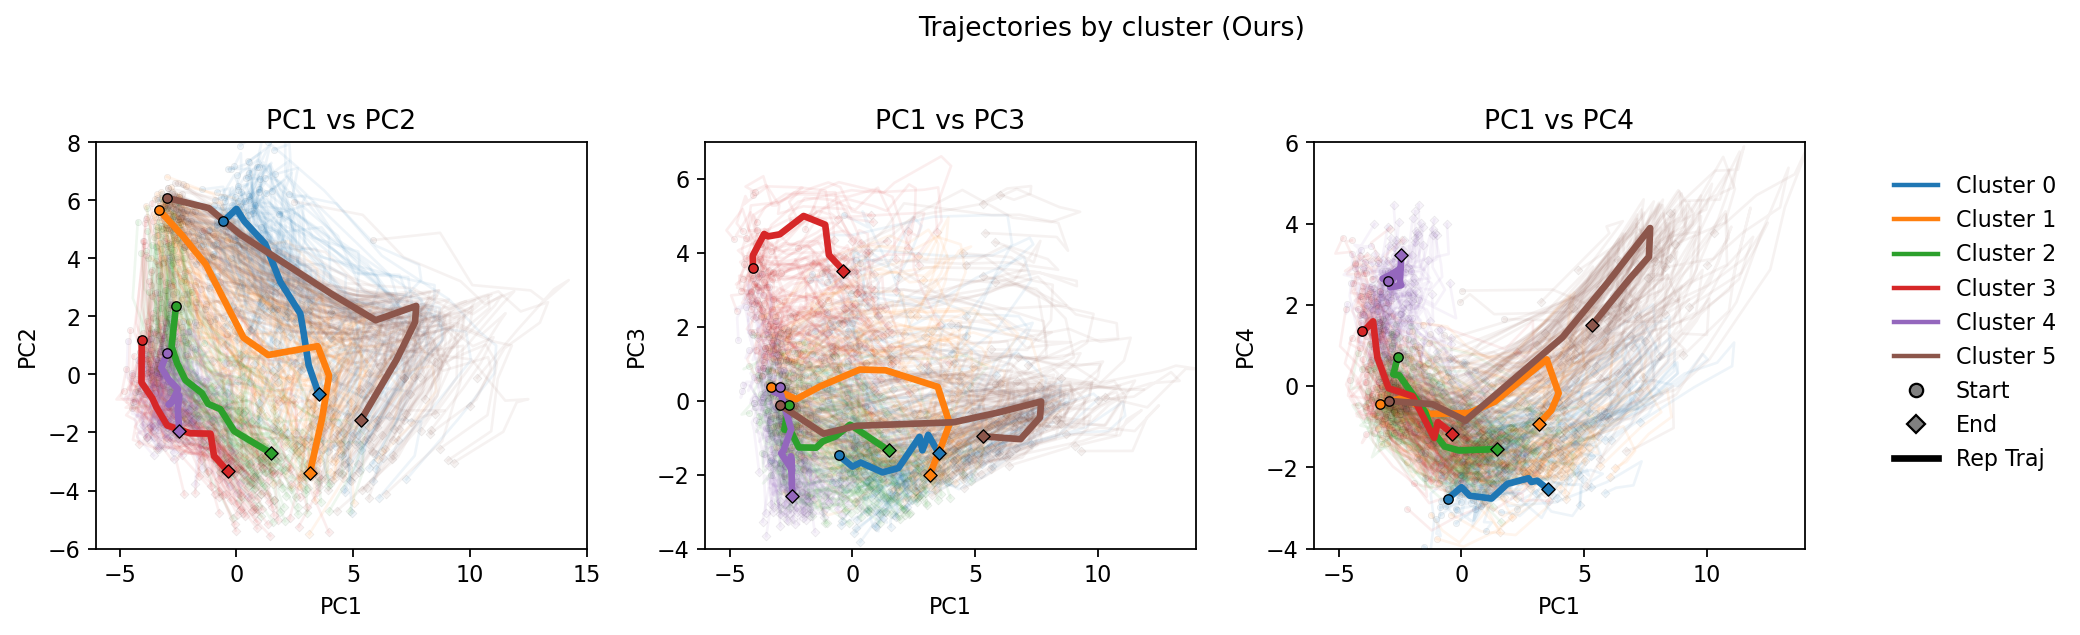

In [33]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_reg, lab_reg_km, DM_reg,
    title = "Trajectories by cluster (Ours)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)


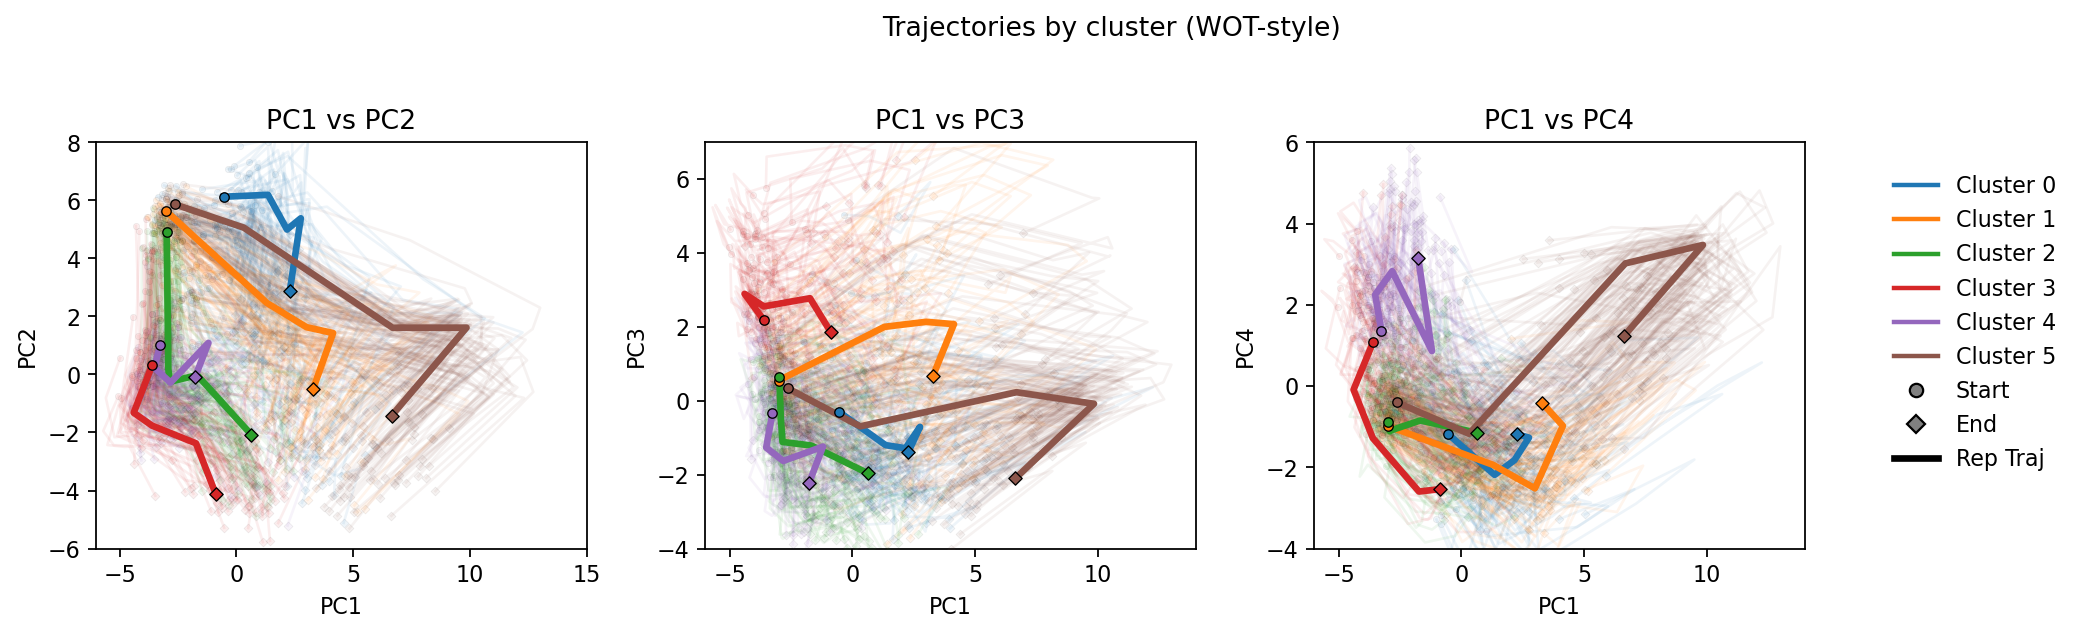

In [34]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_direct, aligned_dir, DM_direct,
    title = "Trajectories by cluster (WOT-style)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)

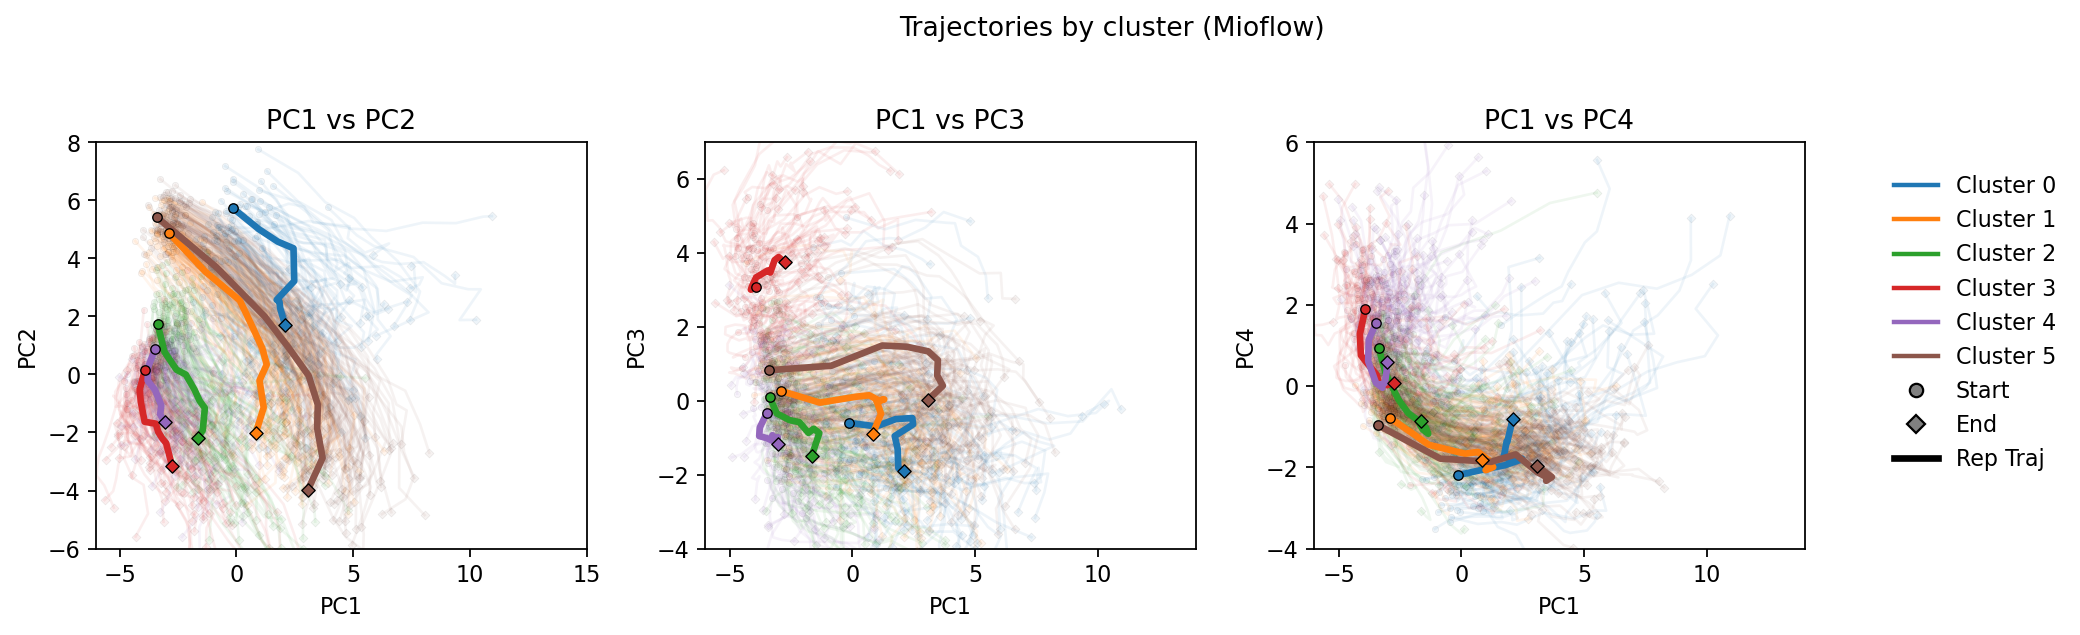

In [35]:
# traj: (T,N,D), labels: (N,), DM: (N,N)
medoids = plot_clusters_1x3_from_pcs_with_medoids(
    traj_mioflow, aligned_mioflow, DM_mioflow,
    title="Trajectories by cluster (Mioflow)",
    per_cluster_max=100,      # optional cap for readability
    alpha_all=0.075,           # all trajectories have alpha 0.15
    s_markers=True            # show start/end markers
)

### DE analysis for initial points

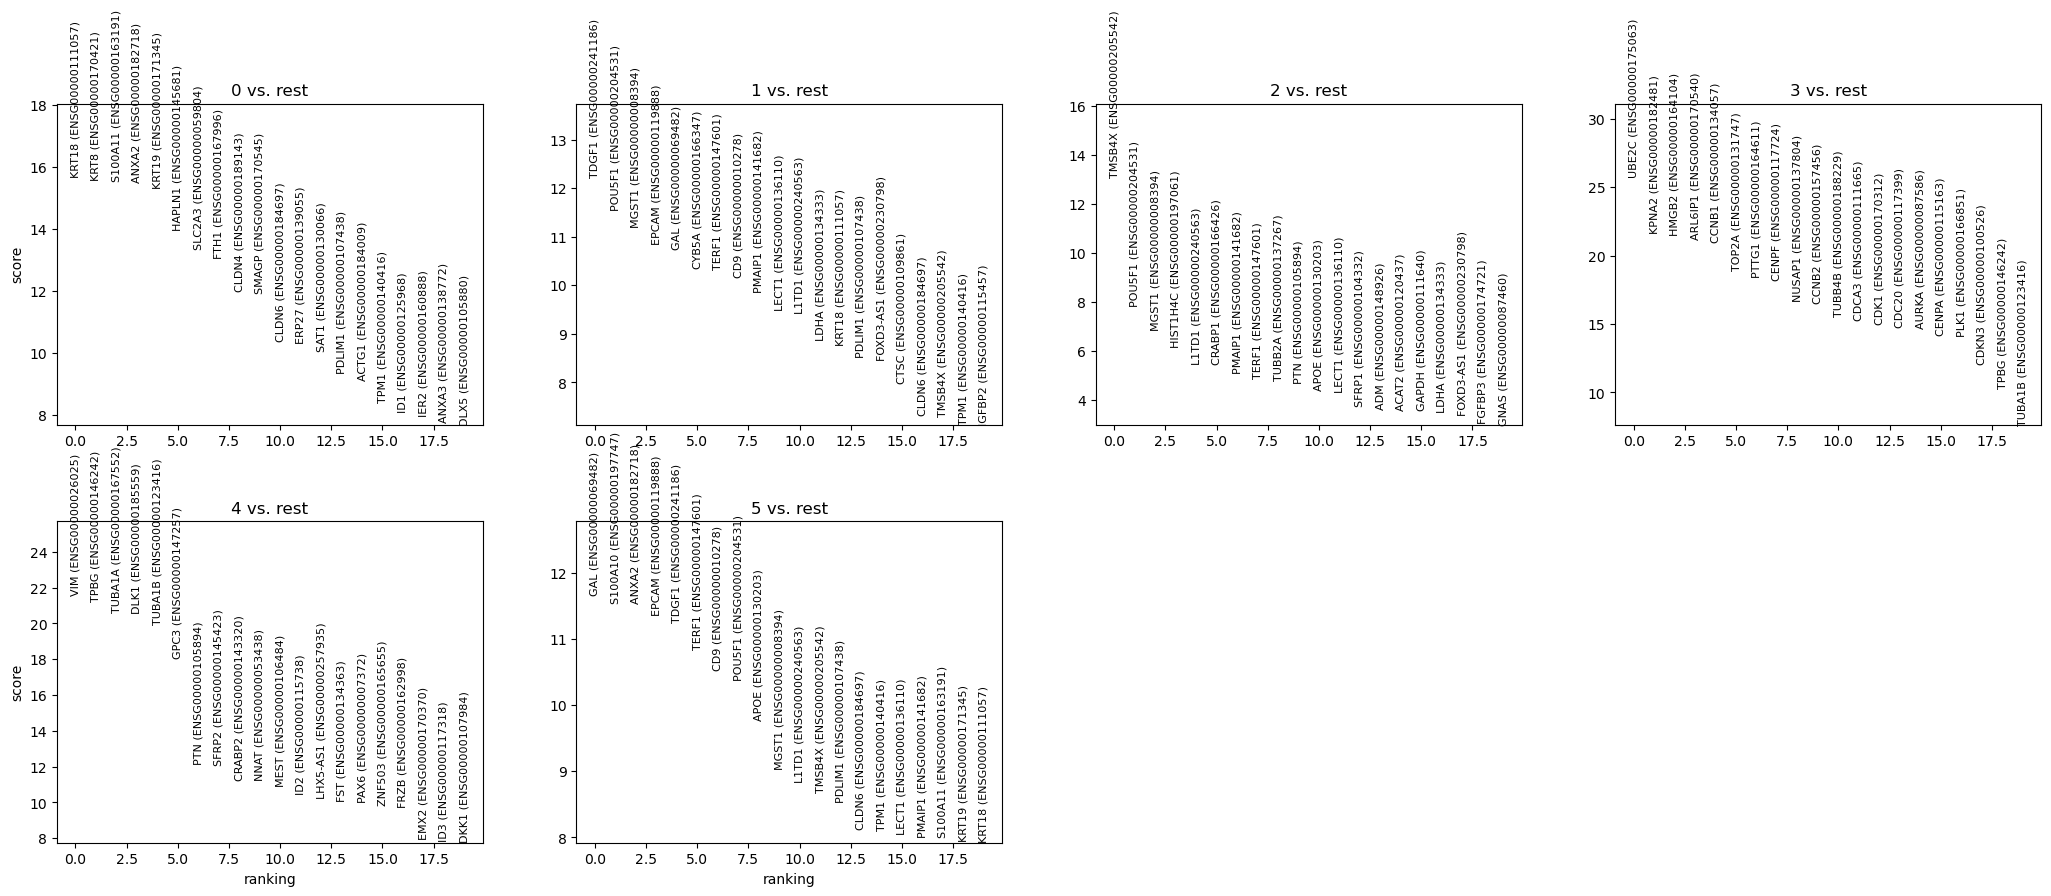

In [36]:
import scanpy as sc
import numpy as np

# Step 1: Subset AnnData to only 'Day 00-03'
adata_reg = embryoid[embryoid.obs['time'] == 'Day 00-03'].copy()

# Step 2: Add predicted cluster labels as obs column
# Make sure the number of predictions matches number of cells
assert adata_reg.shape[0] == len(lab_reg_km), "Mismatch between prediction and cell count"

# Add logistic regression cluster labels (0/1) to metadata
adata_reg.obs['traj_group'] = lab_reg_km.astype(str)  # Convert to string for categorical use

# Step 3: Run Scanpy signature gene discovery
sc.tl.rank_genes_groups(adata_reg, groupby='traj_group', method='wilcoxon')

# Step 4: Optional — visualize top genes
sc.pl.rank_genes_groups(adata_reg, n_genes=20, sharey=False)


In [38]:
import pandas as pd
import scanpy as sc

# long-form table with columns: group, names, scores, logfoldchanges, pvals, pvals_adj
df = sc.get.rank_genes_groups_df(adata_reg, group=None)  # key="rank_genes_groups" by default
print(df.head(10))  # peek

# Top 20 per group (print)
topN = 10
for g, sub in df.sort_values(["group","scores"], ascending=[True, False]).groupby("group"):
    print(f"\n=== {g} vs rest — top {topN} ===")
    print(sub.head(topN)[["names","scores","logfoldchanges","pvals_adj"]].to_string(index=False))

# (optional) save all results
# df.to_csv("rank_genes_groups_all.csv", index=False)

  group                      names     scores  logfoldchanges         pvals  \
0     0    KRT18 (ENSG00000111057)  15.655787        2.585157  3.033379e-55   
1     0     KRT8 (ENSG00000170421)  15.567639        3.006119  1.207826e-54   
2     0  S100A11 (ENSG00000163191)  15.533628        3.783613  2.054199e-54   
3     0    ANXA2 (ENSG00000182718)  15.490561        3.456786  4.017679e-54   
4     0    KRT19 (ENSG00000171345)  15.318024        3.187286  5.795312e-53   
5     0   HAPLN1 (ENSG00000145681)  13.962072        4.550554  2.655955e-44   
6     0   SLC2A3 (ENSG00000059804)  13.346451        2.410979  1.242276e-40   
7     0     FTH1 (ENSG00000167996)  13.042230        1.067003  7.036896e-39   
8     0    CLDN4 (ENSG00000189143)  11.982316        3.759926  4.398594e-33   
9     0    SMAGP (ENSG00000170545)  11.934016        3.405695  7.868338e-33   

      pvals_adj  
0  3.033379e-52  
1  6.039128e-52  
2  6.847329e-52  
3  1.004420e-51  
4  1.159062e-50  
5  4.426592e-42  
6  1

### Checking the ending points

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data from AnnData
X_pca = embryoid.obsm["X_pca"]
print(X_pca.shape)
PCs = embryoid.varm["PCs"]  # shape: (n_genes, n_pcs)

# Define genes of interest (you can modify these)
# If it's a sparse matrix, convert row means safely
if hasattr(embryoid.X, "toarray"):
    gene_means = embryoid.X.mean(axis=0).A1  # A1 converts to flat array
else:
    gene_means = embryoid.X.mean(axis=0)

# Reconstruct expression (approximation)
X_reconstructed = X_pca @ PCs.T + gene_means
print(X_reconstructed.shape)

(16821, 50)
(16821, 1000)


In [40]:
import numpy as np

# ---- inputs ----
# traj_pc: (T, N, 20) = your trajectories in PC space (first 20 PCs)
traj_pc = traj_reg   # rename if needed; shape should be (9, N, 20)

# ---- get the PCA pieces from AnnData ----
# PCs loadings: (n_genes, n_pcs); take first 20 columns to match traj_pc
PCs_full = embryoid.varm["PCs"]            # (G, 50) in your case
PCs20 = PCs_full[:, :20]                   # (G, 20)

# gene means (same pre-processing as used for PCA: Scanpy PCA centers genes)
if hasattr(embryoid.X, "toarray"):
    gene_means = embryoid.X.mean(axis=0).A1   # (G,)
else:
    gene_means = np.asarray(embryoid.X.mean(axis=0)).ravel()  # (G,)

G = PCs20.shape[0]
T, N, P = traj_pc.shape
assert P == PCs20.shape[1], "PC count in trajectory must match the columns taken from PCs."

# ---- map back to gene space ----
# Flatten over time * cells, multiply by loadings, then reshape back
traj_flat = traj_pc.reshape(T * N, P)           # (T*N, 20)
X_gene_flat = traj_flat @ PCs20.T               # (T*N, G)
X_gene_flat += gene_means[None, :]              # add gene means (broadcast)

traj_gene = X_gene_flat.reshape(T, N, G)        # (T, N, G)

print("Traj in gene space:", traj_gene.shape)   # expected: (9, N, G)

# ---- keep exactly 1,000 genes if you want (choose HVGs if available) ----
if "highly_variable" in embryoid.var and embryoid.var["highly_variable"].sum() >= 1000:
    idx_1000 = np.where(embryoid.var["highly_variable"].values)[0][:1000]
else:
    idx_1000 = np.arange(min(1000, G))

traj_gene_1000 = traj_gene[:, :, idx_1000]      # (9, N, 1000)
gene_names_1000 = embryoid.var_names[idx_1000].to_numpy()

print("Traj in gene space (1000 genes):", traj_gene_1000.shape)
# Now traj_gene_1000 is ready for gene-level analyses/plots; gene_names_1000 gives the labels.


Traj in gene space: (9, 2381, 1000)
Traj in gene space (1000 genes): (9, 2381, 1000)


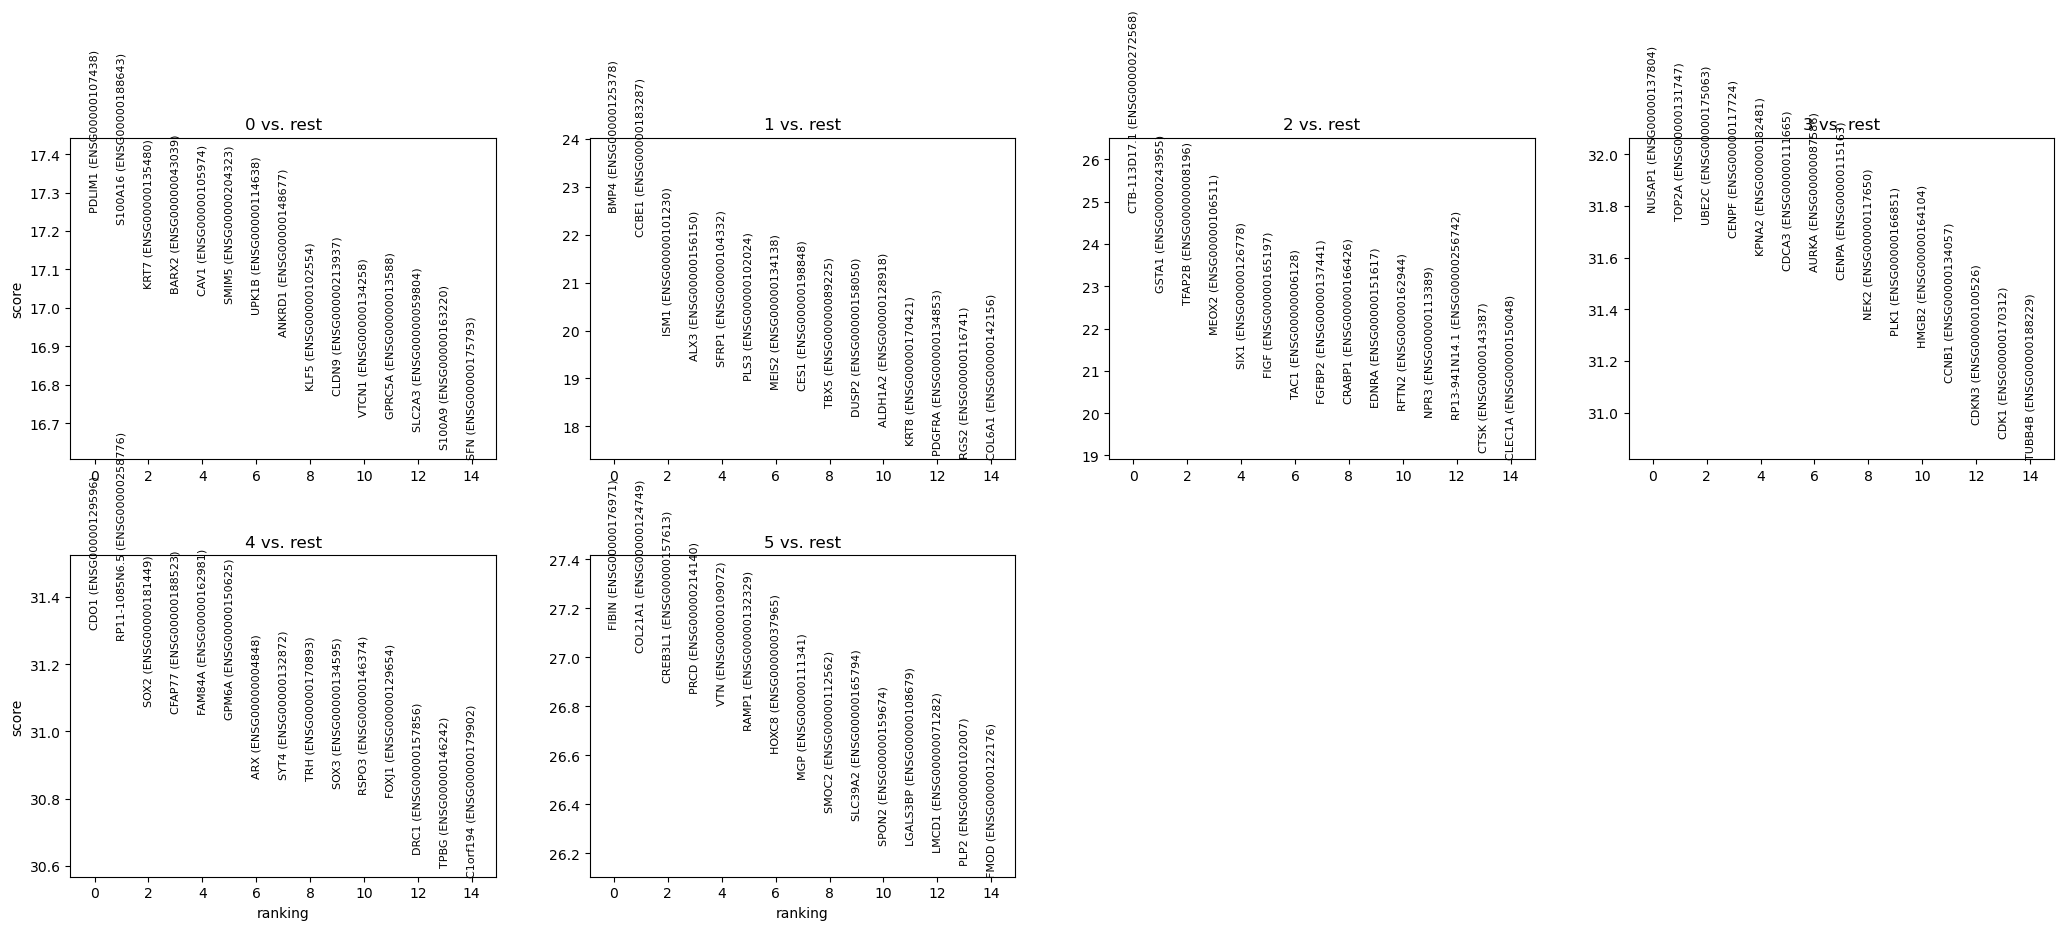

  group                      names     scores  logfoldchanges         pvals  \
0     0   PDLIM1 (ENSG00000107438)  17.250151        2.914930  1.116074e-66   
1     0  S100A16 (ENSG00000188643)  17.218487        2.886921  1.929646e-66   
2     0     KRT7 (ENSG00000135480)  17.051584             NaN  3.401822e-65   
3     0    BARX2 (ENSG00000043039)  17.037230        5.235250  4.348512e-65   
4     0     CAV1 (ENSG00000105974)  17.032936        3.489219  4.679639e-65   

      pvals_adj  
0  9.648228e-64  
1  9.648228e-64  
2  9.359278e-63  
3  9.359278e-63  
4  9.359278e-63  

=== 0 vs rest — top 40 genes (last step) ===
                     names    scores  logfoldchanges    pvals_adj
  PDLIM1 (ENSG00000107438) 17.250151        2.914930 9.648228e-64
 S100A16 (ENSG00000188643) 17.218487        2.886921 9.648228e-64
    KRT7 (ENSG00000135480) 17.051584             NaN 9.359278e-63
   BARX2 (ENSG00000043039) 17.037230        5.235250 9.359278e-63
    CAV1 (ENSG00000105974) 17.032936     

In [41]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

# ----- inputs you already have -----
# embryoid: AnnData of the full dataset
# traj_gene_1000: (9, N, 1000) gene-space trajectories (last step index = 8)
# lab_reg_km: (N,) cluster labels for Day 00-03 cells
# gene_names_1000: (1000,) array of gene names used in traj_gene_1000

# 1) Grab the Day 00-03 cells to keep indices/labels aligned
adata_day0 = embryoid[embryoid.obs['time'] == 'Day 00-03'].copy()

# Sanity checks
N_day0 = adata_day0.n_obs
assert traj_gene_1000.shape[1] == N_day0, \
    f"N mismatch: traj has {traj_gene_1000.shape[1]}, Day0 has {N_day0}"
assert len(lab_reg_km) == N_day0, \
    f"Label length mismatch: {len(lab_reg_km)} vs {N_day0}"

# 2) Build AnnData from the last time point (T=8) of your trajectories
X_last = traj_gene_1000[8, :, :]              # shape (N, 1000)
X_last = X_last.astype(np.float32, copy=False)

# IMPORTANT: var names must match the columns of X_last.
# Use the same 1000 genes you selected when building traj_gene_1000.
var_names = pd.Index(gene_names_1000, name="gene")  # length 1000

adata_traj_last = ad.AnnData(
    X=X_last,
    obs=pd.DataFrame(index=adata_day0.obs_names.copy()),
    var=pd.DataFrame(index=var_names)
)

# 3) Add the same group labels you used before
adata_traj_last.obs['traj_group'] = pd.Categorical(lab_reg_km.astype(str))

# 4) Run DE (Wilcoxon) on the reconstructed last-step expressions
sc.tl.rank_genes_groups(adata_traj_last, groupby='traj_group', method='wilcoxon')

# Step 4: Optional — visualize top genes
sc.pl.rank_genes_groups(adata_traj_last, n_genes=15, sharey=False)

# 5) (Optional) Inspect / export results as a table instead of a figure
df_last = sc.get.rank_genes_groups_df(adata_traj_last, group=None)
print(df_last.head())

# Example: print top 15 per group
topN = 40
for g, sub in df_last.sort_values(["group","scores"], ascending=[True, False]).groupby("group"):
    print(f"\n=== {g} vs rest — top {topN} genes (last step) ===")
    print(sub.head(topN)[["names","scores","logfoldchanges","pvals_adj"]].to_string(index=False))

# (Optional) save to CSV
# df_last.to_csv("de_last_step_traj_gene_1000.csv", index=False)


### Biological analysis of each trajecctories/ending cells

### Discovering trajectories difference

We hope to analyze each gene by a LMM model, accounting for the longitudinal correlation (make inference on population level metrics):
 - It's better to focus on marker genes & genes with relative larger abundance
 - what patterns do we want to see? How to detect? How to intepret?

In [ ]:
# import h5py
# import numpy as np

# # Your objects
# # traj_reg: ndarray of shape (9, N, 1000)
# # lab_reg_km: list length 1000 (e.g., per-gene labels)
# # embryoid.var.index: Pandas Index of gene names

# # 1) Ensure proper dtypes
# traj_reg_to_save = np.asarray(traj_gene_1000, dtype=np.float32)  # smaller file, safe
# gene_names = embryoid.var.index.tolist()                   # convert Index -> list

# lab_arr = np.asarray(lab_reg_km, dtype=np.float32)

# save_path = "/Path/to/your/folder"
# # 2) Write HDF5
# with h5py.File(save_path+"/traj_bundle.h5", "w") as f:
#     f.create_dataset("traj_reg", data=traj_reg_to_save, compression="gzip")

#     # gene_names as UTF-8 variable-length strings
#     str_dt = h5py.string_dtype(encoding="utf-8")
#     f.create_dataset("gene_names", data=np.asarray(gene_names, dtype=object), dtype=str_dt)

#     f.create_dataset("lab_reg_km", data=np.asarray(lab_reg_km))

### Marker genes visualization (LMM)

In [42]:
import json, pandas as pd, numpy as np
import matplotlib.pyplot as plt

def load_viz_payload(json_path):
    with open(json_path, "r") as f:
        payload = json.load(f)
    df_summ  = pd.DataFrame(payload["df_summ"])
    fe_line  = pd.DataFrame(payload["fe_line"])
    breaks   = pd.DataFrame(payload["breaks"]) if len(payload["breaks"]) else pd.DataFrame(columns=["cluster","tau_time"])
    for df in (df_summ, fe_line, breaks):
        if "cluster" in df.columns:
            df["cluster"] = df["cluster"].astype(int)
    return payload["gene"], df_summ, fe_line, breaks

def color_by_cluster(clusters):
    """Fixed mapping: tab10 indexed by the *cluster id* (0→tab10[0], 1→tab10[1], …)."""
    cmap = plt.get_cmap("tab10")
    return {int(c): cmap(int(c) % 10) for c in clusters}


In [43]:
def plot_lmm_1x3(json_paths, genenames, title="Per-cluster chosen models",
                 cluster_alphas=None):
    """
    json_paths: list[str] of length 3 (one JSON per panel)
    genenames : list[str] of length 3 (titles per panel)
    cluster_alphas: list/tuple of length 6 giving alpha for clusters 0..5.
                    If None, defaults to 1.0 for all clusters.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    assert len(json_paths) == 3 and len(genenames) == 3

    # Build color map from the first pane's clusters
    _, df0, _, _ = load_viz_payload(json_paths[0])
    uniq = np.sort(df0["cluster"].unique())
    colors = color_by_cluster(uniq)

    # Build alpha map (cluster id -> alpha)
    if cluster_alphas is None:
        alpha_map = {int(c): 1.0 for c in uniq}
    else:
        if len(cluster_alphas) != 6:
            raise ValueError("cluster_alphas must be length 6 for clusters 0..5.")
        # clamp to [0,1]
        cluster_alphas = [max(0.0, min(1.0, float(a))) for a in cluster_alphas]
        alpha_map = {int(c): cluster_alphas[int(c)] for c in uniq}

    fig, axes = plt.subplots(1, 3, figsize=(14, 4), dpi=160)
    axes = np.ravel(axes)

    for ax, jp, gtitle in zip(axes, json_paths, genenames):
        _, df_summ, fe_line, breaks = load_viz_payload(jp)

        for c in np.sort(df_summ["cluster"].unique()):
            col   = colors[int(c)]
            a_c   = alpha_map[int(c)]
            dmu   = df_summ[df_summ["cluster"] == c]
            dfe   = fe_line[fe_line["cluster"] == c]
            dbk   = breaks[breaks["cluster"] == c] if len(breaks) else pd.DataFrame(columns=["tau_time"])

            # Solid mean±SE + points
            ax.plot(dmu["time_orig"], dmu["mu"], color=col, linewidth=0.9, alpha=a_c)
            ax.scatter(dmu["time_orig"], dmu["mu"], color=col, s=14, zorder=3, alpha=a_c)
            ax.errorbar(dmu["time_orig"], dmu["mu"], yerr=dmu["se"],
                        fmt="none", ecolor=col, elinewidth=0.9,
                        alpha=min(a_c, 0.85), capsize=2)

            # Dashed FE line
            ax.plot(dfe["time_orig"], dfe["pred"], color=col, linewidth=1.1,
                    linestyle="--", alpha=a_c)

            # Dotted break lines (if any)
            if len(dbk):
                for x0 in np.unique(dbk["tau_time"]):
                    ax.axvline(x=x0, color=col, linestyle=":", linewidth=1.0,
                               alpha=min(a_c, 0.55))

        ax.set_title(gtitle)
        ax.set_xlabel("Days")
        ax.set_ylabel("Expression")
        ax.grid(False)

    # --- Single combined legend on the RIGHT ---
    cluster_handles = [
        plt.Line2D([0],[0], color=colors[int(c)], lw=2, label=f"Cluster {int(c)}")
        for c in uniq
    ]
    style_handles = [
        plt.Line2D([0],[0], color="k", lw=1.6, linestyle="-",  label="Mean data"),
        plt.Line2D([0],[0], color="k", lw=1.6, linestyle="--", label="LMM"),
        # plt.Line2D([0],[0], color="k", lw=1.2, linestyle=":",  label="Breakpoint"),
    ]
    handles = cluster_handles + style_handles

    plt.subplots_adjust(right=0.82)  # leave room on the right
    fig.legend(handles=handles, loc="center left", bbox_to_anchor=(0.84, 0.5),
               frameon=False, ncol=1)

    fig.suptitle(title, y=0.98)
    plt.tight_layout(rect=[0, 0.0, 0.82, 0.95])
    plt.show()


### CLuster 1 & 5

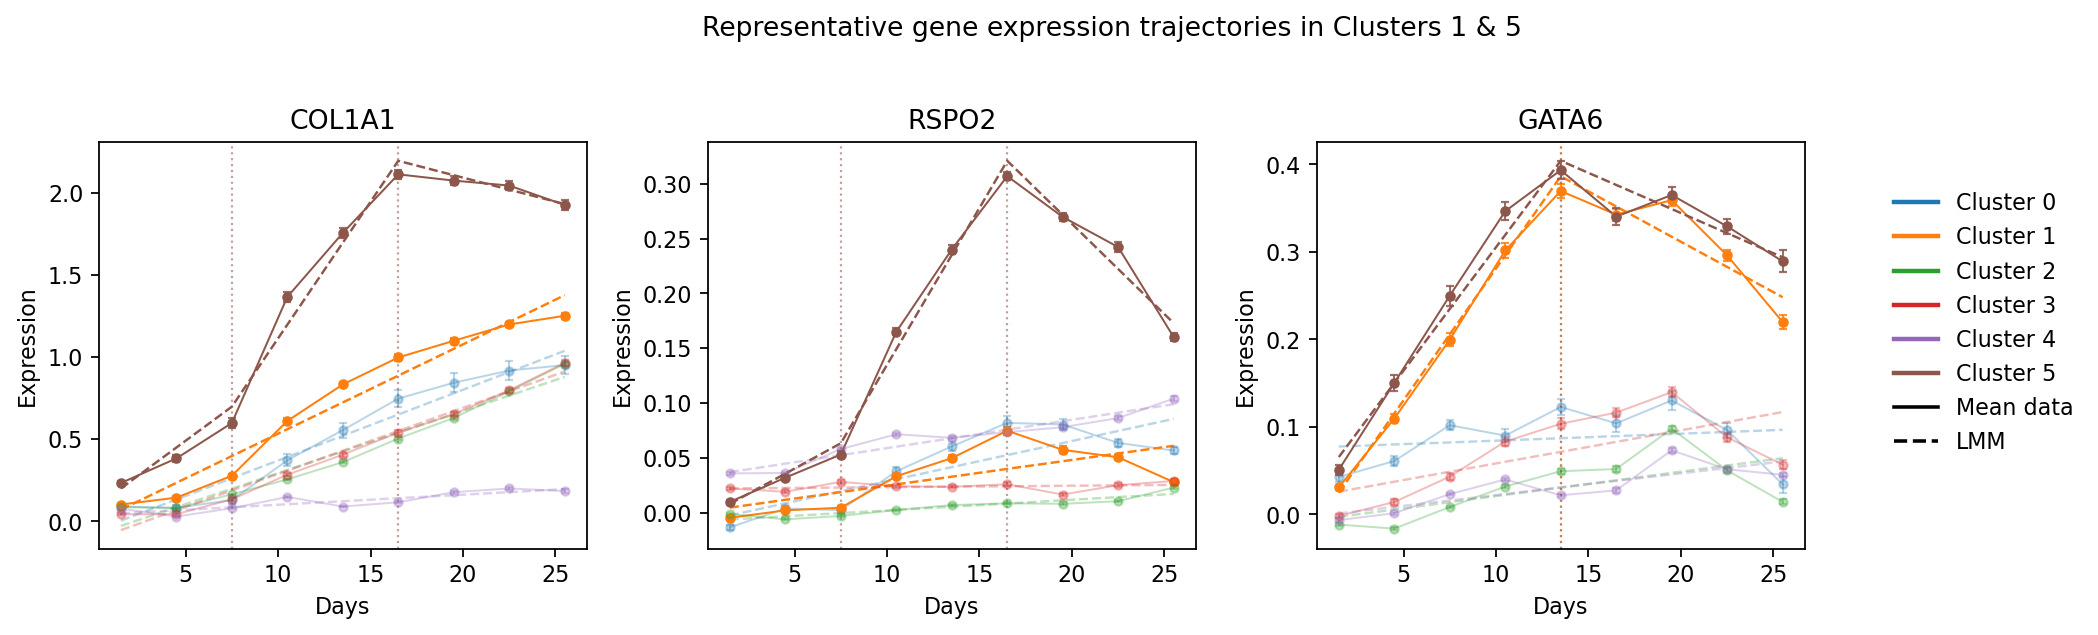

In [44]:
# ----- Example usage (repeat the same gene three times to preview style) -----

alphas = [0.3, 1, 0.3, 0.3, 0.3, 1]
genenames = ["COL1A1", "RSPO2", "GATA6"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/COL1A1_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/RSPO2_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/GATA6_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories in Clusters 1 & 5", cluster_alphas=alphas)

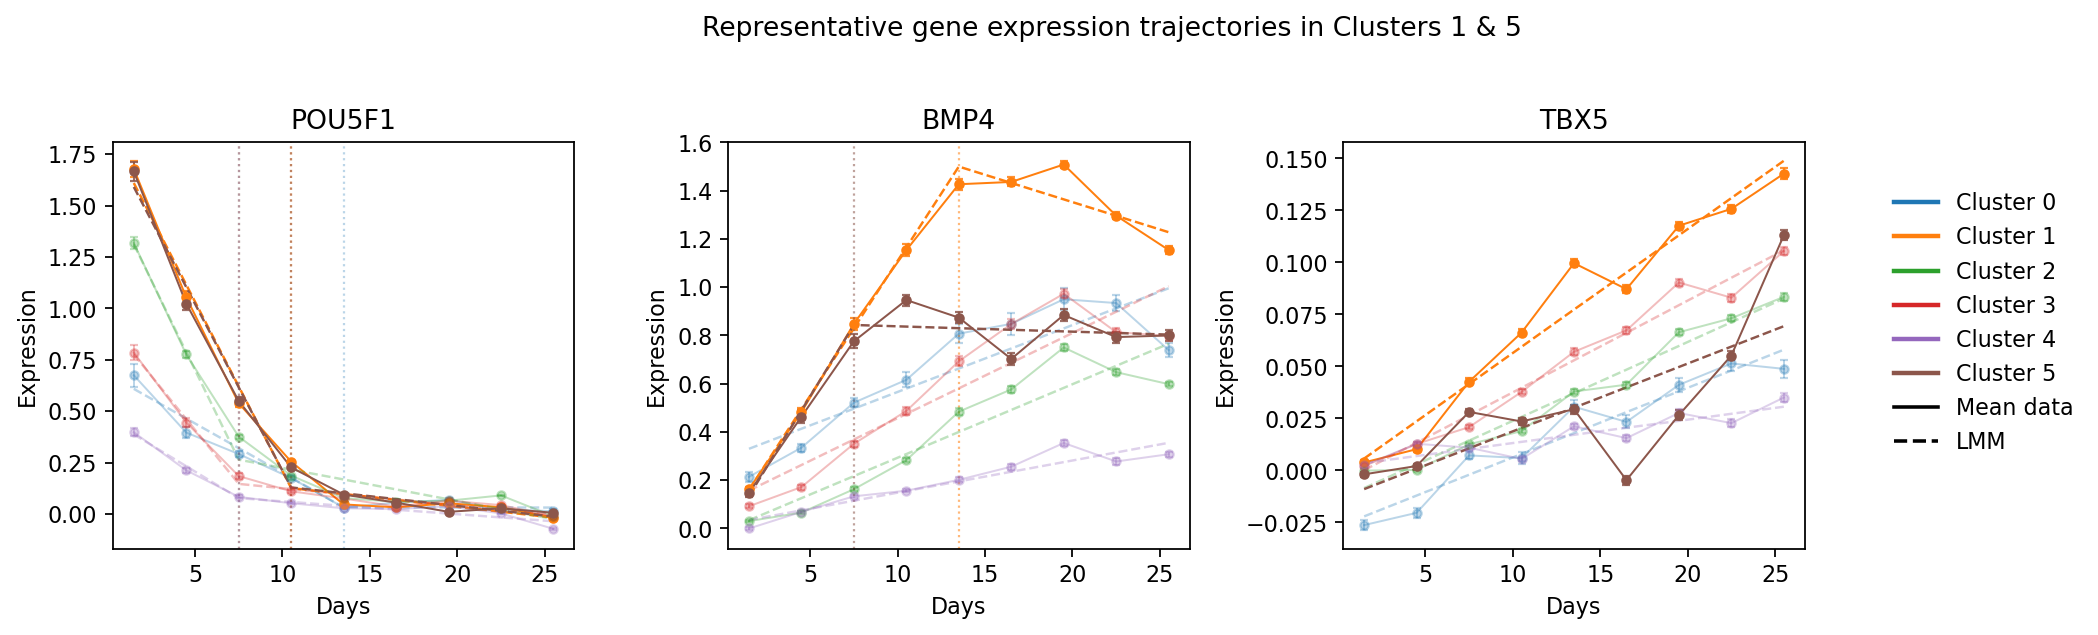

In [45]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [0.3, 1, 0.3, 0.3, 0.3, 1]
genenames = ["POU5F1", "BMP4", "TBX5"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/POU5F1_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/BMP4_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/TBX5_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories in Clusters 1 & 5", cluster_alphas=alphas)

### CLuster 2 & 4

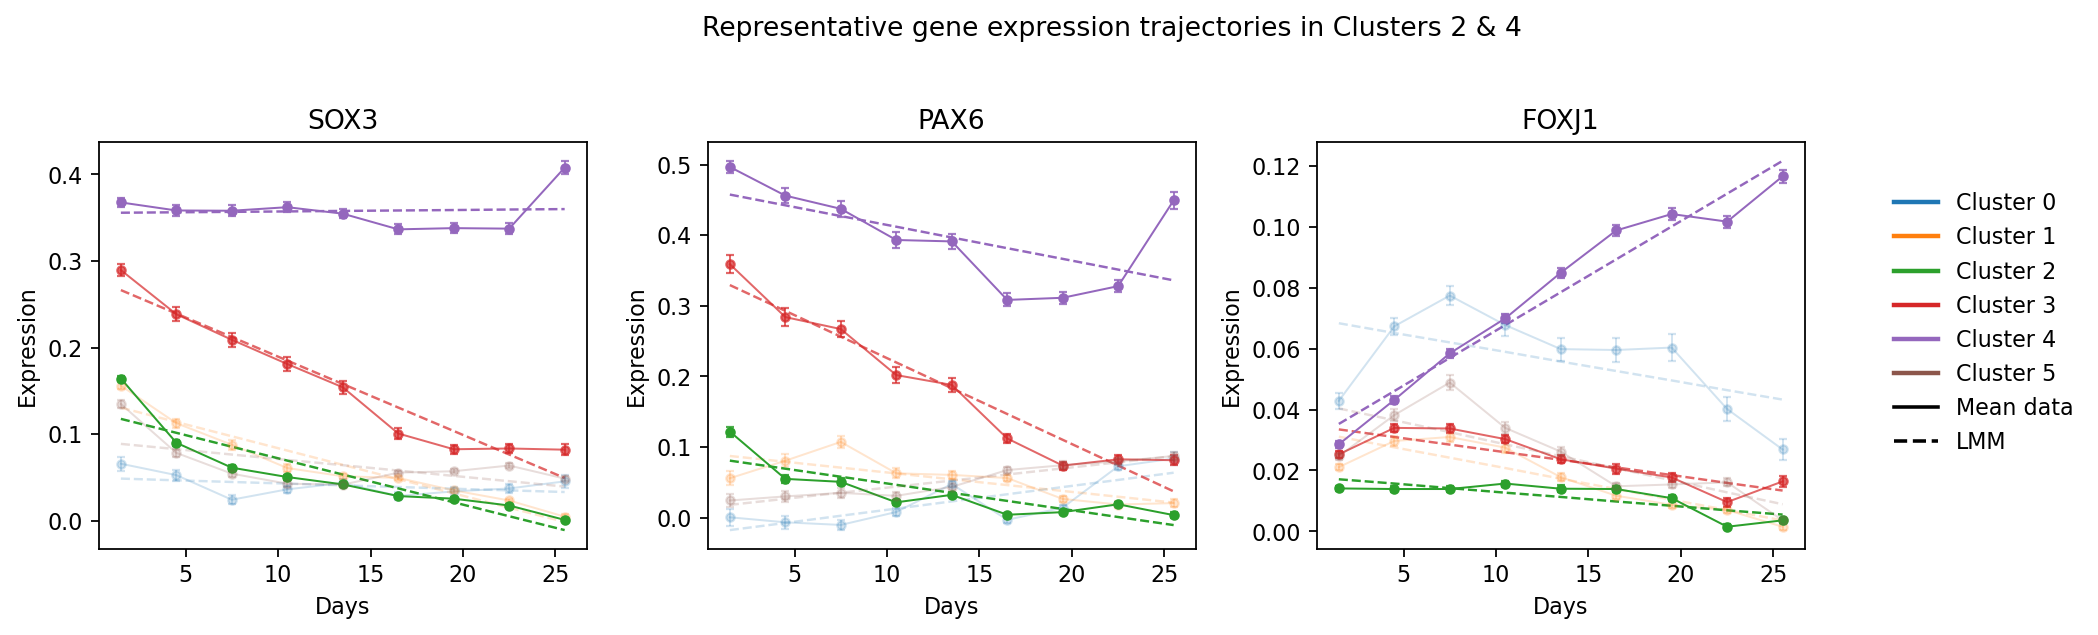

In [46]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [0.2, 0.2, 1, 0.7, 1, 0.2]
genenames = ["SOX3", "PAX6", "FOXJ1"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/SOX3_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/PAX6_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/FOXJ1_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories in Clusters 2 & 4", cluster_alphas=alphas)

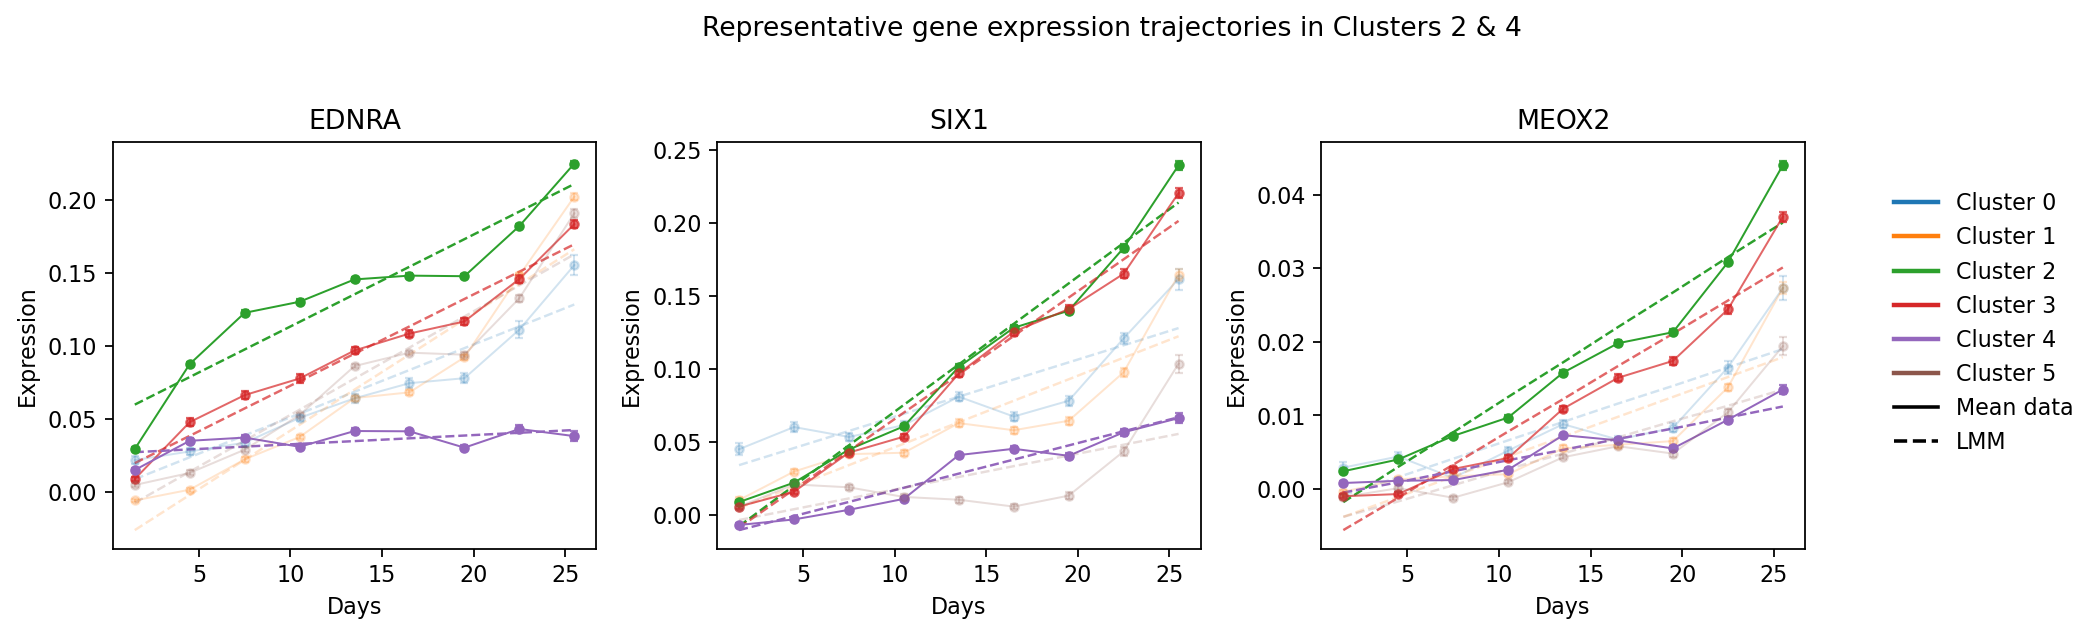

In [47]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [0.2, 0.2, 1, 0.7, 1, 0.2]
genenames = ["EDNRA", "SIX1", "MEOX2"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/EDNRA_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/SIX1_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/MEOX2_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories in Clusters 2 & 4", cluster_alphas=alphas)

### CLuster 0

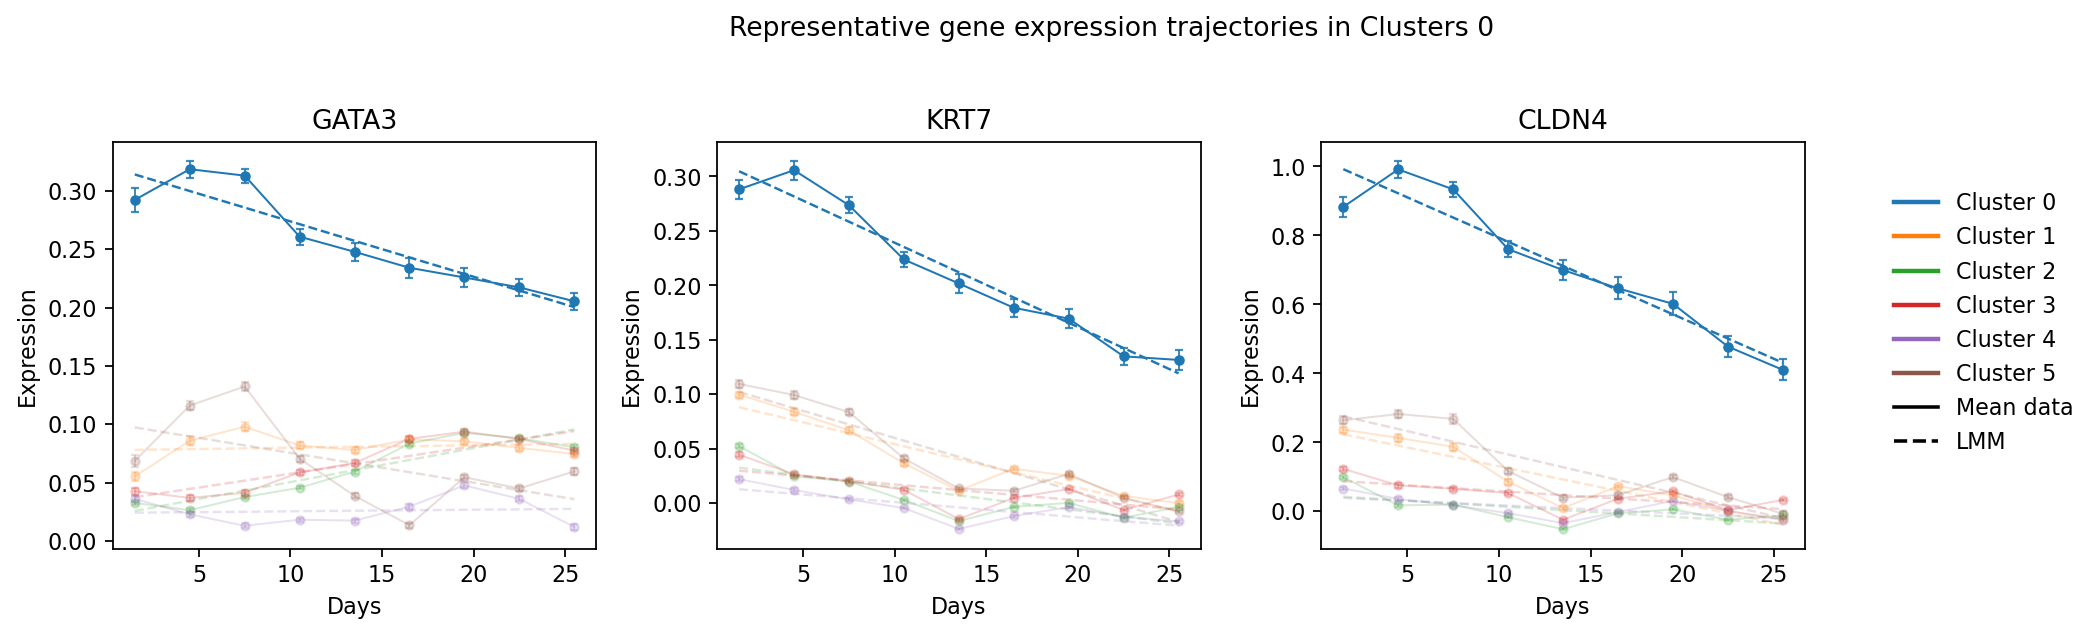

In [48]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [1, 0.2, 0.2, 0.2, 0.2, 0.2]
genenames = ["GATA3", "KRT7", "CLDN4"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/GATA3_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/KRT7_lmm_viz.json",
              result_folder+"results/dynamics/embryoid/LMM/CLDN4_lmm_viz.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories in Clusters 0", cluster_alphas=alphas)

## Saving trajectories & clustering for two other methods

In [ ]:
# import numpy as np

# # ---- inputs ----
# # traj_pc: (T, N, 20) = your trajectories in PC space (first 20 PCs)
# traj_pc = traj_direct  # rename if needed; shape should be (9, N, 20)

# # ---- get the PCA pieces from AnnData ----
# # PCs loadings: (n_genes, n_pcs); take first 20 columns to match traj_pc
# PCs_full = embryoid.varm["PCs"]            # (G, 50) in your case
# PCs20 = PCs_full[:, :20]                   # (G, 20)

# # gene means (same pre-processing as used for PCA: Scanpy PCA centers genes)
# if hasattr(embryoid.X, "toarray"):
#     gene_means = embryoid.X.mean(axis=0).A1   # (G,)
# else:
#     gene_means = np.asarray(embryoid.X.mean(axis=0)).ravel()  # (G,)

# G = PCs20.shape[0]
# T, N, P = traj_pc.shape
# assert P == PCs20.shape[1], "PC count in trajectory must match the columns taken from PCs."

# # ---- map back to gene space ----
# # Flatten over time * cells, multiply by loadings, then reshape back
# traj_flat = traj_pc.reshape(T * N, P)           # (T*N, 20)
# X_gene_flat = traj_flat @ PCs20.T               # (T*N, G)
# X_gene_flat += gene_means[None, :]              # add gene means (broadcast)

# traj_gene = X_gene_flat.reshape(T, N, G)        # (T, N, G)

# print("Traj in gene space:", traj_gene.shape)   # expected: (9, N, G)

# # ---- keep exactly 1,000 genes if you want (choose HVGs if available) ----
# if "highly_variable" in embryoid.var and embryoid.var["highly_variable"].sum() >= 1000:
#     idx_1000 = np.where(embryoid.var["highly_variable"].values)[0][:1000]
# else:
#     idx_1000 = np.arange(min(1000, G))

# traj_gene_1000_dir = traj_gene[:, :, idx_1000]      # (9, N, 1000)
# gene_names_1000 = embryoid.var_names[idx_1000].to_numpy()

# print("Traj in gene space (1000 genes):", traj_gene_1000_dir.shape)
# # Now traj_gene_1000 is ready for gene-level analyses/plots; gene_names_1000 gives the labels.


Traj in gene space: (5, 2381, 1000)
Traj in gene space (1000 genes): (5, 2381, 1000)


In [ ]:
# import h5py
# import numpy as np

# # Your objects
# # traj_reg: ndarray of shape (9, N, 1000)
# # lab_reg_km: list length 1000 (e.g., per-gene labels)
# # embryoid.var.index: Pandas Index of gene names

# # 1) Ensure proper dtypes
# traj_reg_to_save = np.asarray(traj_gene_1000_dir, dtype=np.float32)  # smaller file, safe
# gene_names = embryoid.var.index.tolist()                   # convert Index -> list

# lab_arr = np.asarray(aligned_dir, dtype=np.float32)

# save_path = "Path/to/your/folder"
# # 2) Write HDF5
# with h5py.File(save_path+"/traj_bundle_dir.h5", "w") as f:
#     f.create_dataset("traj_reg", data=traj_reg_to_save, compression="gzip")

#     # gene_names as UTF-8 variable-length strings
#     str_dt = h5py.string_dtype(encoding="utf-8")
#     f.create_dataset("gene_names", data=np.asarray(gene_names, dtype=object), dtype=str_dt)

#     f.create_dataset("lab_reg_km", data=np.asarray(lab_reg_km))

In [ ]:
# import numpy as np

# # ---- inputs ----
# # traj_pc: (T, N, 20) = your trajectories in PC space (first 20 PCs)
# traj_pc = traj_mioflow  # rename if needed; shape should be (9, N, 20)

# # ---- get the PCA pieces from AnnData ----
# # PCs loadings: (n_genes, n_pcs); take first 20 columns to match traj_pc
# PCs_full = embryoid.varm["PCs"]            # (G, 50) in your case
# PCs20 = PCs_full[:, :20]                   # (G, 20)

# # gene means (same pre-processing as used for PCA: Scanpy PCA centers genes)
# if hasattr(embryoid.X, "toarray"):
#     gene_means = embryoid.X.mean(axis=0).A1   # (G,)
# else:
#     gene_means = np.asarray(embryoid.X.mean(axis=0)).ravel()  # (G,)

# G = PCs20.shape[0]
# T, N, P = traj_pc.shape
# assert P == PCs20.shape[1], "PC count in trajectory must match the columns taken from PCs."

# # ---- map back to gene space ----
# # Flatten over time * cells, multiply by loadings, then reshape back
# traj_flat = traj_pc.reshape(T * N, P)           # (T*N, 20)
# X_gene_flat = traj_flat @ PCs20.T               # (T*N, G)
# X_gene_flat += gene_means[None, :]              # add gene means (broadcast)

# traj_gene = X_gene_flat.reshape(T, N, G)        # (T, N, G)

# print("Traj in gene space:", traj_gene.shape)   # expected: (9, N, G)

# # ---- keep exactly 1,000 genes if you want (choose HVGs if available) ----
# if "highly_variable" in embryoid.var and embryoid.var["highly_variable"].sum() >= 1000:
#     idx_1000 = np.where(embryoid.var["highly_variable"].values)[0][:1000]
# else:
#     idx_1000 = np.arange(min(1000, G))

# traj_gene_1000_mio = traj_gene[:, :, idx_1000]      # (9, N, 1000)
# gene_names_1000 = embryoid.var_names[idx_1000].to_numpy()

# print("Traj in gene space (1000 genes):", traj_gene_1000_mio.shape)
# # Now traj_gene_1000 is ready for gene-level analyses/plots; gene_names_1000 gives the labels.

Traj in gene space: (9, 2381, 1000)
Traj in gene space (1000 genes): (9, 2381, 1000)


In [ ]:
# import h5py
# import numpy as np

# # Your objects
# # traj_reg: ndarray of shape (9, N, 1000)
# # lab_reg_km: list length 1000 (e.g., per-gene labels)
# # embryoid.var.index: Pandas Index of gene names

# # 1) Ensure proper dtypes
# traj_reg_to_save = np.asarray(traj_gene_1000_mio, dtype=np.float32)  # smaller file, safe
# gene_names = embryoid.var.index.tolist()                   # convert Index -> list

# lab_arr = np.asarray(aligned_mioflow, dtype=np.float32)

# save_path = "Path/to/your/folder"
# # 2) Write HDF5
# with h5py.File(save_path+"/traj_bundle_mio.h5", "w") as f:
#     f.create_dataset("traj_reg", data=traj_reg_to_save, compression="gzip")

#     # gene_names as UTF-8 variable-length strings
#     str_dt = h5py.string_dtype(encoding="utf-8")
#     f.create_dataset("gene_names", data=np.asarray(gene_names, dtype=object), dtype=str_dt)

#     f.create_dataset("lab_reg_km", data=np.asarray(lab_reg_km))

### Marker genes visualization - other methods (LMM)

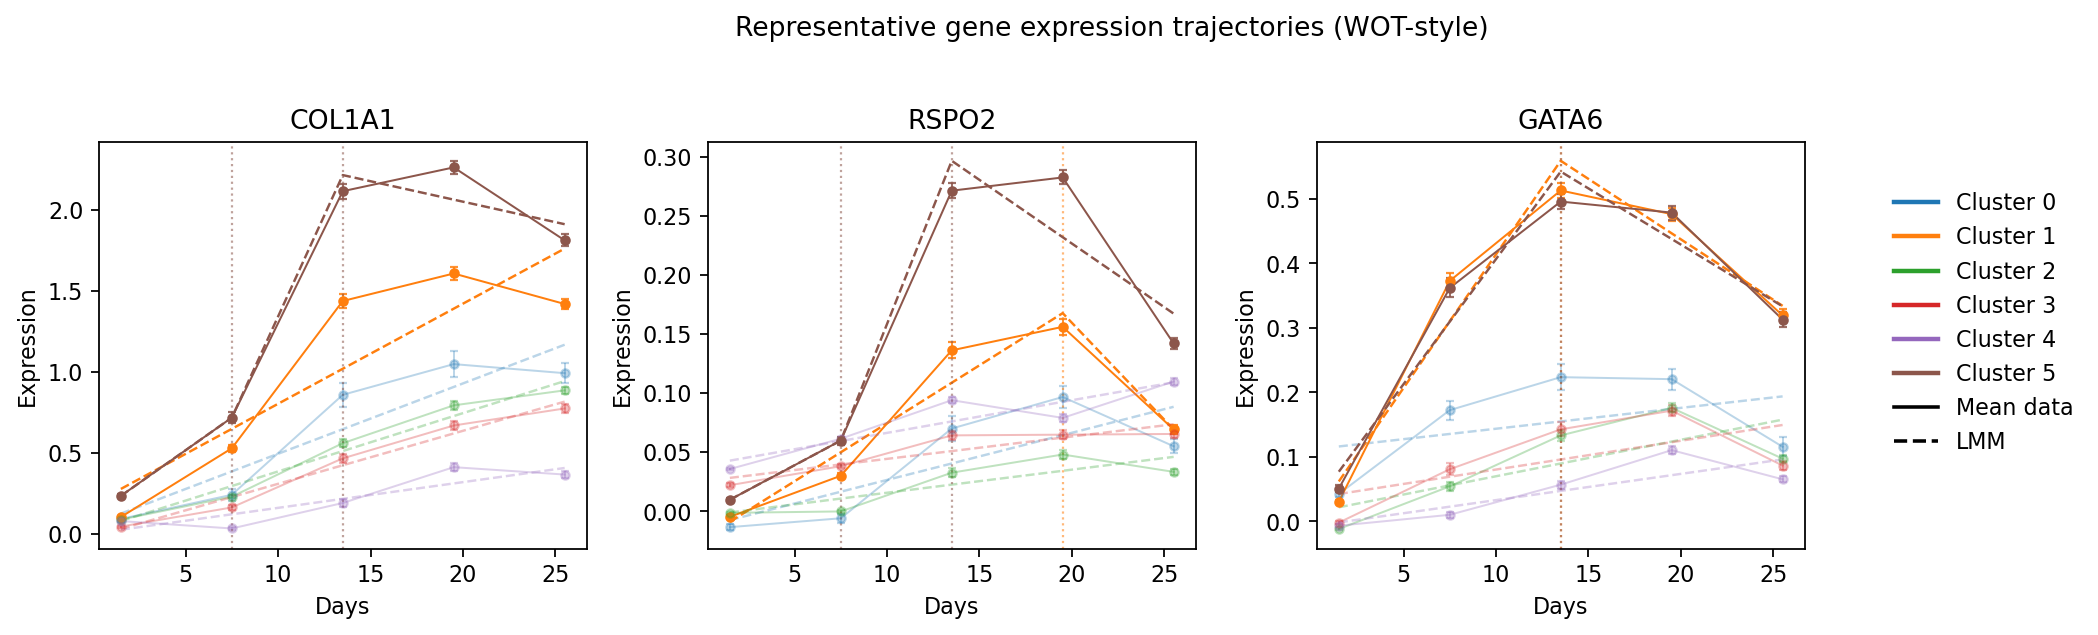

In [49]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [0.3, 1, 0.3, 0.3, 0.3, 1]
genenames = ["COL1A1", "RSPO2", "GATA6"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/dir/COL1A1_lmm_viz_dir.json",
              result_folder+"results/dynamics/embryoid/LMM/dir/RSPO2_lmm_viz_dir.json",
              result_folder+"results/dynamics/embryoid/LMM/dir/GATA6_lmm_viz_dir.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories (WOT-style)", cluster_alphas=alphas)

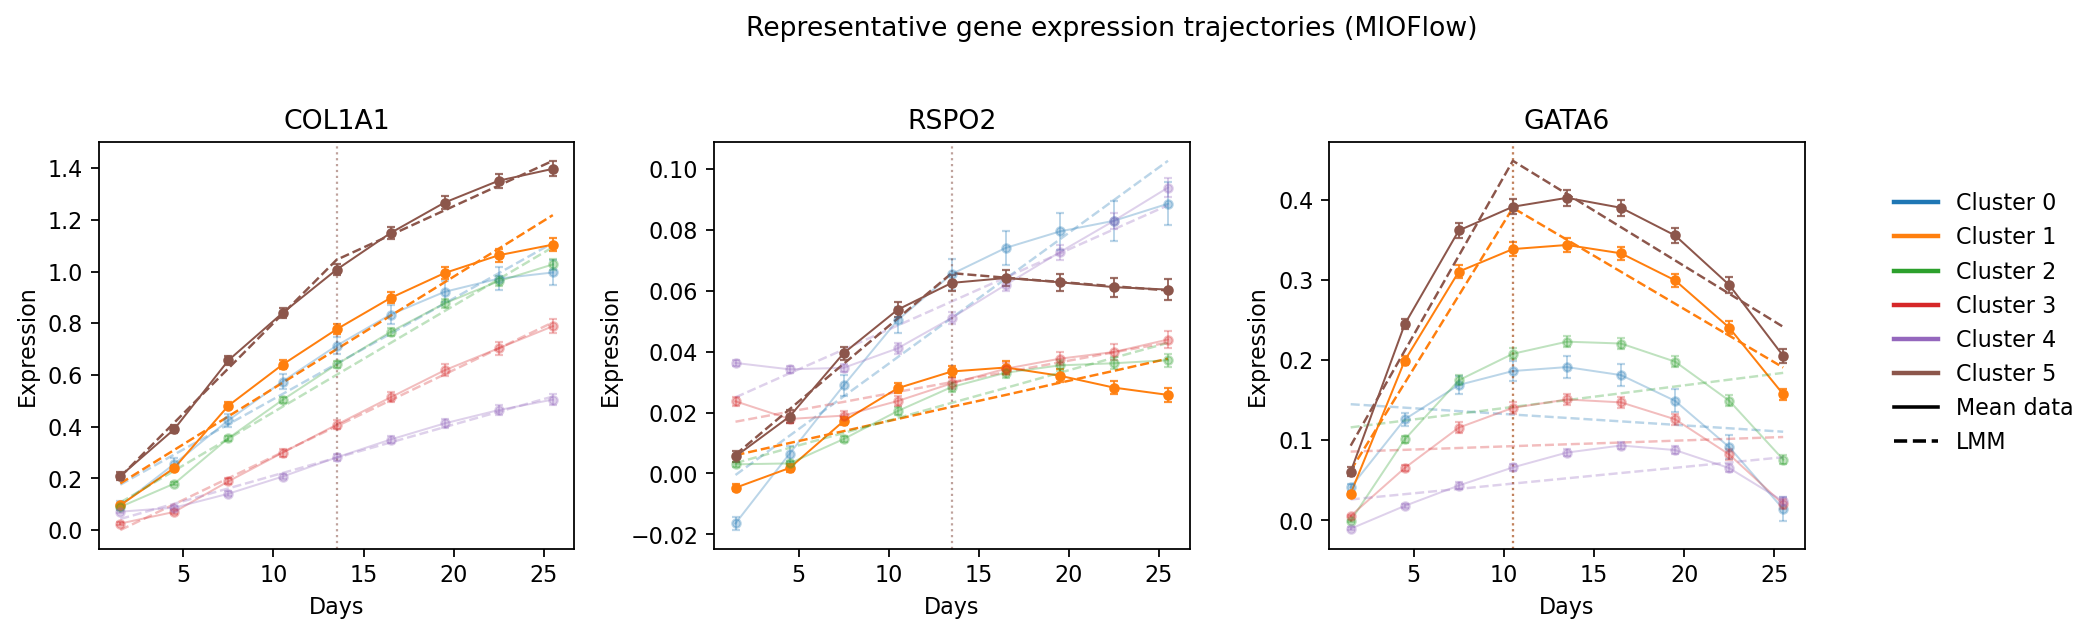

In [50]:
# ----- Example usage (repeat the same gene three times to preview style) -----
alphas = [0.3, 1, 0.3, 0.3, 0.3, 1]
genenames = ["COL1A1", "RSPO2", "GATA6"]

###########################################
# set path to the downloaded UOTReg folder
###########################################
# make suret that you correctly set the `result_folder` variable at the start of the notebook 
json_paths = [result_folder+"results/dynamics/embryoid/LMM/mio/COL1A1_lmm_viz_mio.json",
              result_folder+"results/dynamics/embryoid/LMM/mio/RSPO2_lmm_viz_mio.json",
              result_folder+"results/dynamics/embryoid/LMM/mio/GATA6_lmm_viz_mio.json"]   # same file for demo panes
plot_lmm_1x3(json_paths, genenames, title="Representative gene expression trajectories (MIOFlow)", cluster_alphas=alphas)